In [ ]:
# Adapted from https://keras.io/examples/vision/mnist_convnet/

In [2]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc('font', **{'family':'normal', 'weight':'normal','size':21})

# Create DataFrame for Benford's Law Distribution & define helper functions

In [3]:
# create dataframe with benford's law distribution
benford = pd.DataFrame.from_dict({
    '1': 30.1,
    '2': 17.6,
    '3': 12.5,
    '4': 9.7,
    '5': 7.9,
    '6': 6.7,
    '7': 5.8,
    '8': 5.1,
    '9': 4.6
}, orient= 'index')
benford.columns = ['benford']

In [4]:
def get_leading_digit(x):
    '''
    Remove negative sign and get first non-zero digit (ignoring decimal) - used with dataframe of weight values to get their leading digit
    '''
    x = str(abs(x))
    if x[0] == '0':
        return str(int(x.split(".")[1]))[0]
    else:
        return x.split(".")[0]

In [5]:
def plot_benford_for_first_layer(title, save_file = None):
    
    # convert weights to dataframe
    leading_digits = pd.DataFrame(model.layers[0].get_weights()[0].flatten())
    leading_digits.columns = ['weight']
    leading_digits['leading_digit'] = leading_digits['weight'].apply(get_leading_digit)
    leading_digits = pd.DataFrame(100 * leading_digits['leading_digit'].value_counts()/len(leading_digits))

    # merge with benford's law distribution
    df = pd.merge(benford, leading_digits, left_index=True, right_index=True, how='left')
    df['deviation'] = df['leading_digit'] - df['benford']
    df['abs_deviation'] = abs(df['deviation'])
    mad = round(df['abs_deviation'].mean(),2)
    
    # plot
    if not save_file:
        print(df)
        print()
        print(f">>> Mean absolute deviation: {mad}")
    ax = df[['leading_digit','benford']].plot(kind='bar', title=title +' (MAD=' + str(mad) + ')', figsize = (20,10), cmap="Accent")
    ax.set_ylim(0, 50)
    
    # save plot
    if save_file:
        plt.savefig(save_file, dpi=300, bbox_inches='tight')
        
    return mad

In [6]:
def plot_benford_for_all_layers(title, save_file = None):
    # gather all weights in the model
    weights = []
    for layer in model.layers:
        if len(layer.get_weights()) > 0:
            weights.extend(layer.get_weights()[0].flatten())

    # convert weights to dataframe
    leading_digits = pd.DataFrame(weights)
    leading_digits.columns = ['weight']
    leading_digits['leading_digit'] = leading_digits['weight'].apply(get_leading_digit)
    leading_digits = pd.DataFrame(100 * leading_digits['leading_digit'].value_counts()/len(leading_digits))

    # merge with benford's law distribution
    df = pd.merge(benford, leading_digits, left_index=True, right_index=True, how='left')
    df['deviation'] = df['leading_digit'] - df['benford']
    df['abs_deviation'] = abs(df['deviation'])
    mad = round(df['abs_deviation'].mean(),2)

    # plot
    if not save_file:
        print(df)
        print()
        print(f">>> Mean absolute deviation: {round(df['abs_deviation'].mean(),2)}")
    ax = df[['leading_digit','benford']].plot(kind='bar', title=title +' (MAD=' + str(mad) + ')', figsize = (20,10), cmap="Accent")
    ax.set_ylim(0, 50)
    
    # save plot
    if save_file:
        plt.savefig(save_file, dpi=300, bbox_inches='tight')
        
    return mad

In [7]:
# Keras callback to plot leading digit distribution after each epoch
class PlotBenford(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.epoch = 0
        plot_benford_for_first_layer("BEFORE TRAINING: 1st layer weights leading digit distribution vs. Benford's Law", 'plots/before_layer1.jpg')
        plot_benford_for_all_layers("BEFORE TRAINING: All layers' weights leading digit distribution vs. Benford's Law", 'plots/before_layers.jpg')
        acc = model.evaluate(x_train, y_train, verbose=0)[1]
        valacc = model.evaluate(x_test, y_test, verbose=0)[1]
        mad = plot_benford_for_first_layer(f"Leading weight digit distribution vs Benford's Law: Epoch {self.epoch} (Val. Acc.={100*valacc:.2f}%)", f'gif/epoch_{self.epoch:02}.jpg')
        
        self.mads = [mad]
        self.valaccs = [valacc]
        self.accs = [acc]
        
    def on_train_end(self, logs={}):
        plot_benford_for_first_layer("AFTER TRAINING: 1st layer weights leading digit distribution vs. Benford's Law", 'plots/after_layer1.jpg')
        plot_benford_for_all_layers("AFTER TRAINING: All layers' weights leading digit distribution vs. Benford's Law", 'plots/after_layers.jpg')

    def on_epoch_end(self, batch, logs={}):
        self.epoch+=1
        valacc = logs.get('val_acc')
        acc = logs.get('acc')
        mad = plot_benford_for_first_layer(f"Leading weight digit distribution vs Benford's Law: Epoch {self.epoch} (Val. Acc.={100*valacc:.2f}%)", f'gif/epoch_{self.epoch:02}.jpg')
        self.mads.append(mad)
        self.valaccs.append(valacc)
        self.accs.append(acc)

# Train CNN on MNIST 

In [8]:
# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")


# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [9]:
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1600)              0         
_________________________________________

In [10]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

Train on 54000 samples, validate on 6000 samples


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


Epoch 1/100
54000/54000 [==============================] - 73s 1ms/sample - loss: 0.3438 - acc: 0.8924 - val_loss: 0.0758 - val_acc: 0.9783
Epoch 2/100
54000/54000 [==============================] - 47s 861us/sample - loss: 0.1054 - acc: 0.9679 - val_loss: 0.0524 - val_acc: 0.9862
Epoch 3/100
54000/54000 [==============================] - 44s 811us/sample - loss: 0.0783 - acc: 0.9756 - val_loss: 0.0426 - val_acc: 0.9875
Epoch 4/100
54000/54000 [==============================] - 43s 799us/sample - loss: 0.0640 - acc: 0.9796 - val_loss: 0.0361 - val_acc: 0.9902
Epoch 5/100
54000/54000 [==============================] - 41s 759us/sample - loss: 0.0559 - acc: 0.9825 - val_loss: 0.0347 - val_acc: 0.9895
Epoch 6/100
54000/54000 [==============================] - 41s 765us/sample - loss: 0.0504 - acc: 0.9837 - val_loss: 0.0322 - val_acc: 0.9908
Epoch 7/100
54000/54000 [==============================] - 38s 699us/sample - loss: 0.0477 - acc: 0.9849 - val_loss: 0.0298 - val_acc: 0.9917
Epoch 8/

/Users/alex/anaconda3/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


54000/54000 [==============================] - 32s 590us/sample - loss: 0.0270 - acc: 0.9910 - val_loss: 0.0252 - val_acc: 0.9937
Epoch 19/100
54000/54000 [==============================] - 29s 530us/sample - loss: 0.0252 - acc: 0.9914 - val_loss: 0.0271 - val_acc: 0.9930
Epoch 20/100
54000/54000 [==============================] - 30s 555us/sample - loss: 0.0249 - acc: 0.9919 - val_loss: 0.0293 - val_acc: 0.9920
Epoch 21/100
54000/54000 [==============================] - 29s 532us/sample - loss: 0.0239 - acc: 0.9921 - val_loss: 0.0309 - val_acc: 0.9925
Epoch 22/100
54000/54000 [==============================] - 32s 584us/sample - loss: 0.0236 - acc: 0.9921 - val_loss: 0.0289 - val_acc: 0.9927
Epoch 23/100
54000/54000 [==============================] - 36s 675us/sample - loss: 0.0224 - acc: 0.9926 - val_loss: 0.0289 - val_acc: 0.9935
Epoch 24/100
54000/54000 [==============================] - 37s 693us/sample - loss: 0.0224 - acc: 0.9930 - val_loss: 0.0295 - val_acc: 0.9927
Epoch 25/100

54000/54000 [==============================] - 35s 639us/sample - loss: 0.0092 - acc: 0.9969 - val_loss: 0.0389 - val_acc: 0.9925
Epoch 76/100
54000/54000 [==============================] - 34s 635us/sample - loss: 0.0099 - acc: 0.9967 - val_loss: 0.0355 - val_acc: 0.9937
Epoch 77/100
54000/54000 [==============================] - 36s 676us/sample - loss: 0.0095 - acc: 0.9967 - val_loss: 0.0378 - val_acc: 0.9928
Epoch 78/100
54000/54000 [==============================] - 36s 674us/sample - loss: 0.0106 - acc: 0.9964 - val_loss: 0.0320 - val_acc: 0.9940
Epoch 79/100
54000/54000 [==============================] - 31s 570us/sample - loss: 0.0095 - acc: 0.9967 - val_loss: 0.0354 - val_acc: 0.9935
Epoch 80/100
54000/54000 [==============================] - 38s 695us/sample - loss: 0.0099 - acc: 0.9966 - val_loss: 0.0375 - val_acc: 0.9922
Epoch 81/100
54000/54000 [==============================] - 37s 684us/sample - loss: 0.0104 - acc: 0.9965 - val_loss: 0.0374 - val_acc: 0.9923
Epoch 82/100

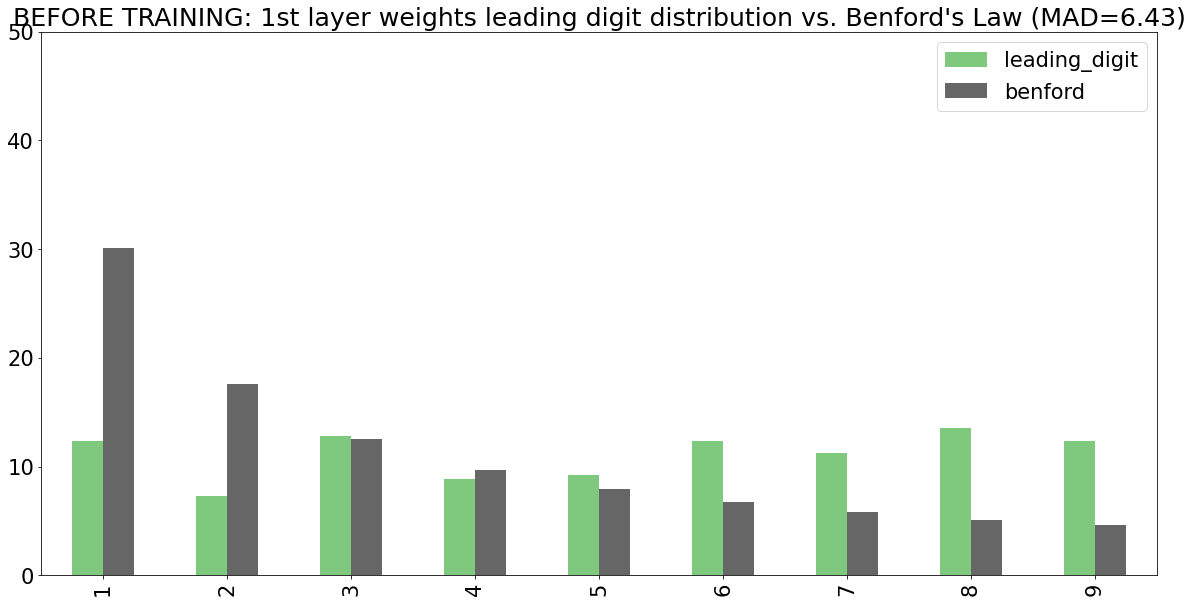

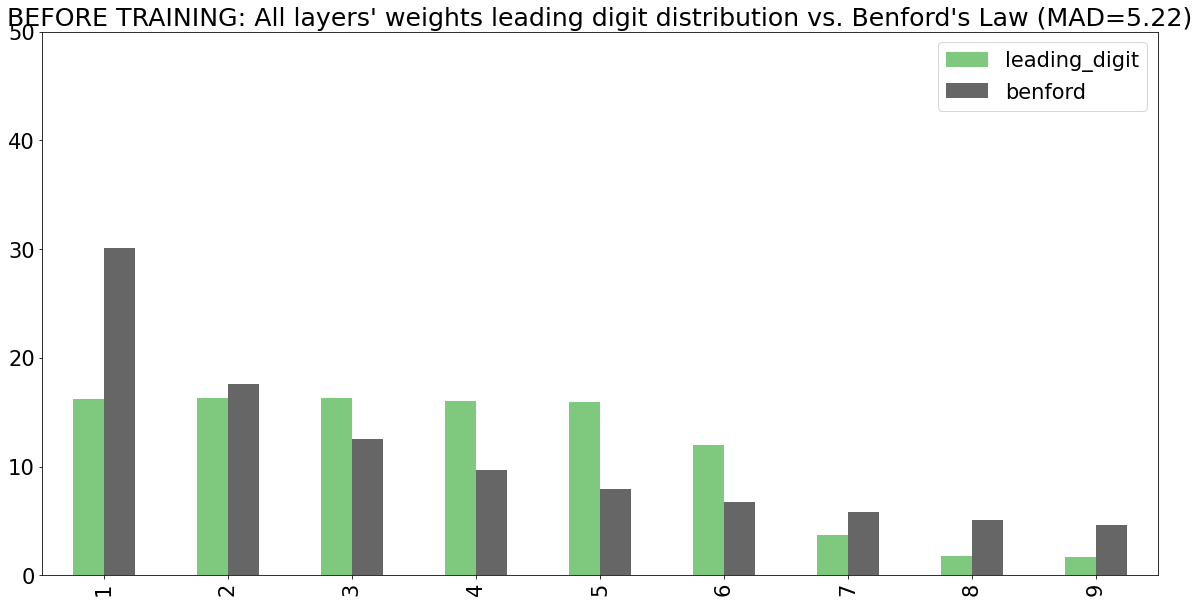

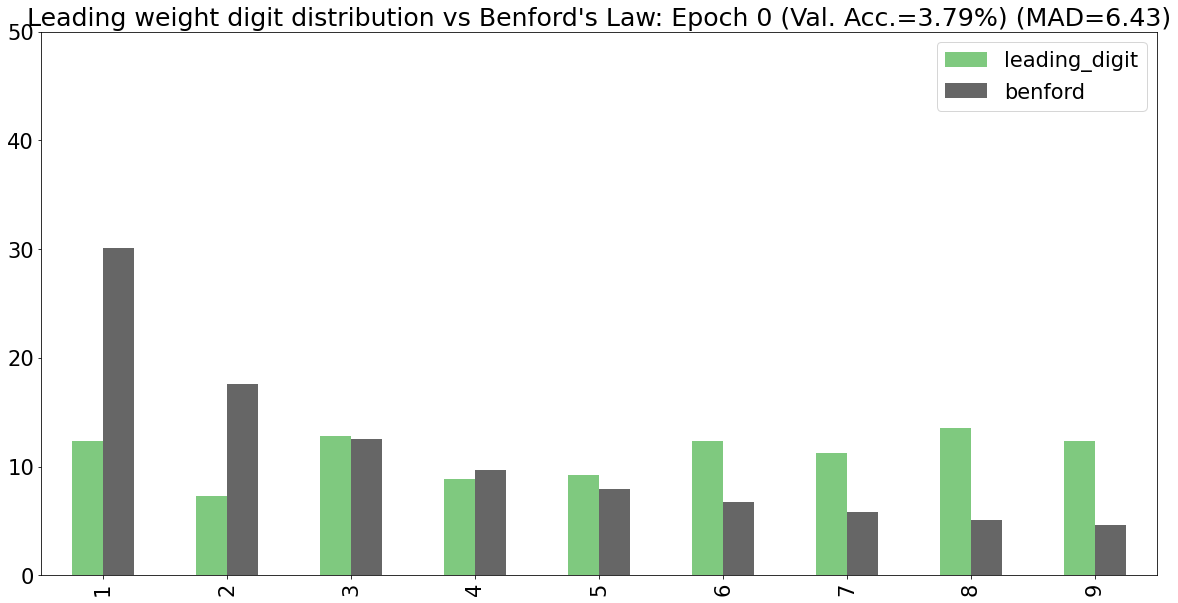

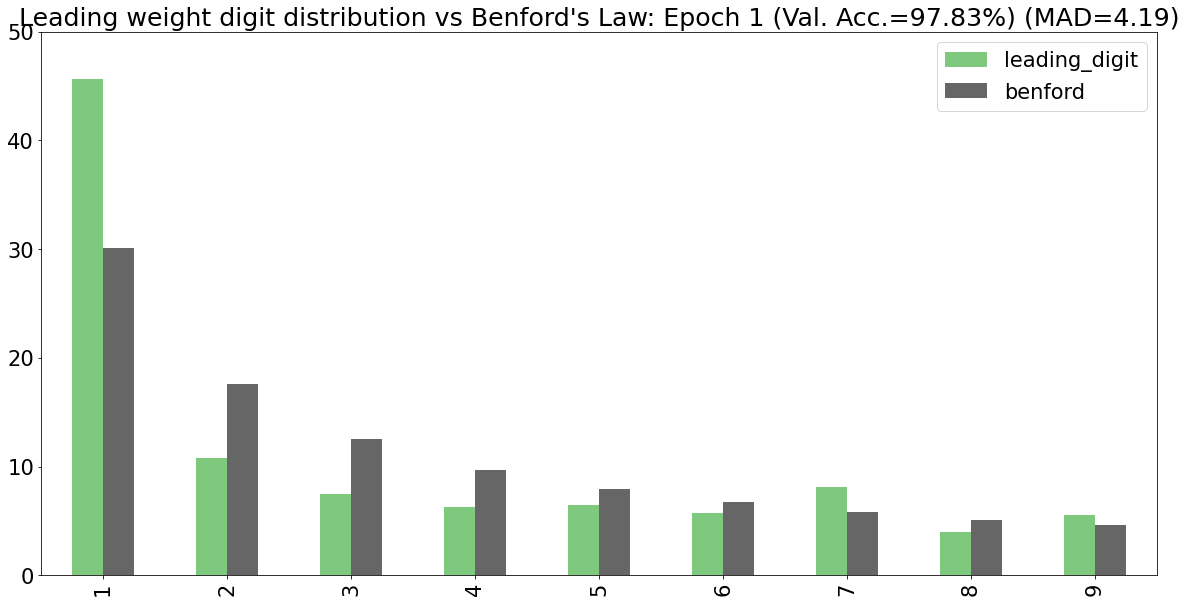

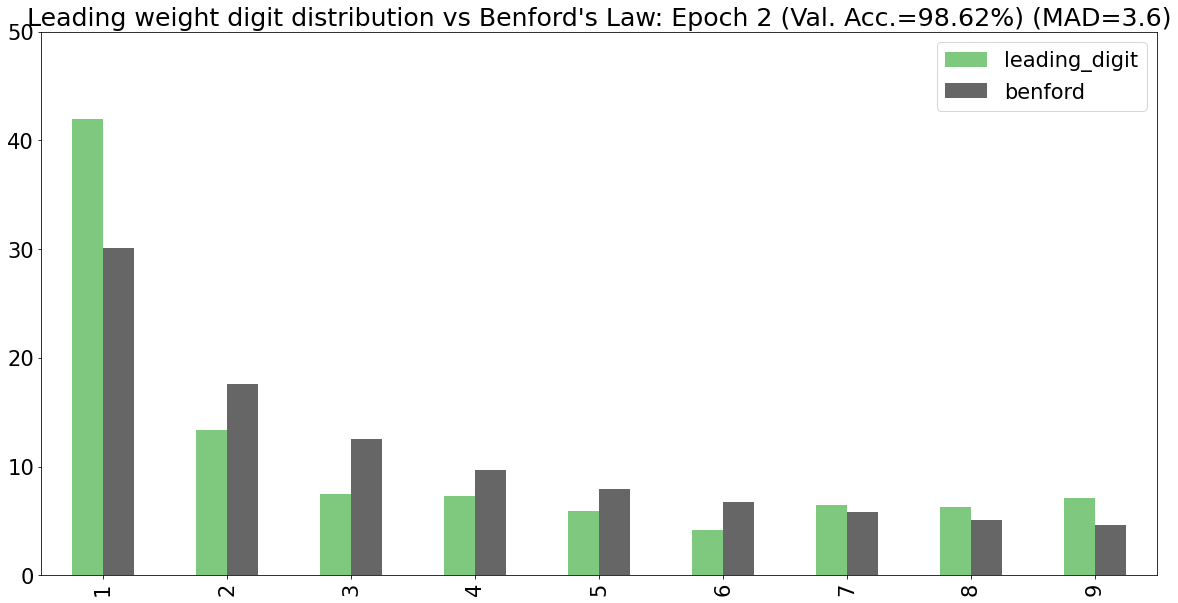

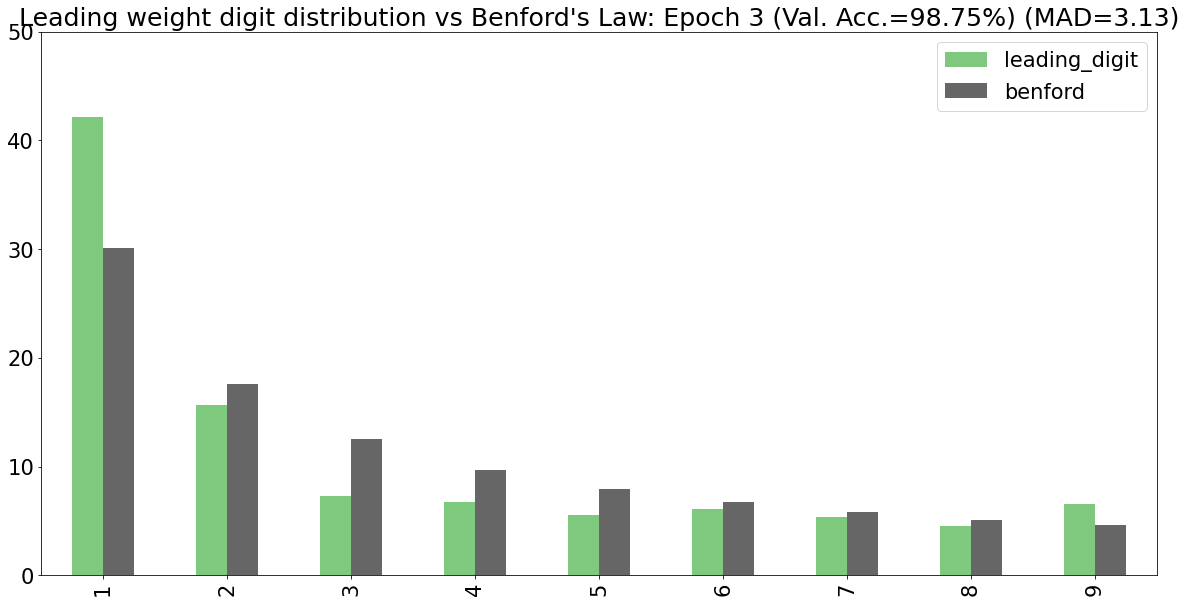

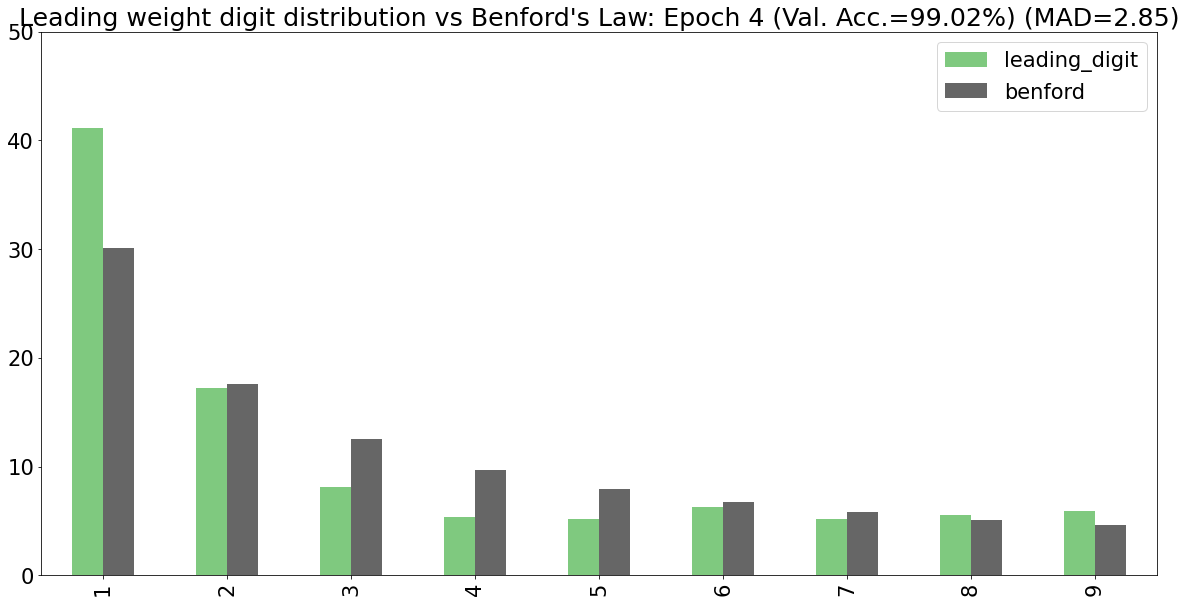

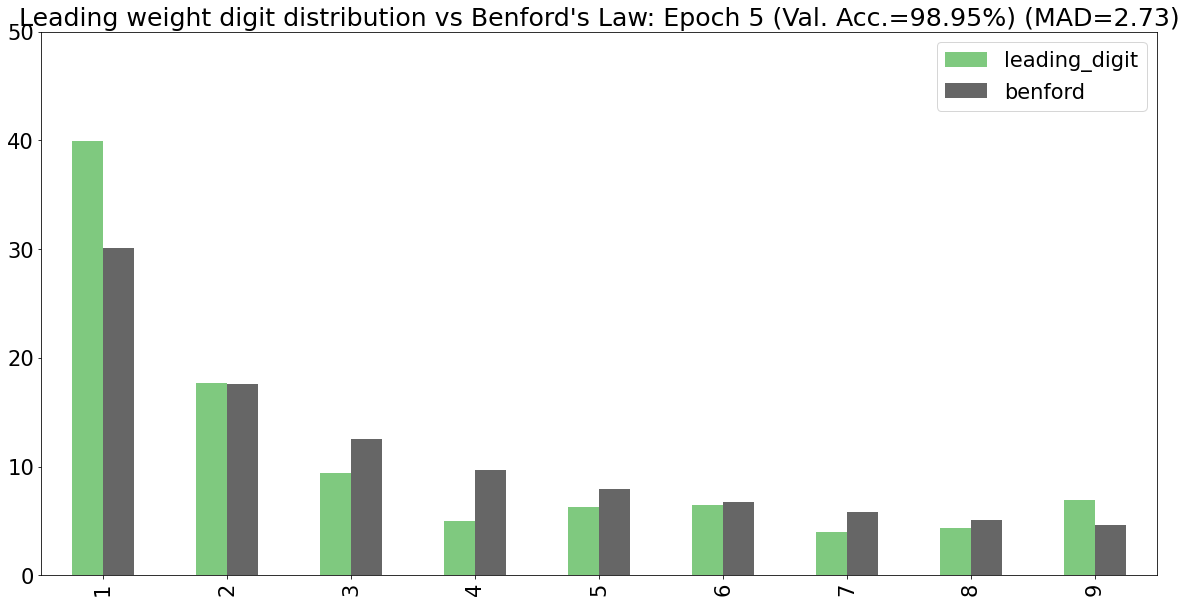

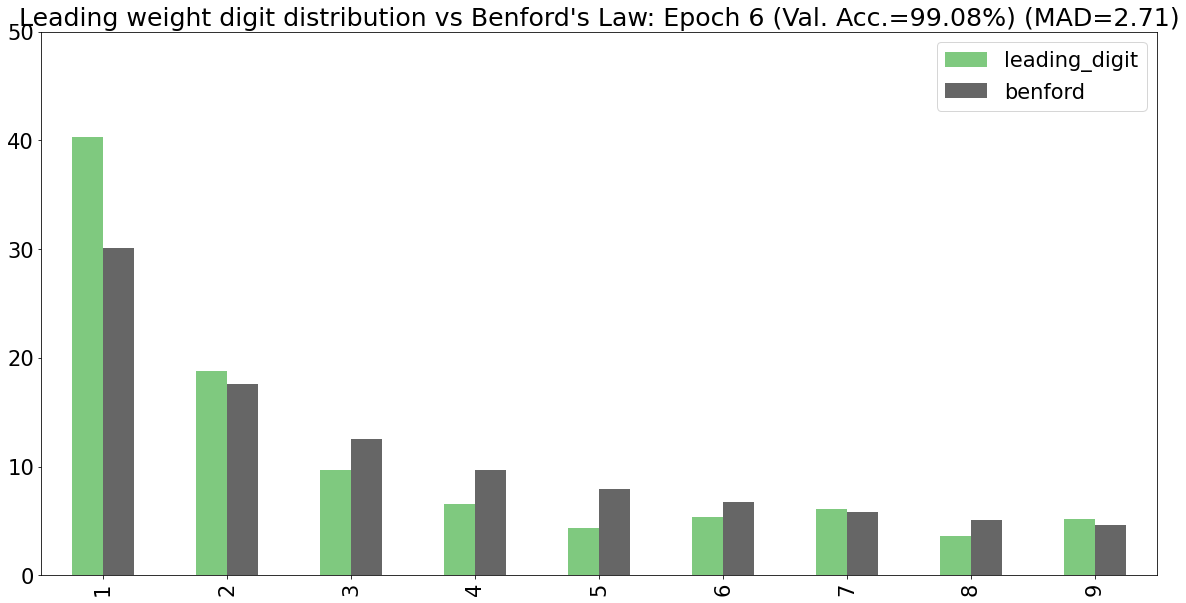

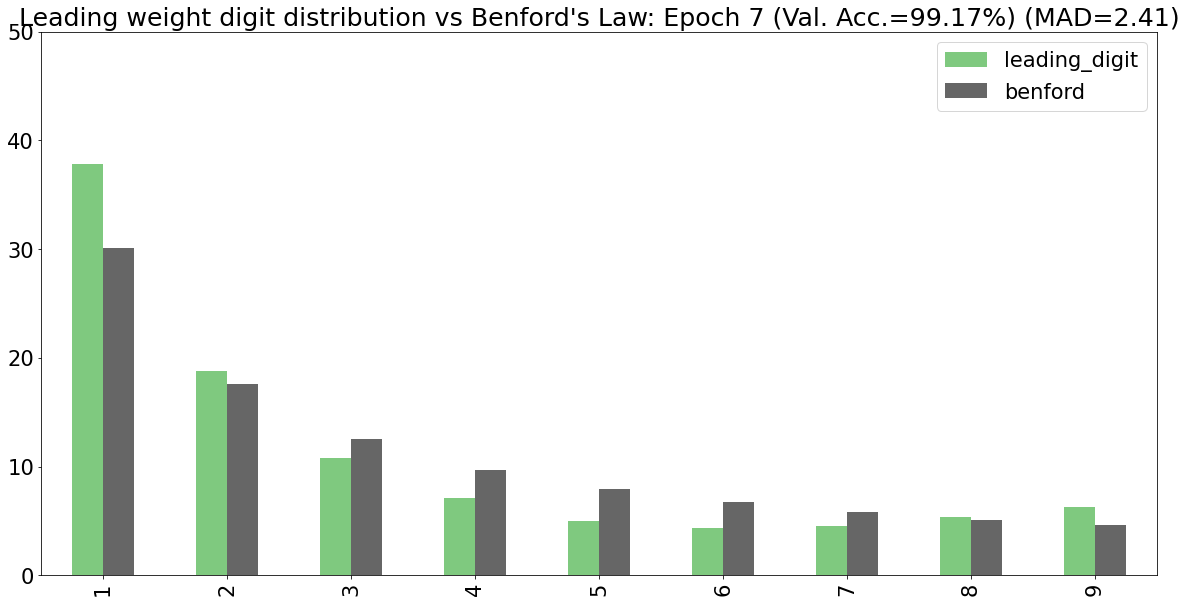

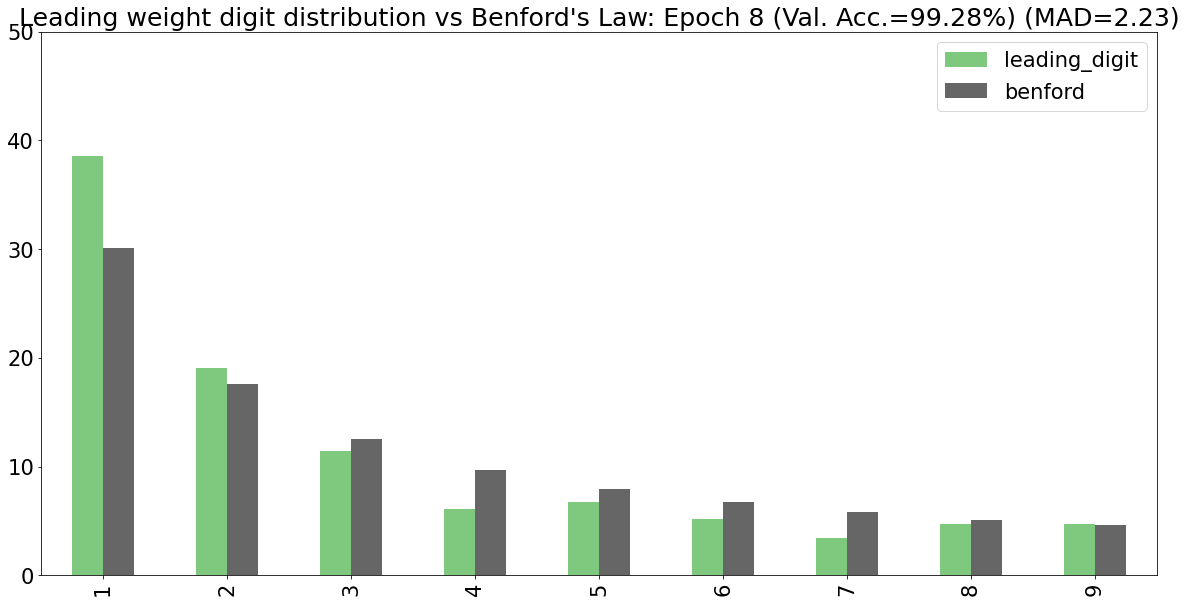

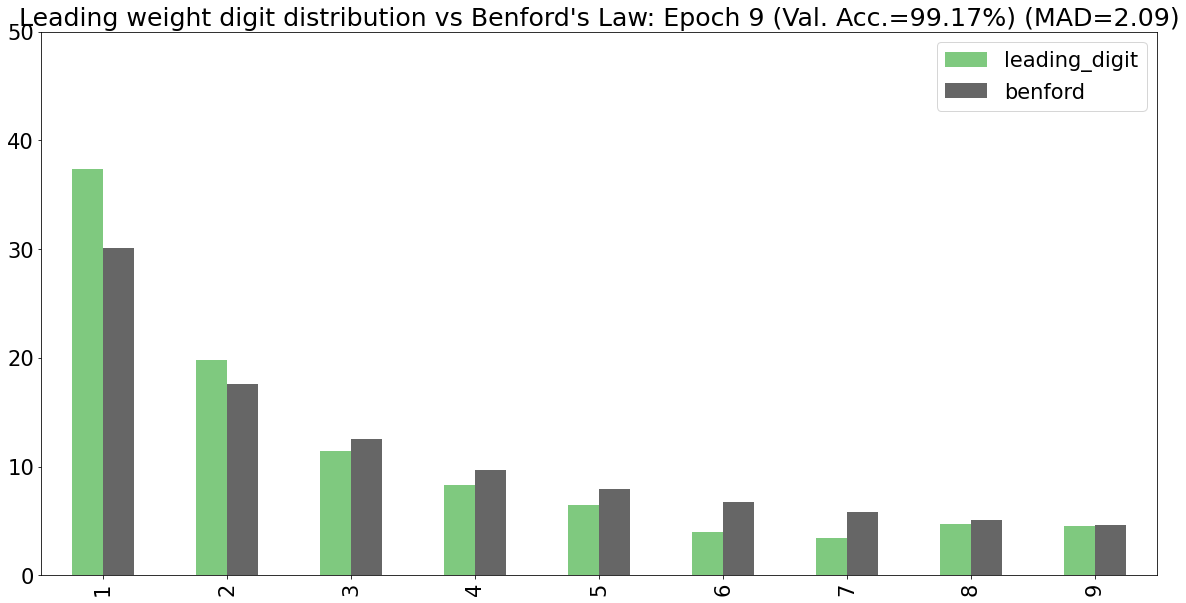

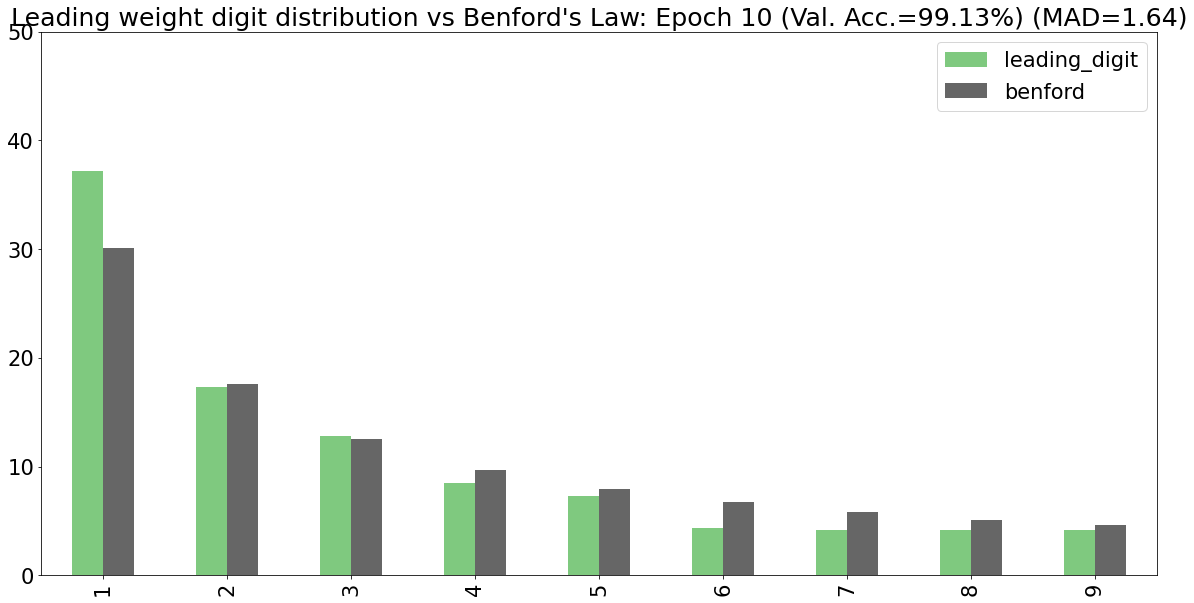

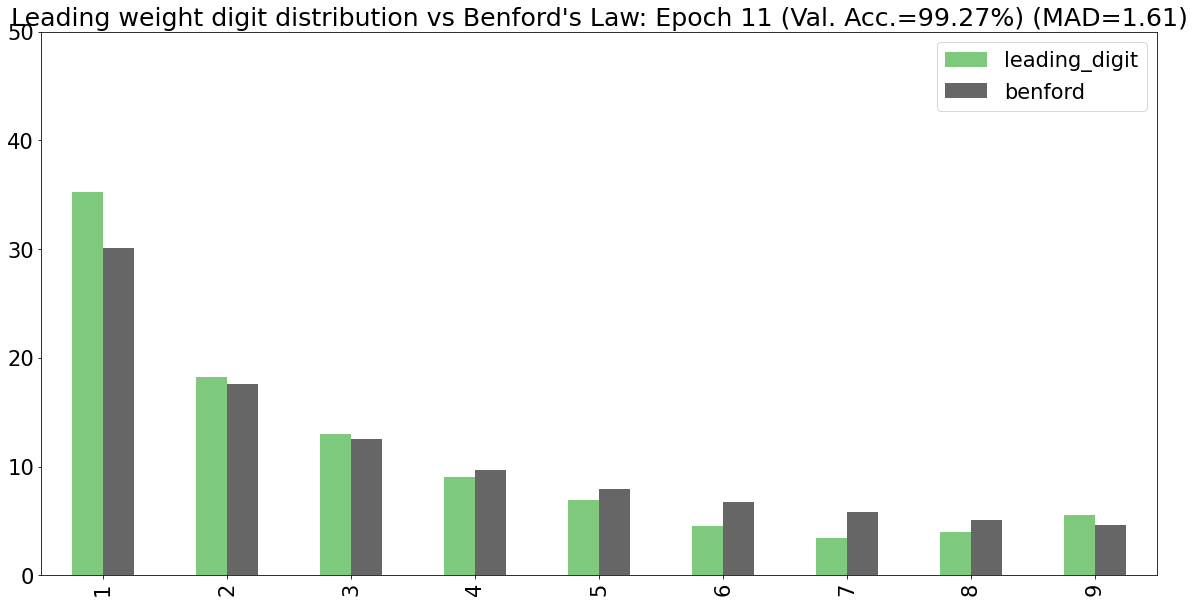

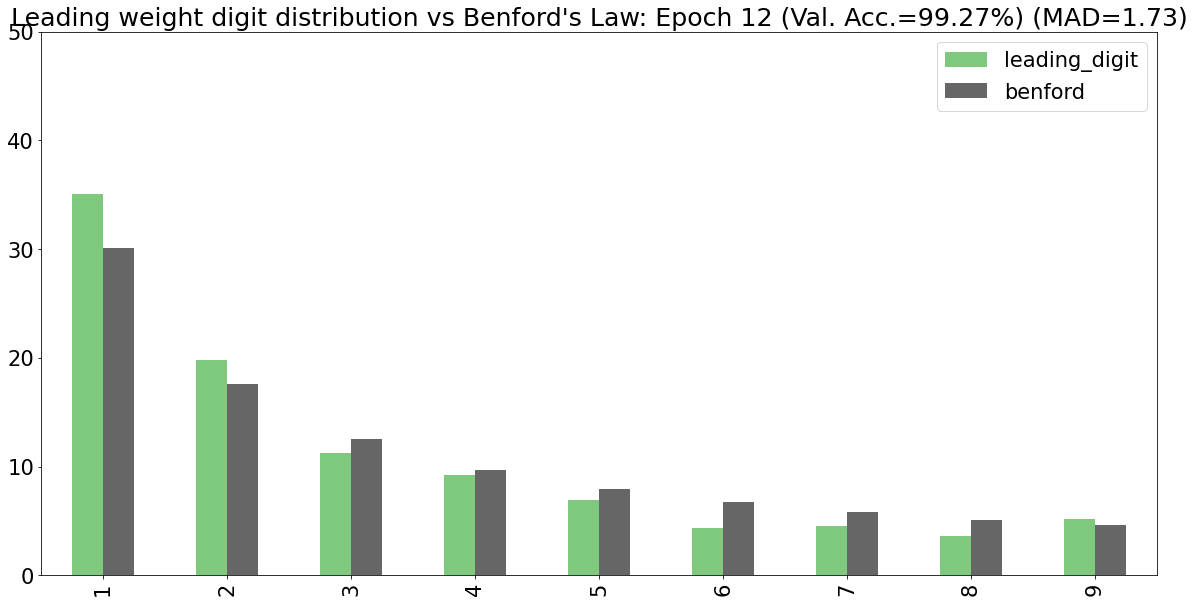

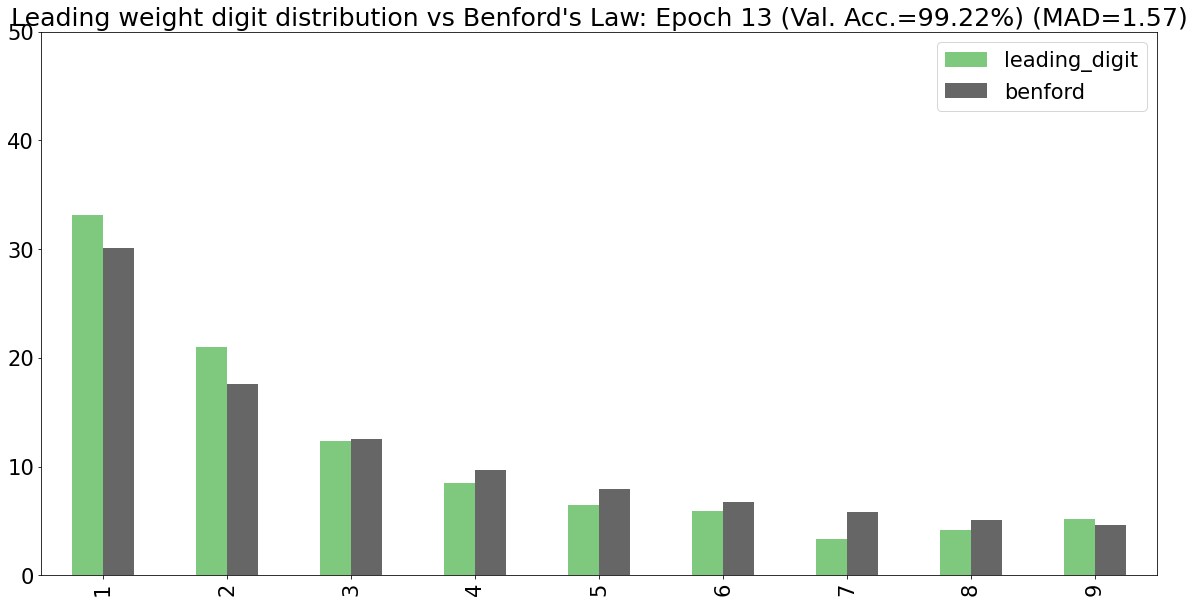

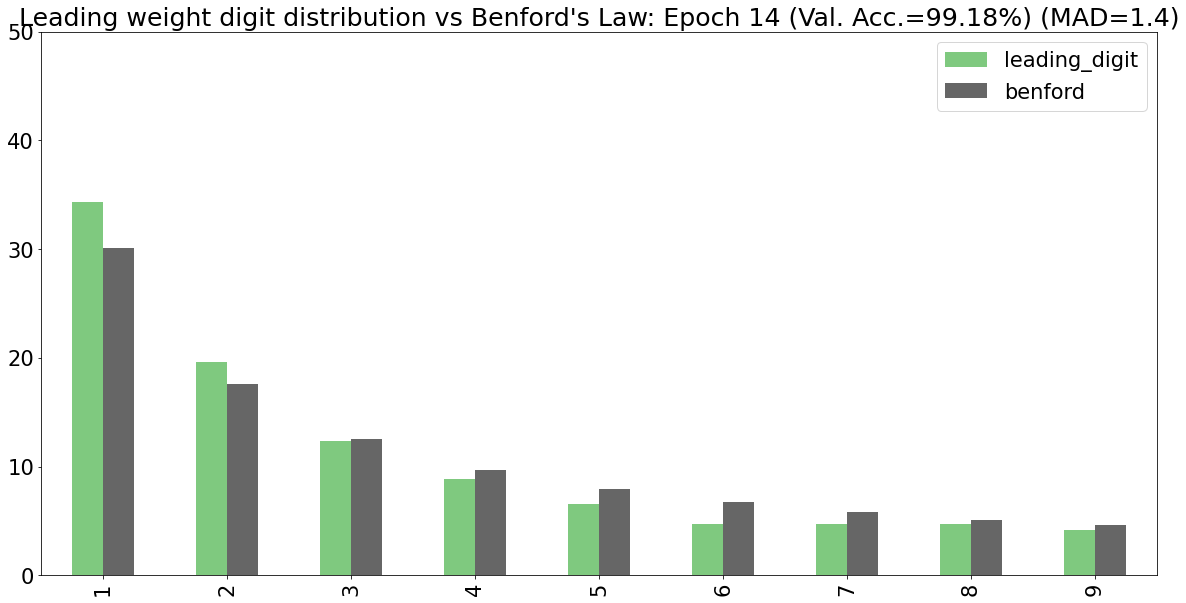

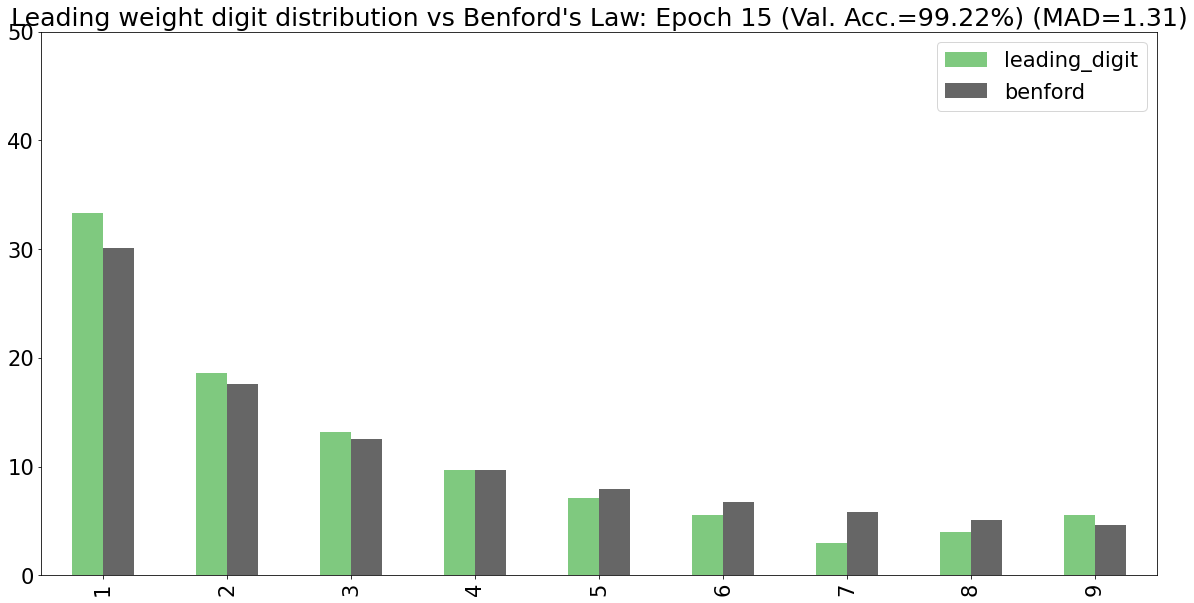

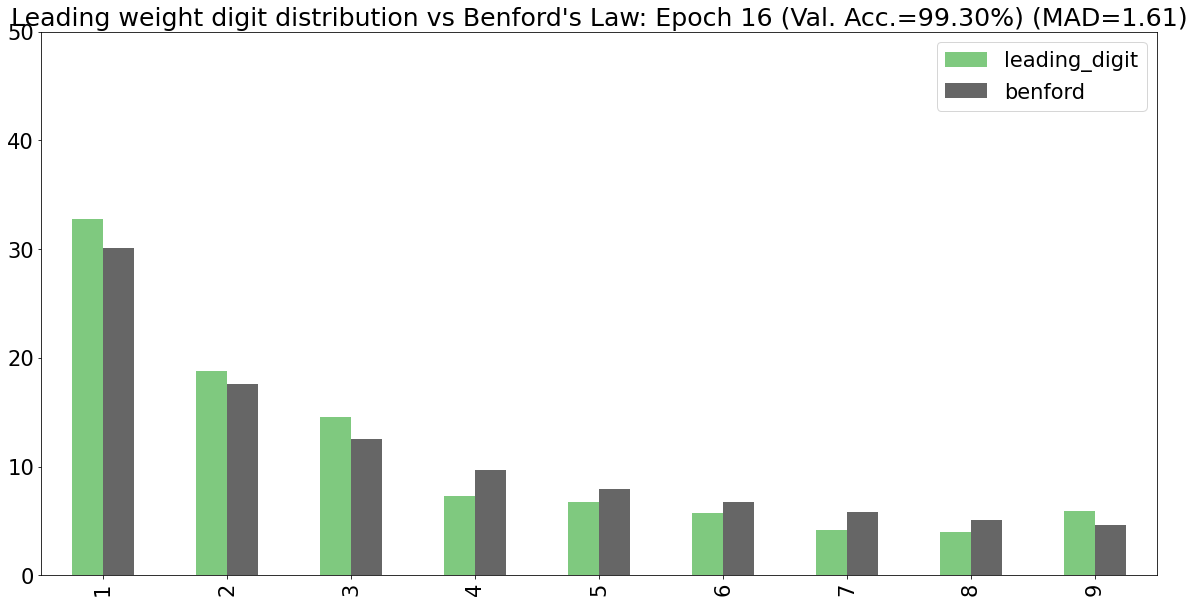

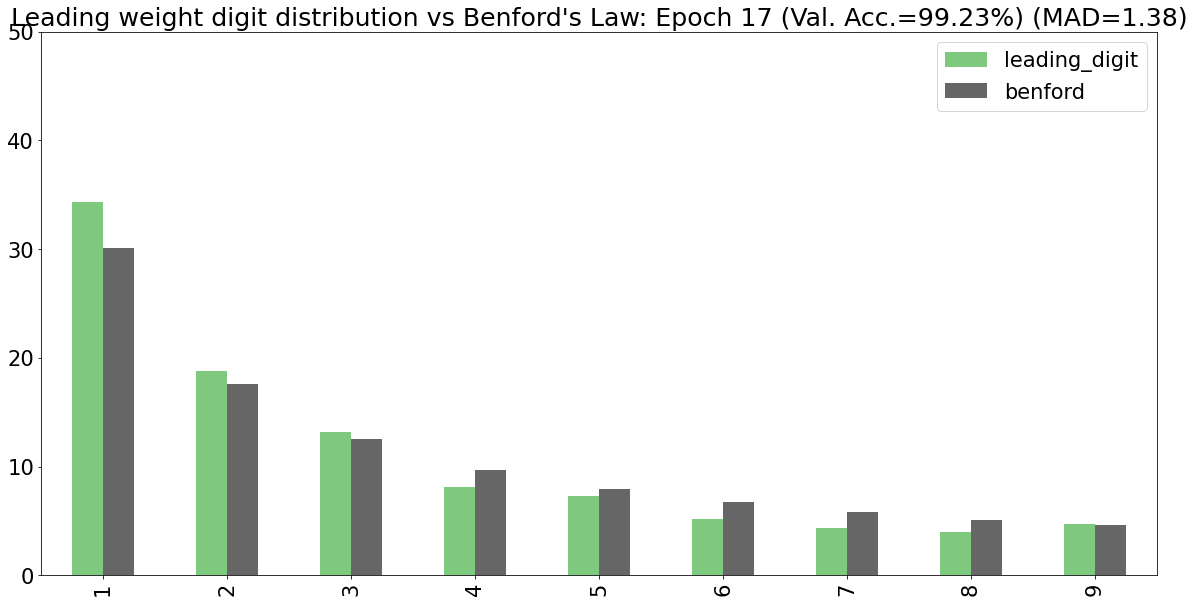

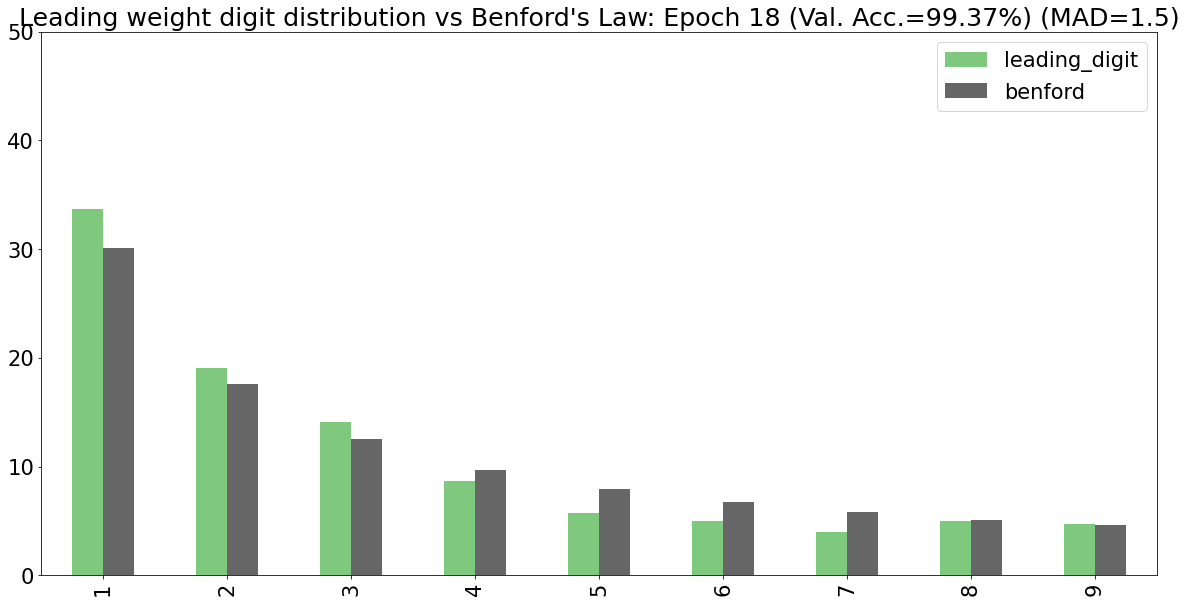

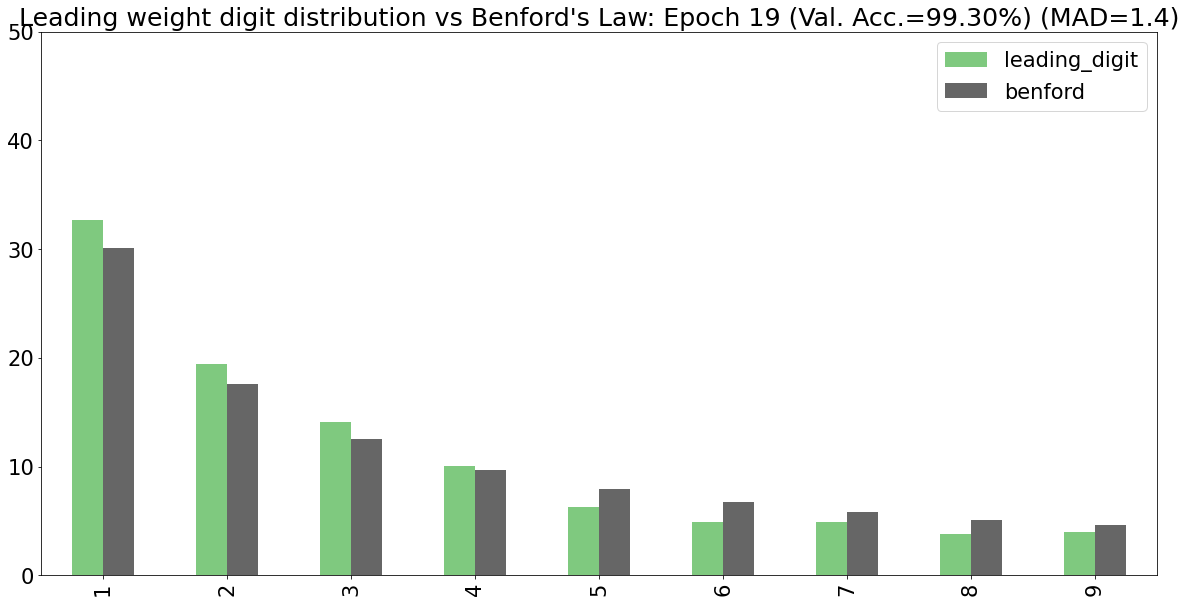

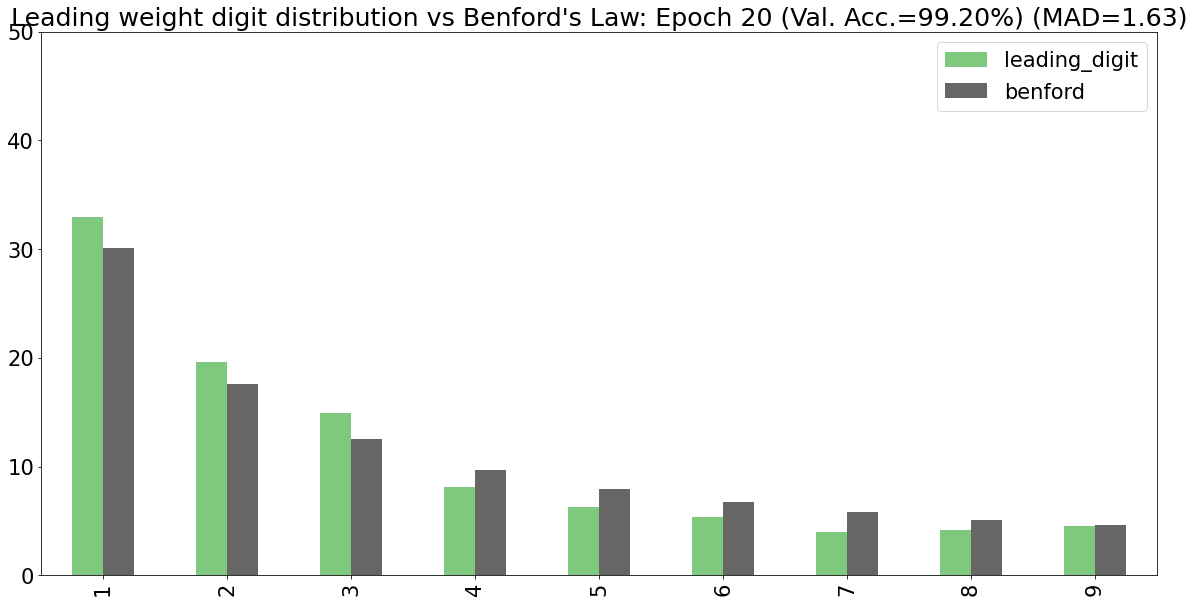

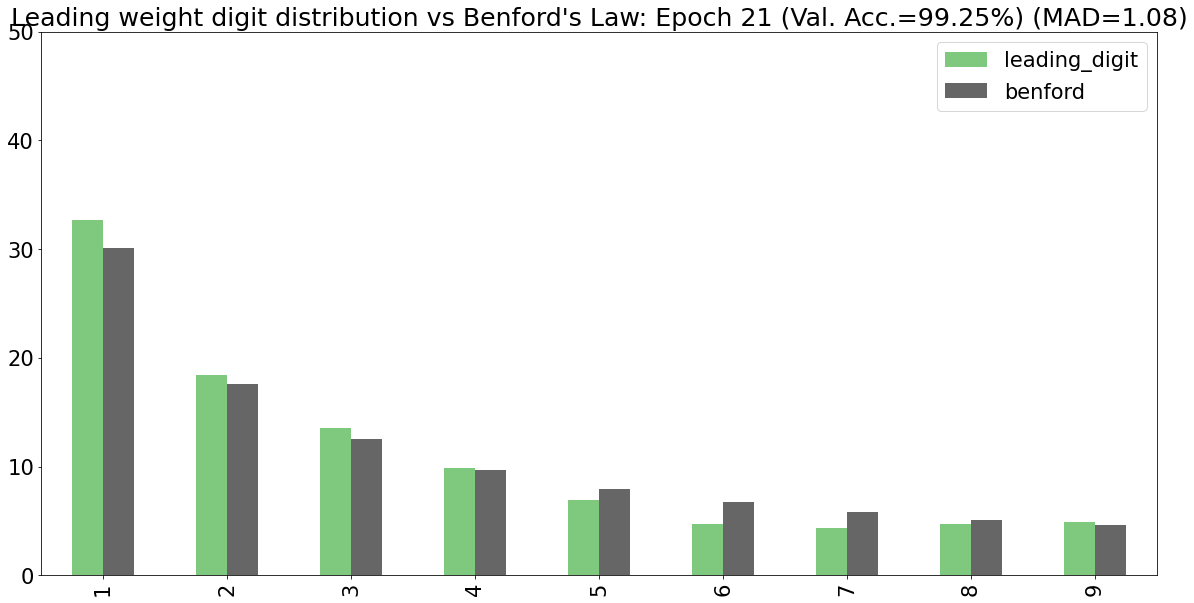

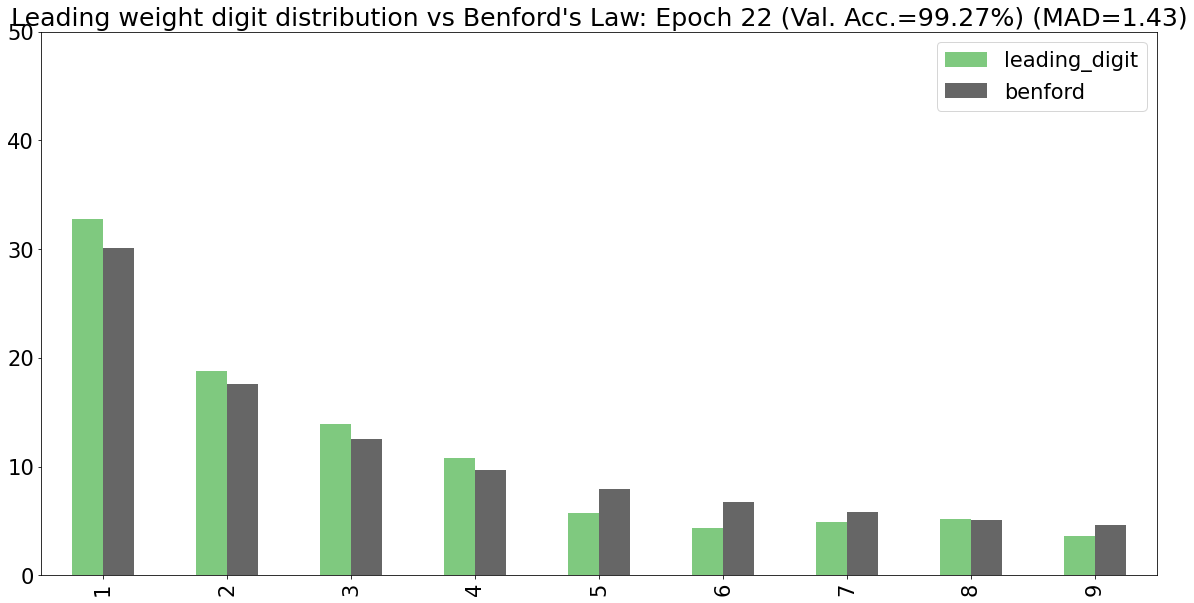

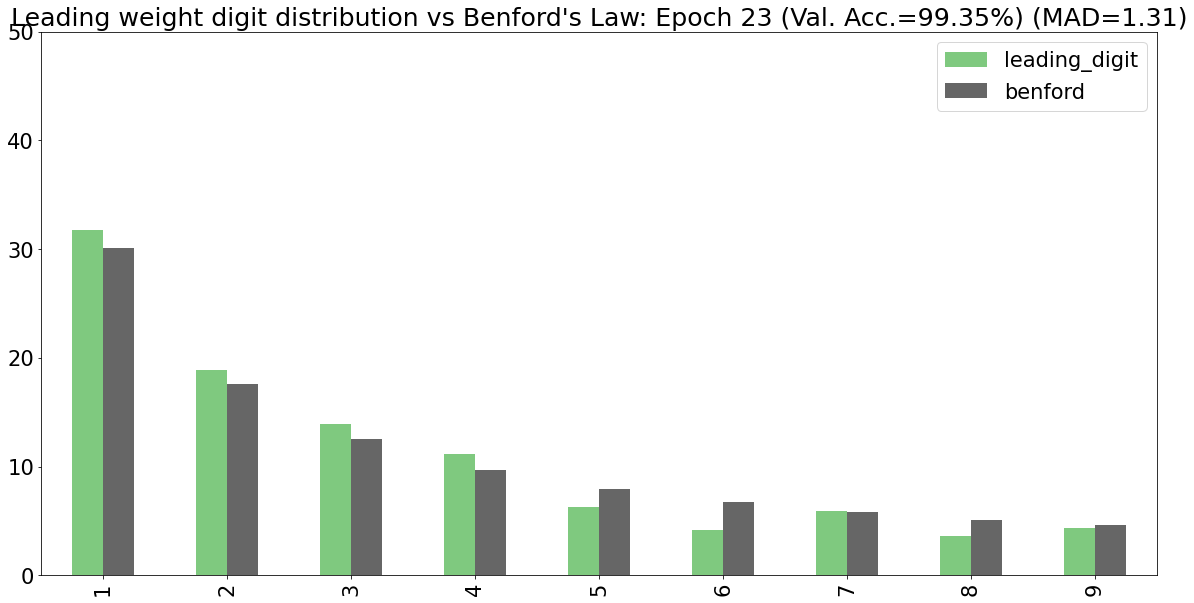

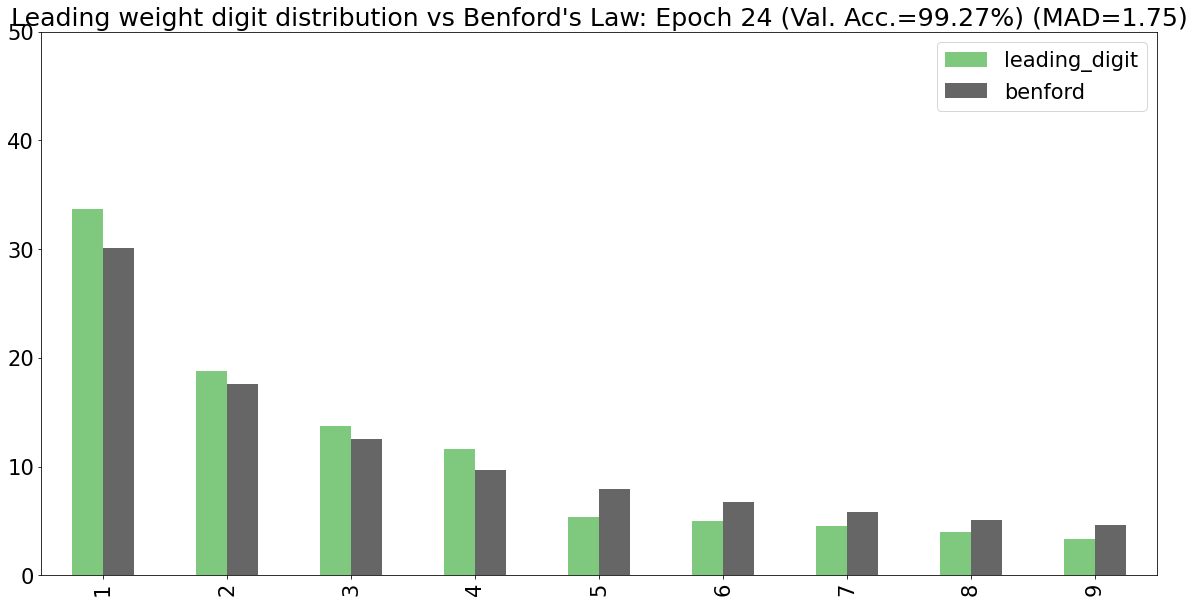

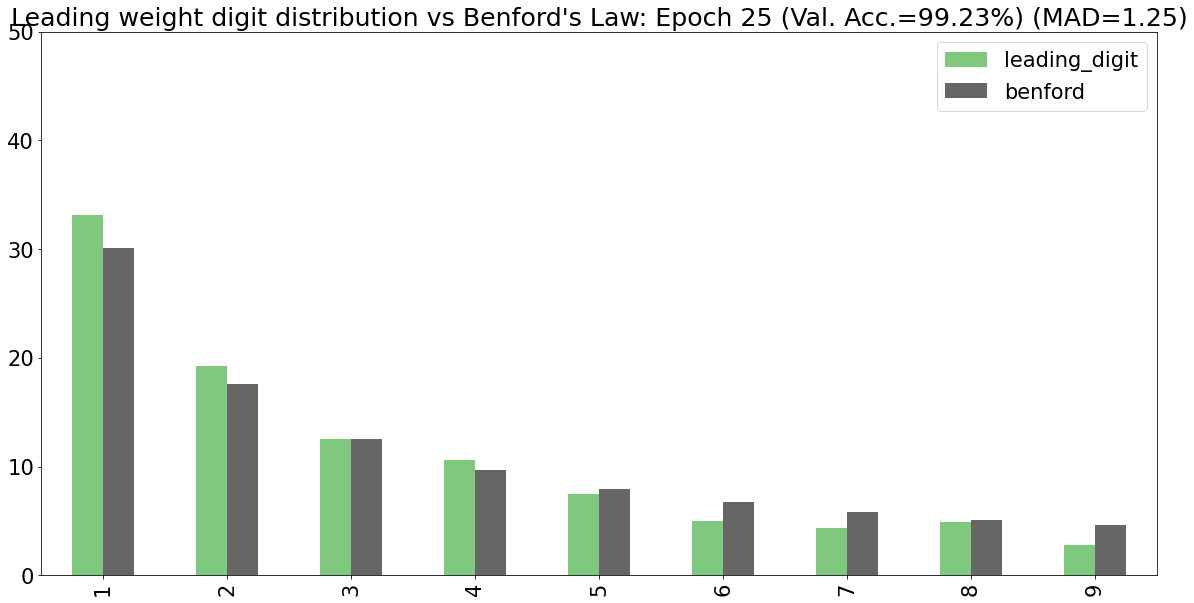

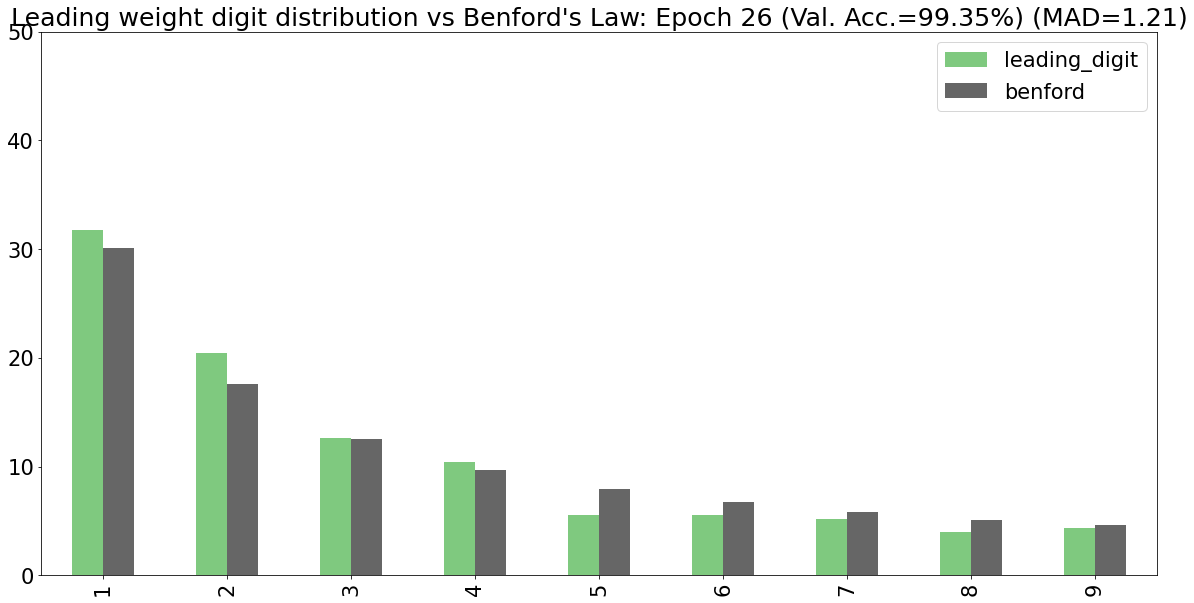

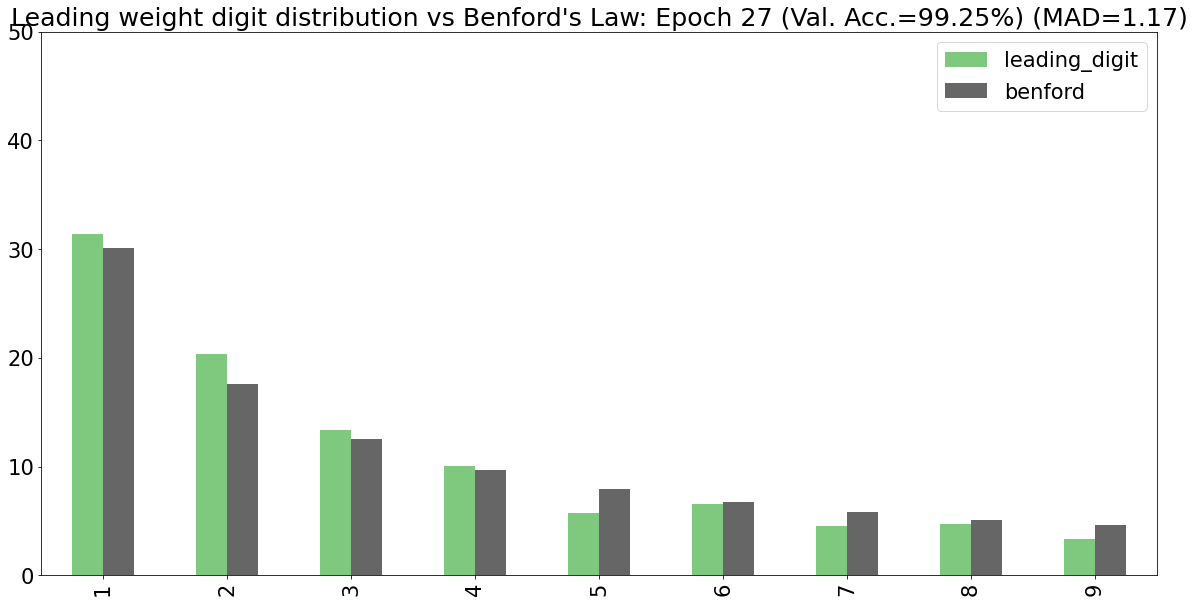

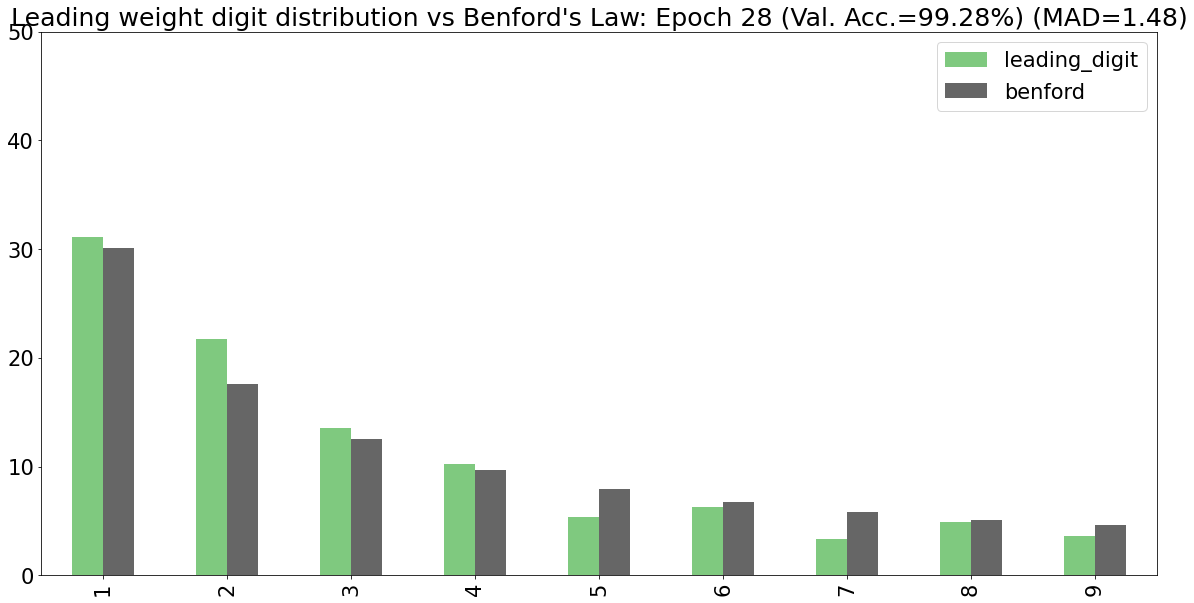

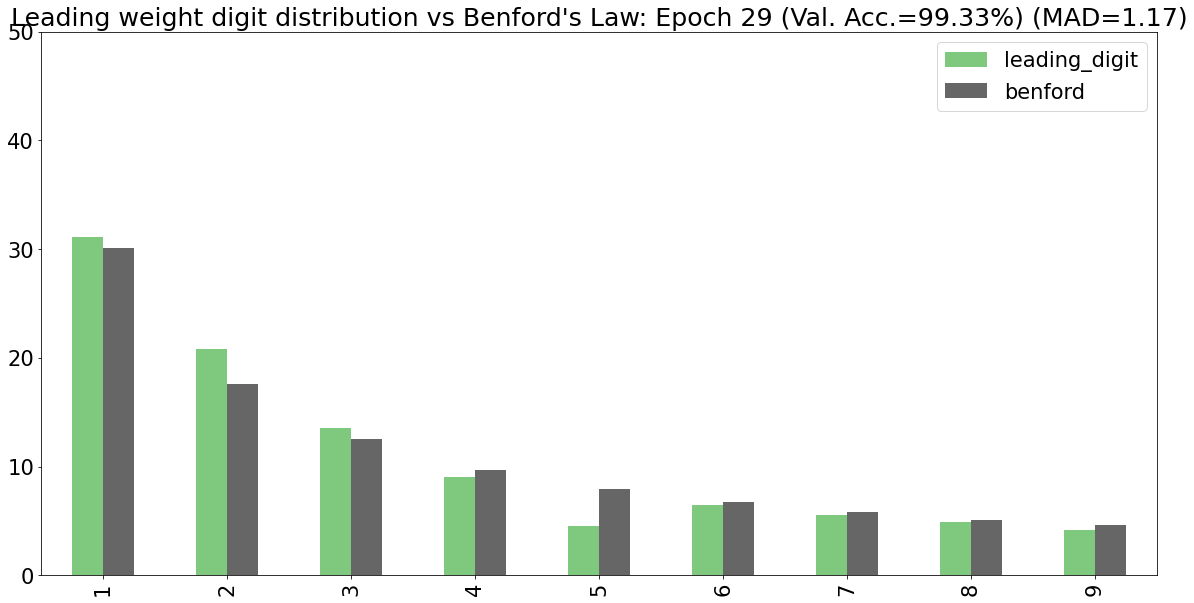

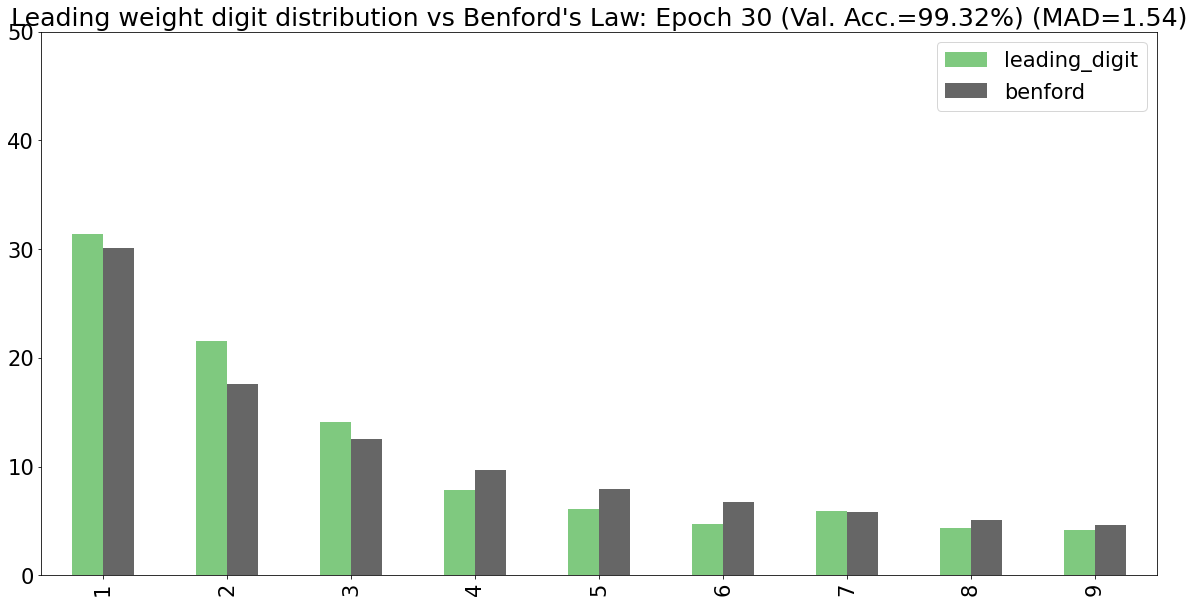

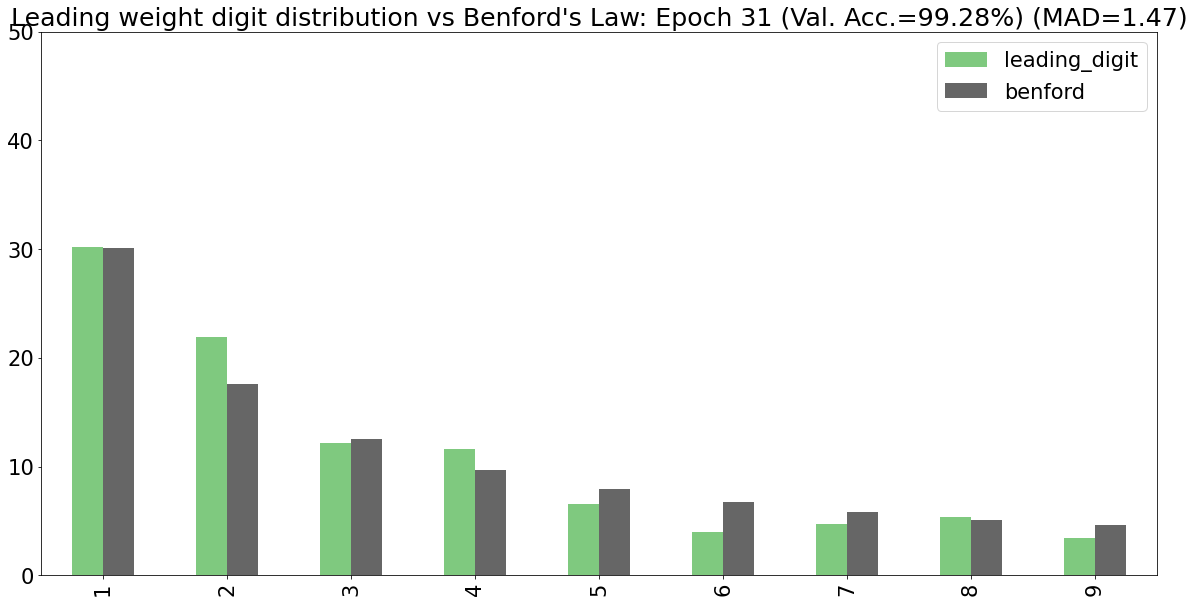

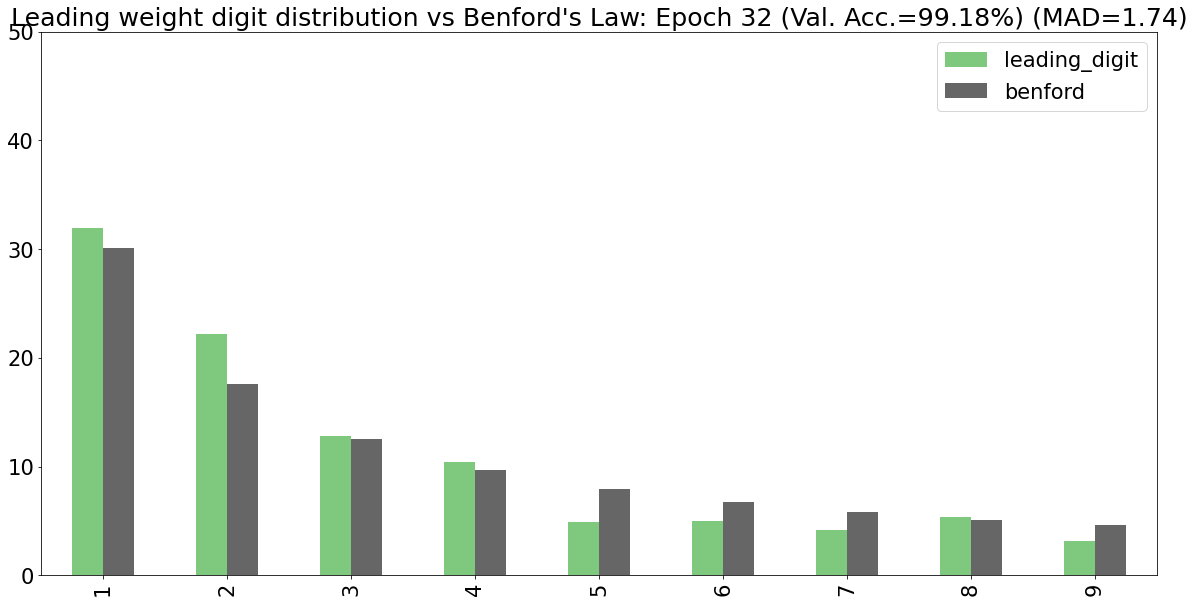

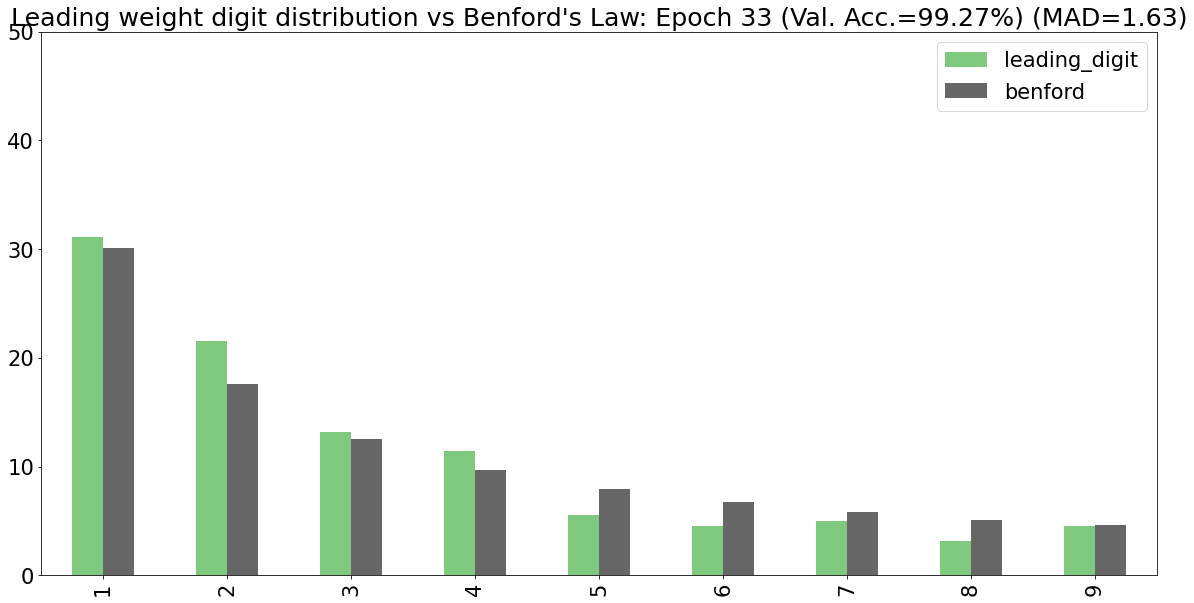

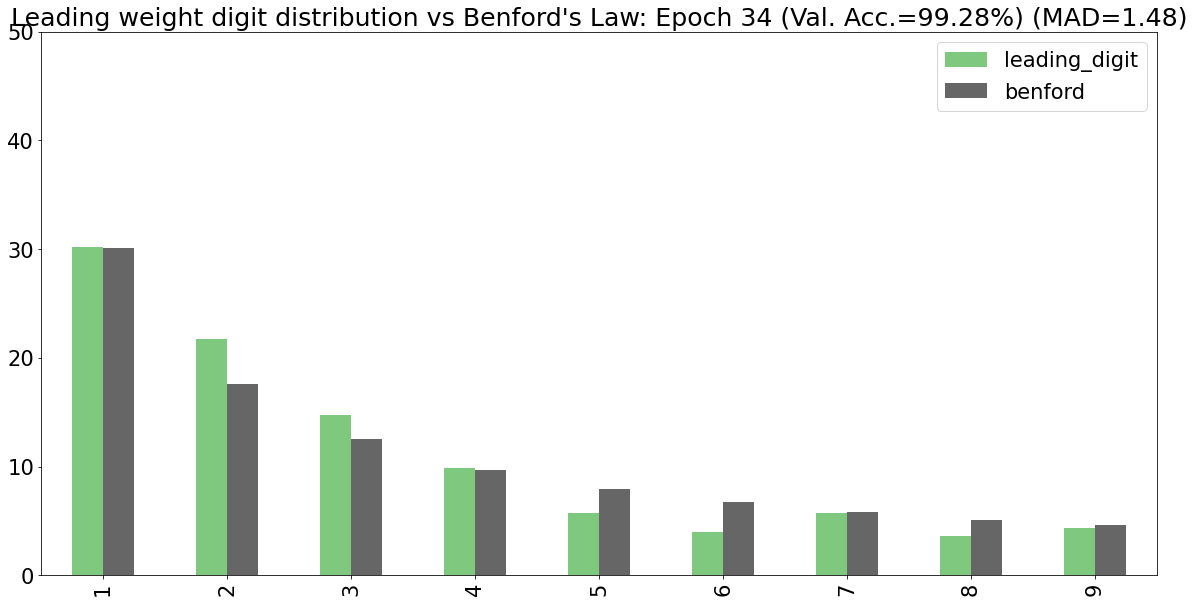

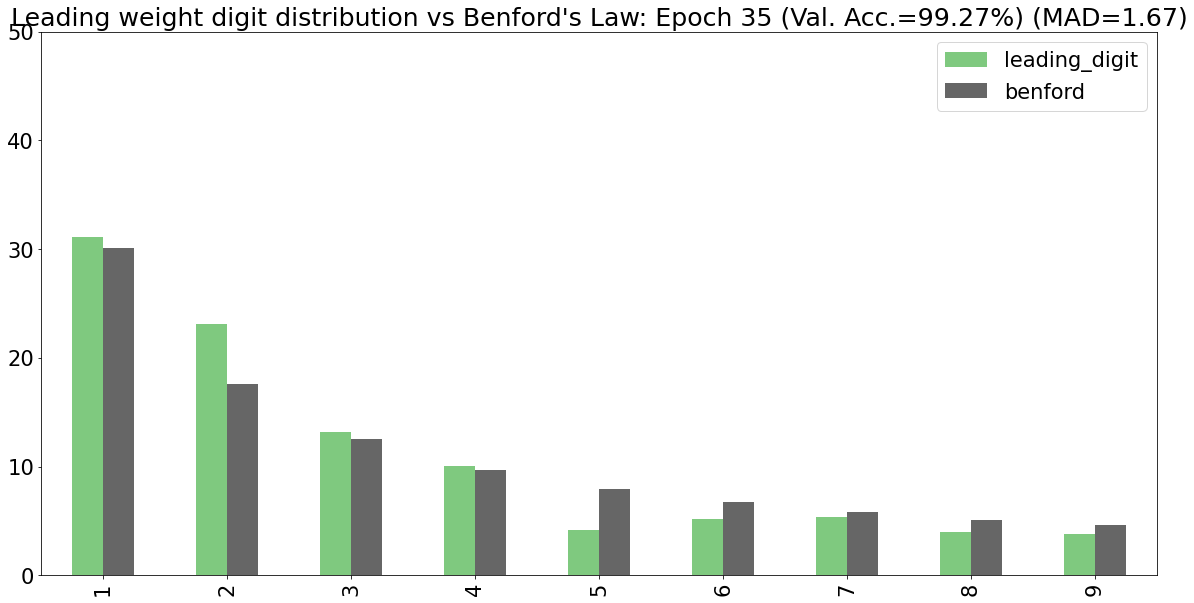

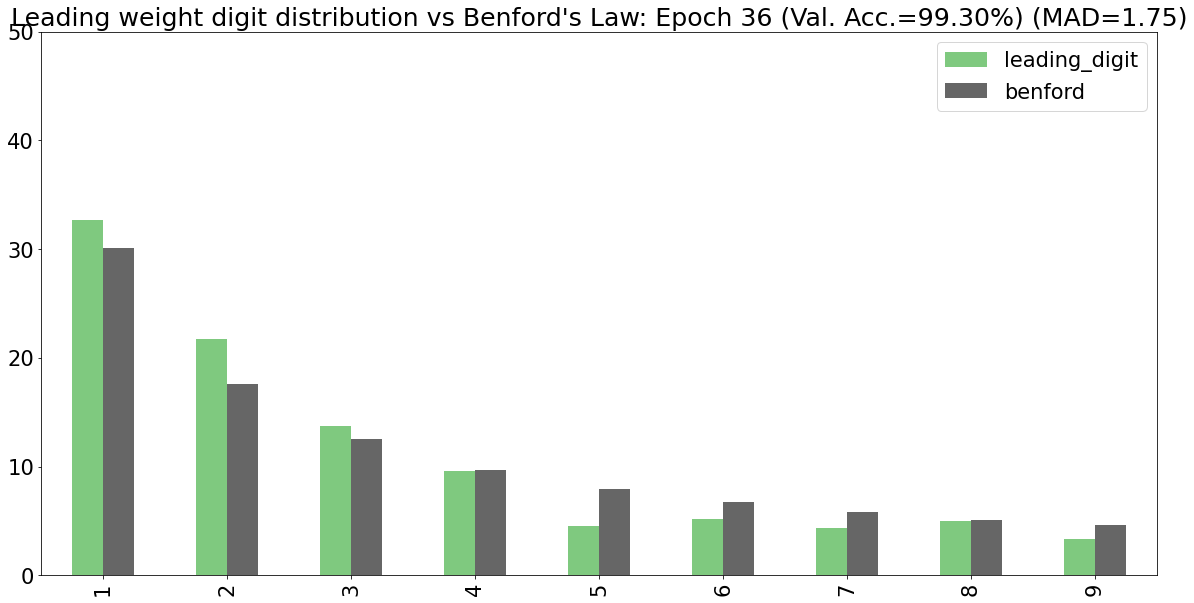

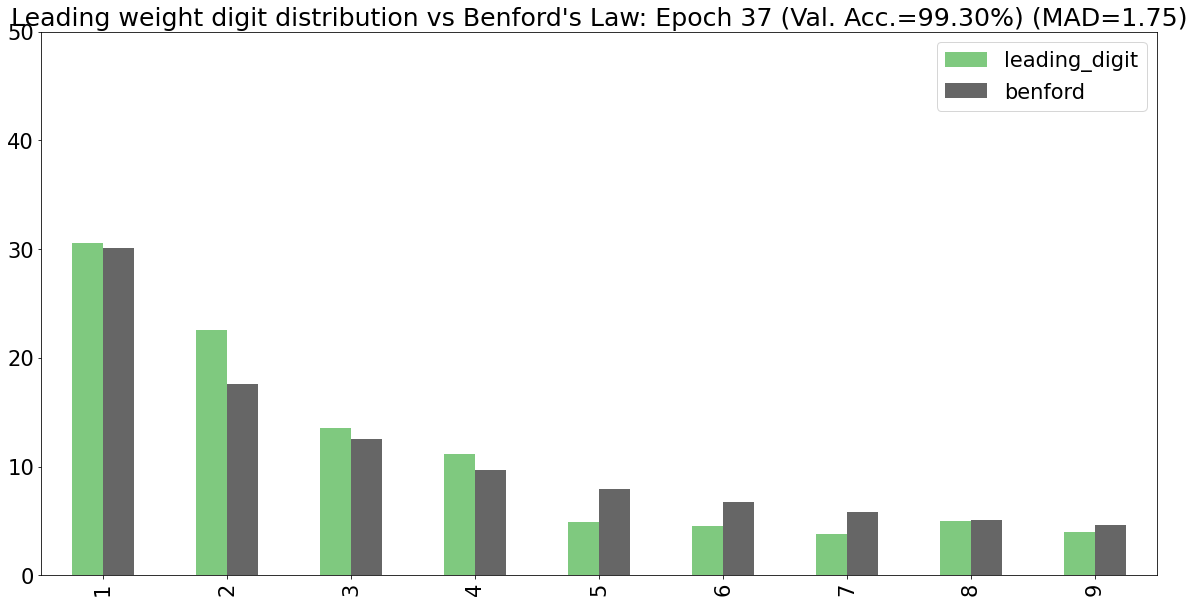

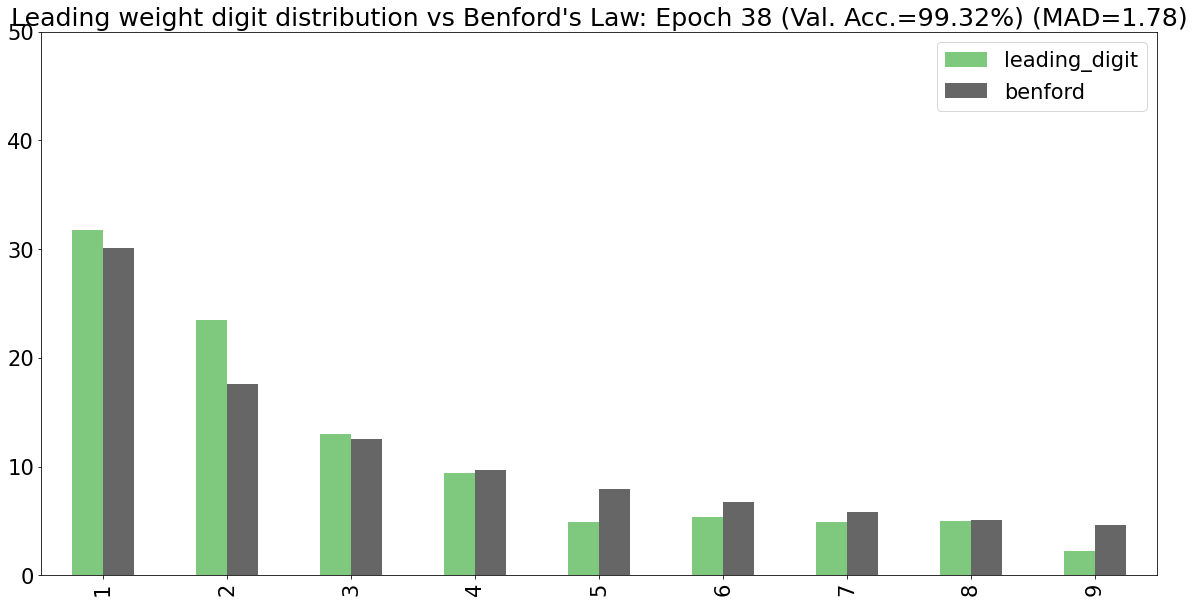

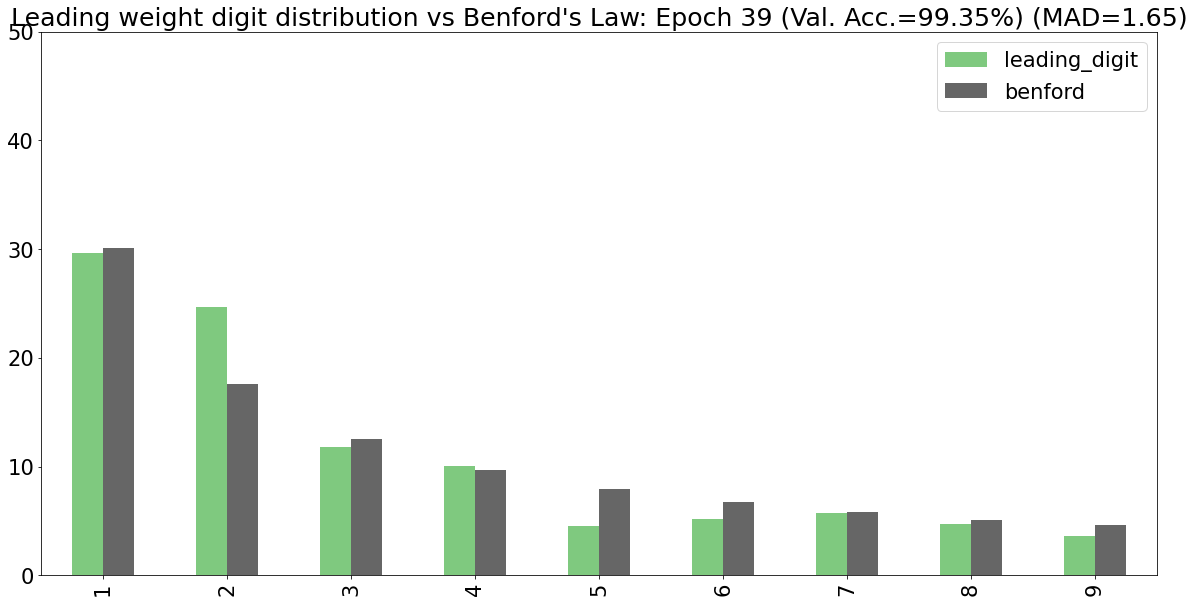

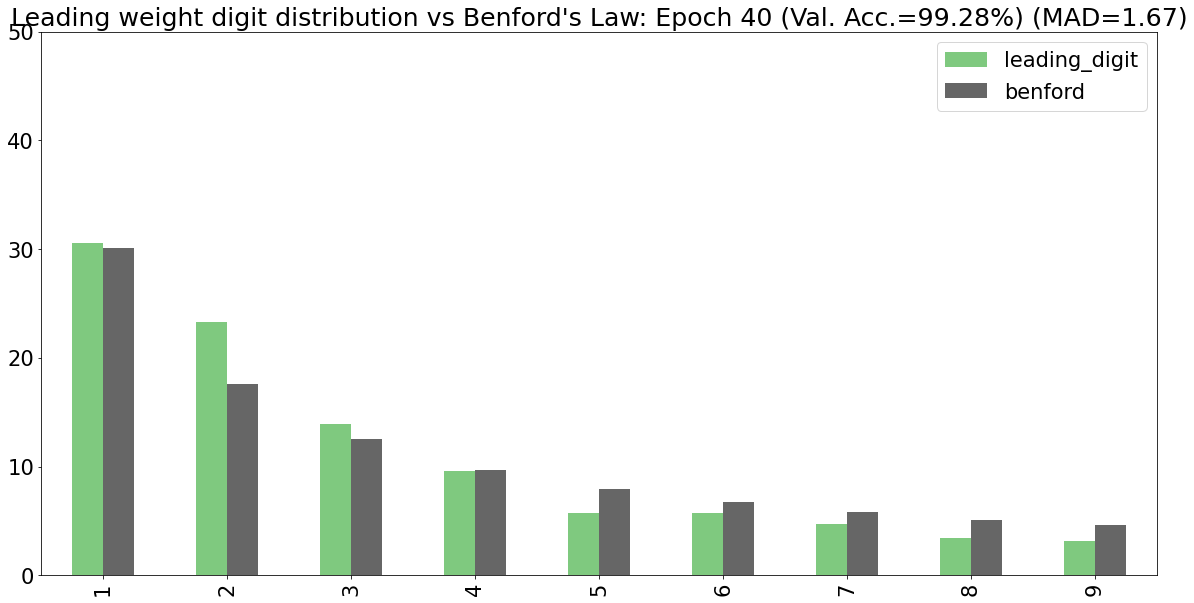

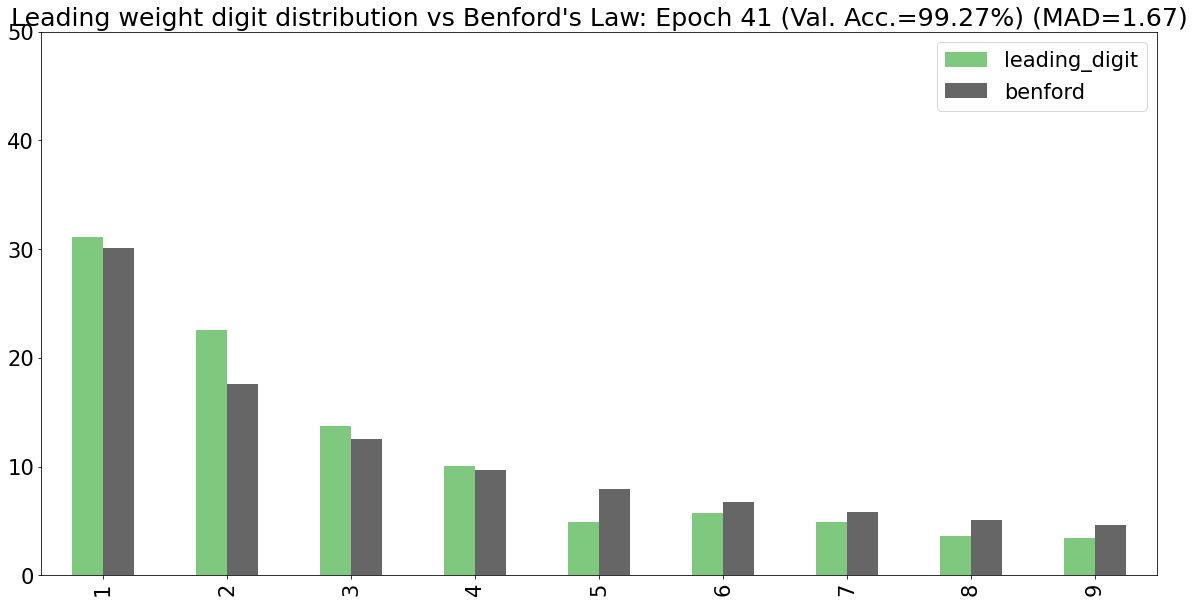

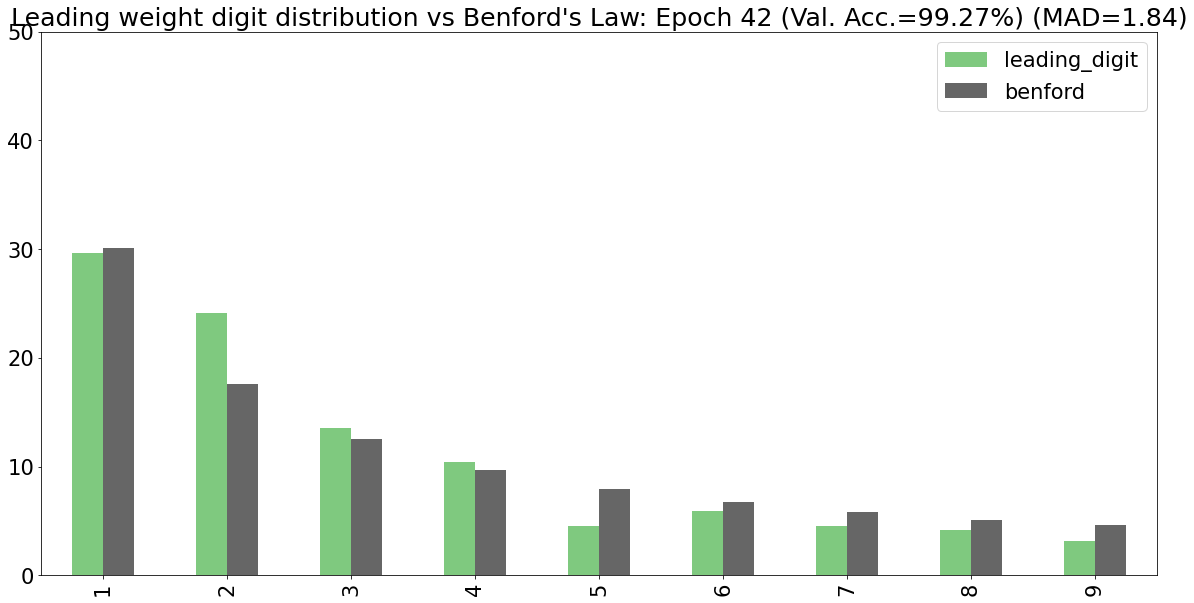

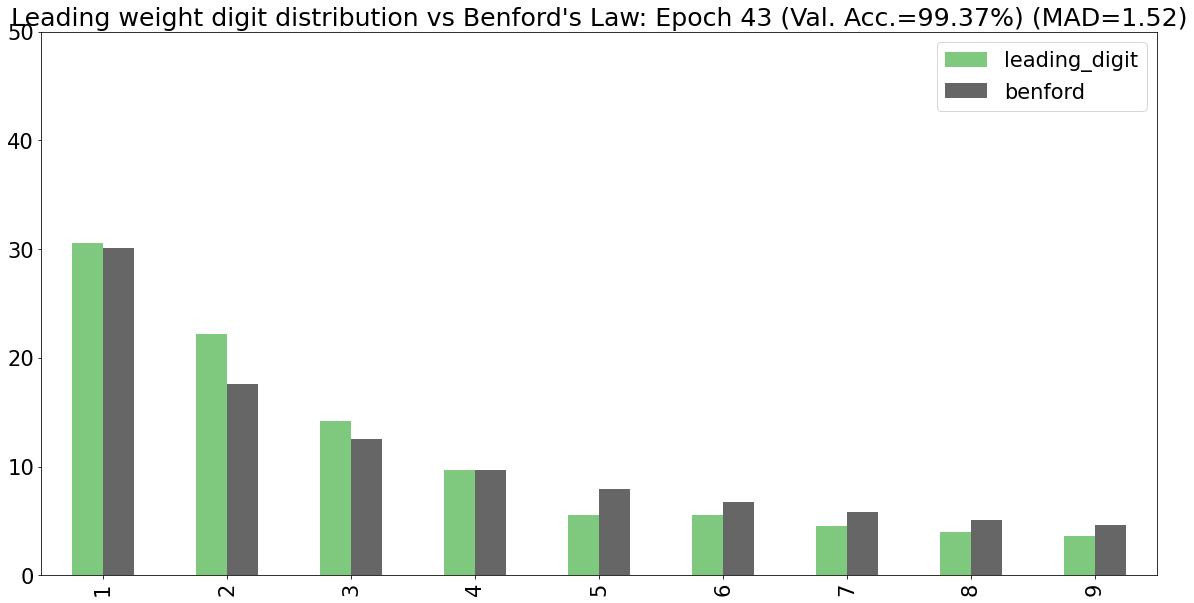

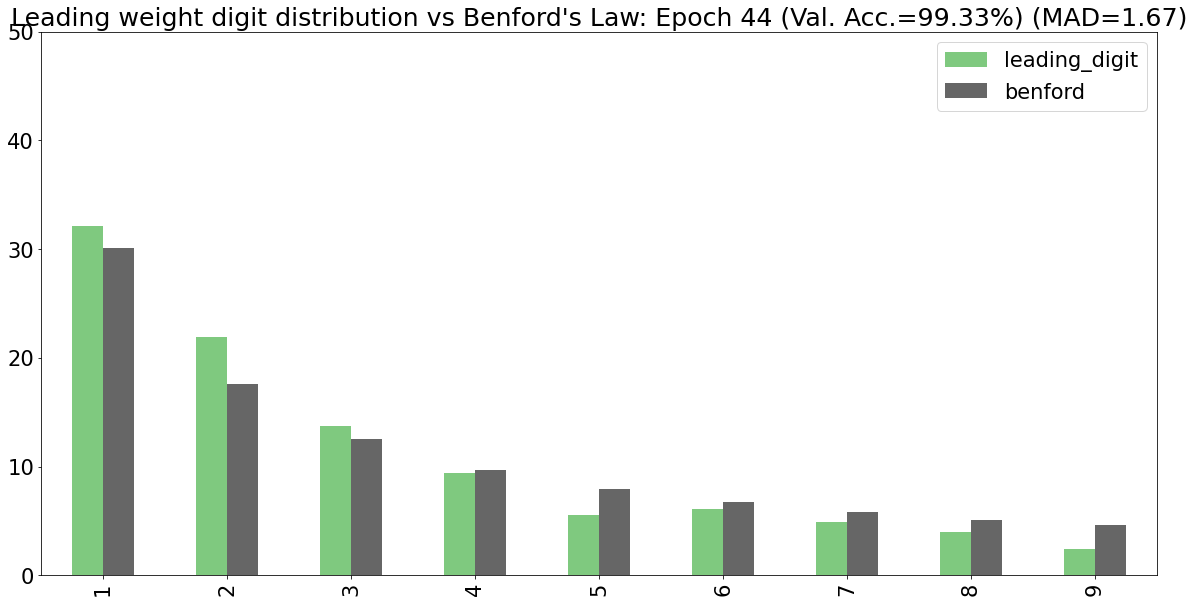

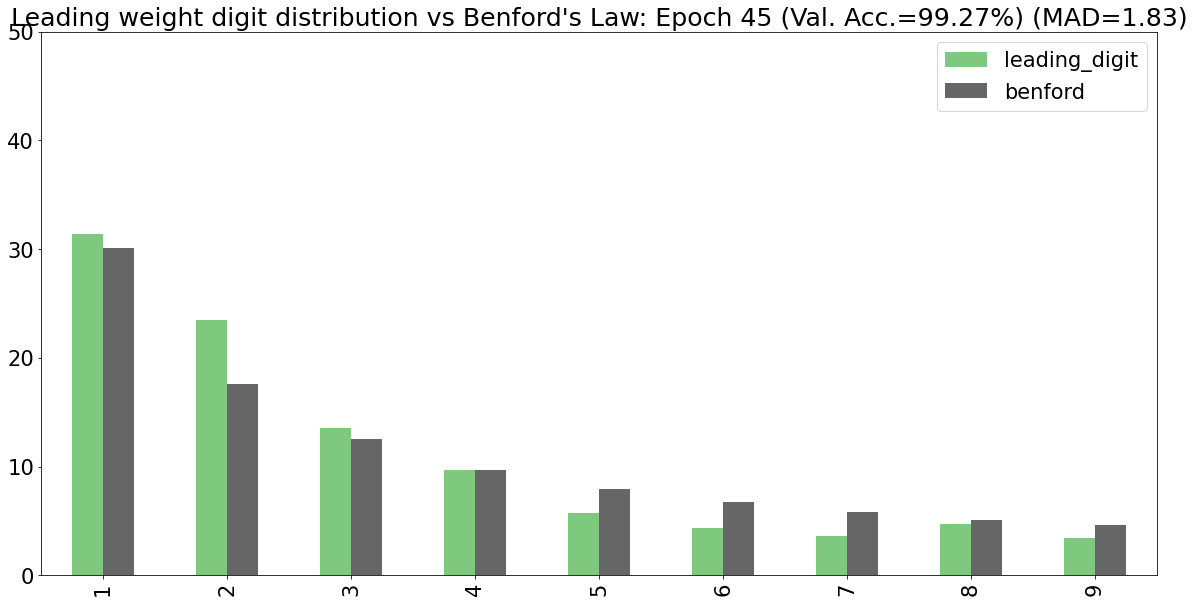

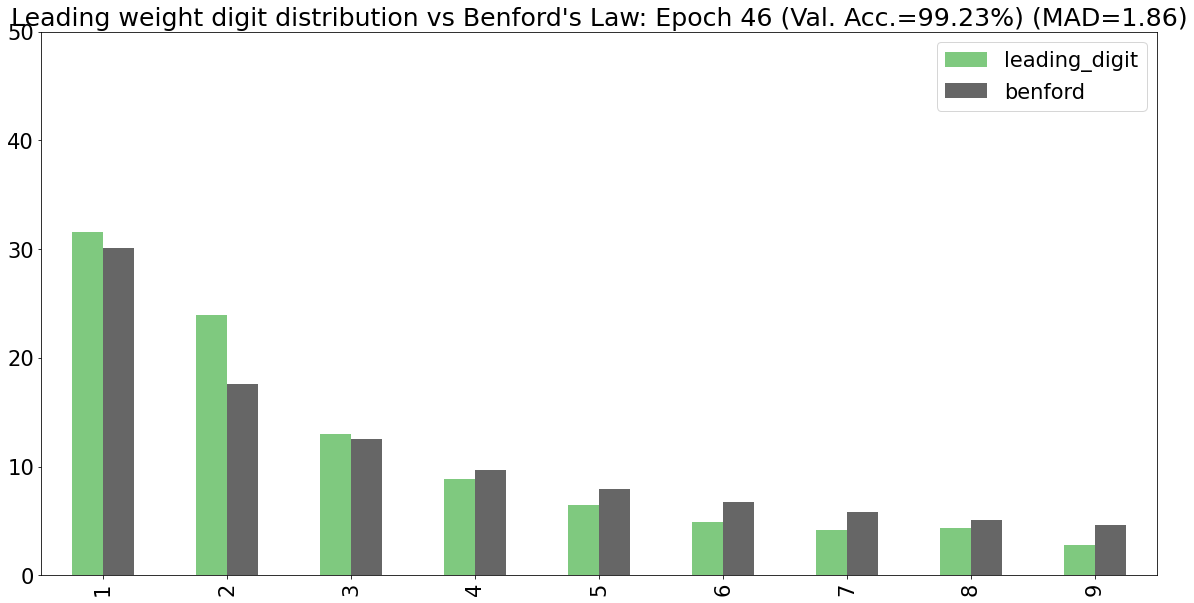

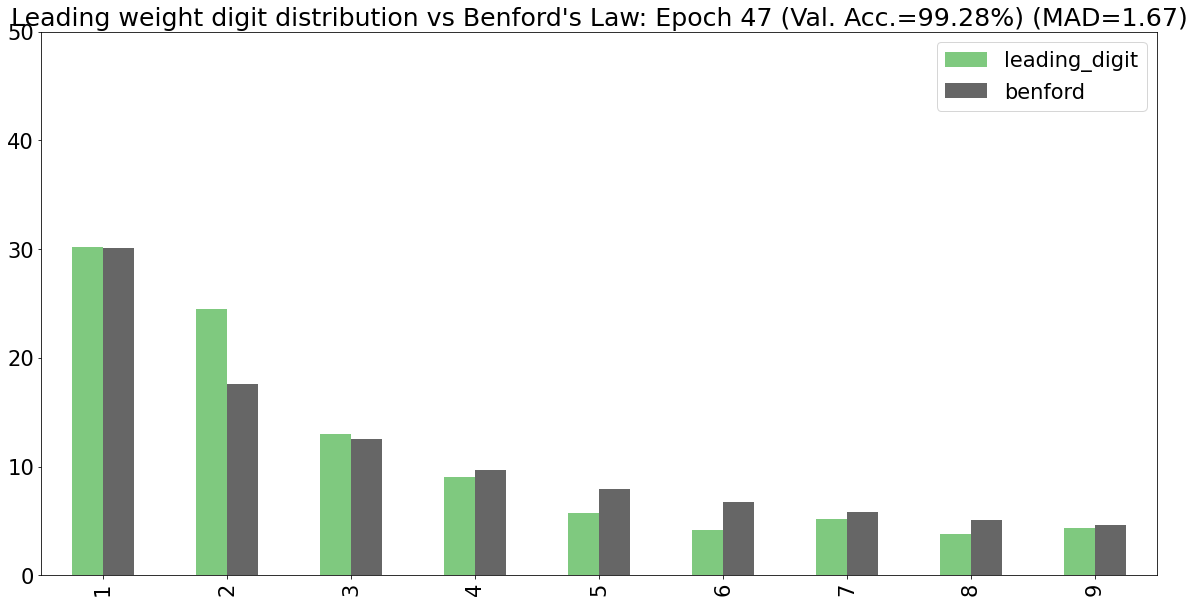

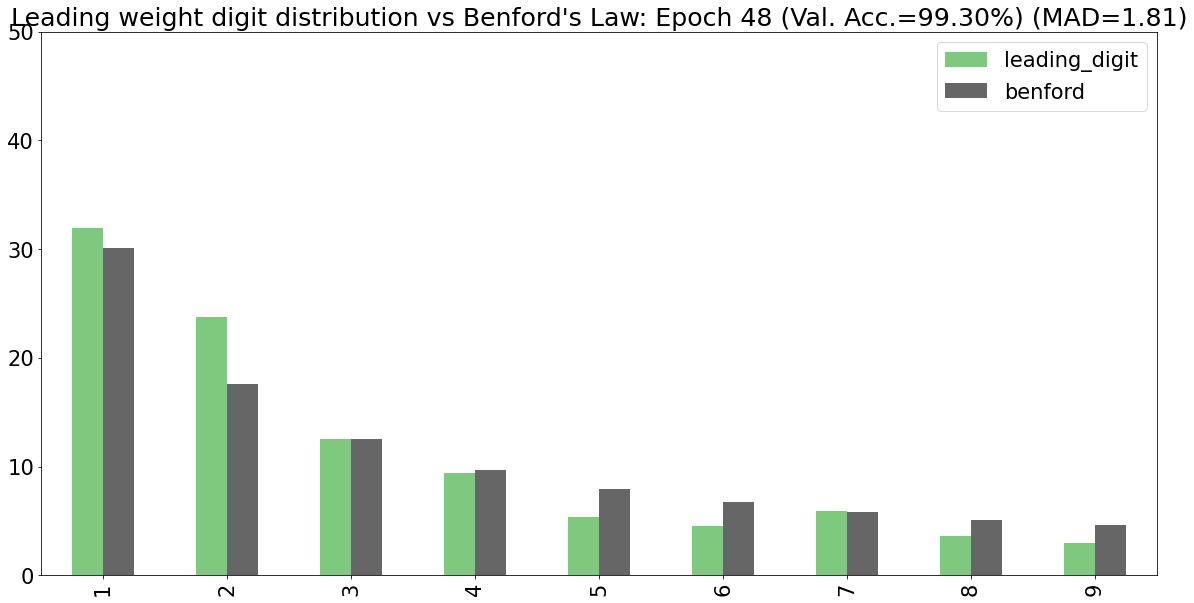

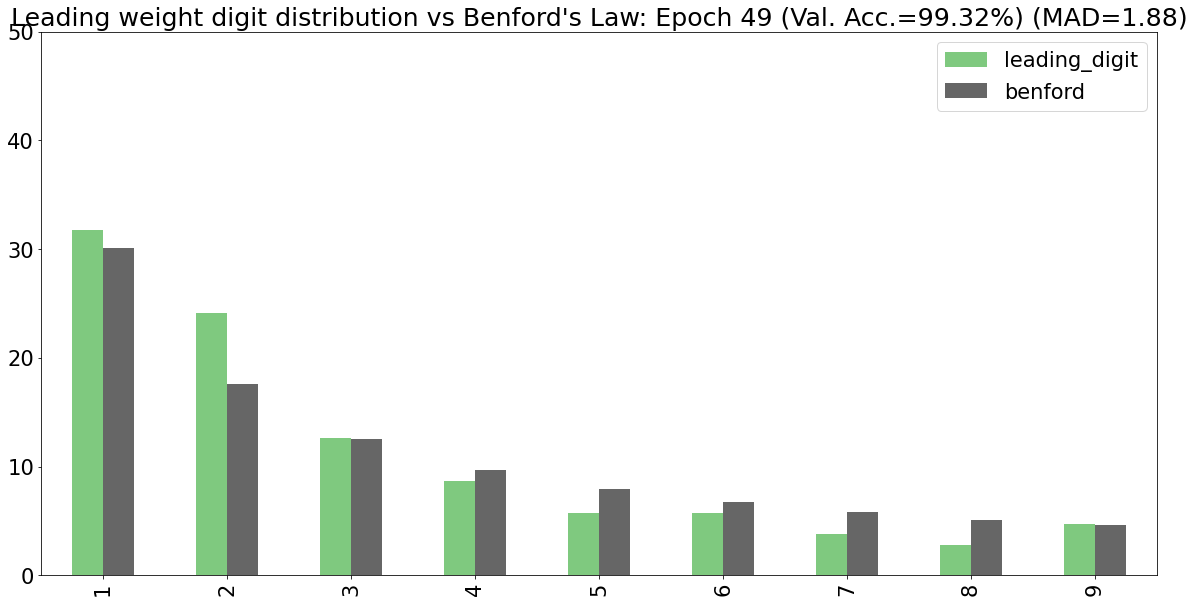

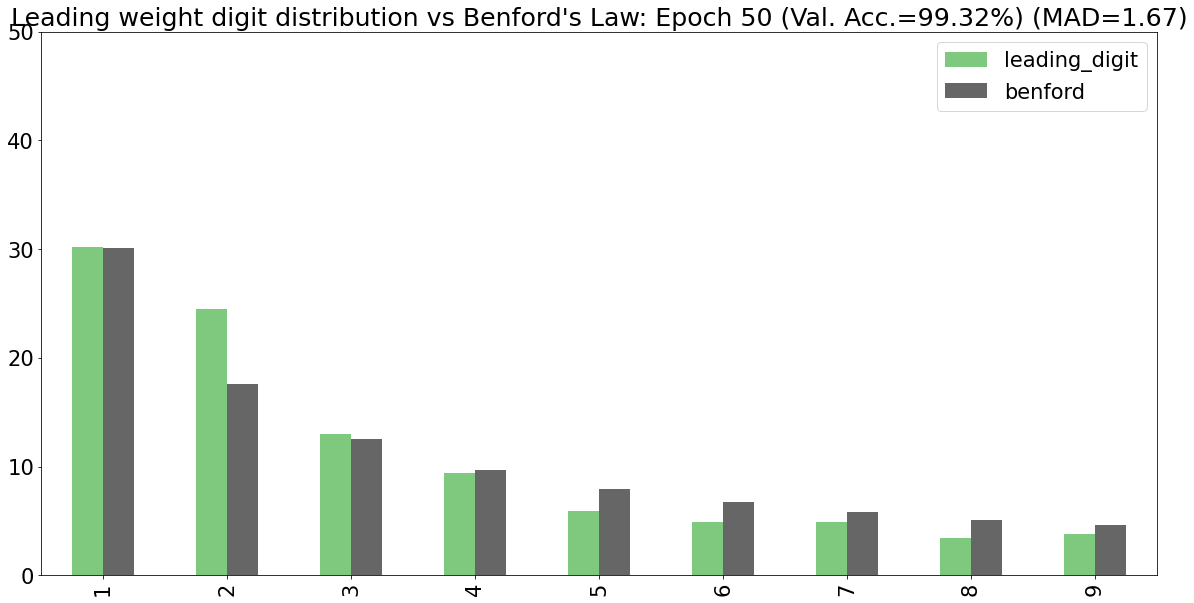

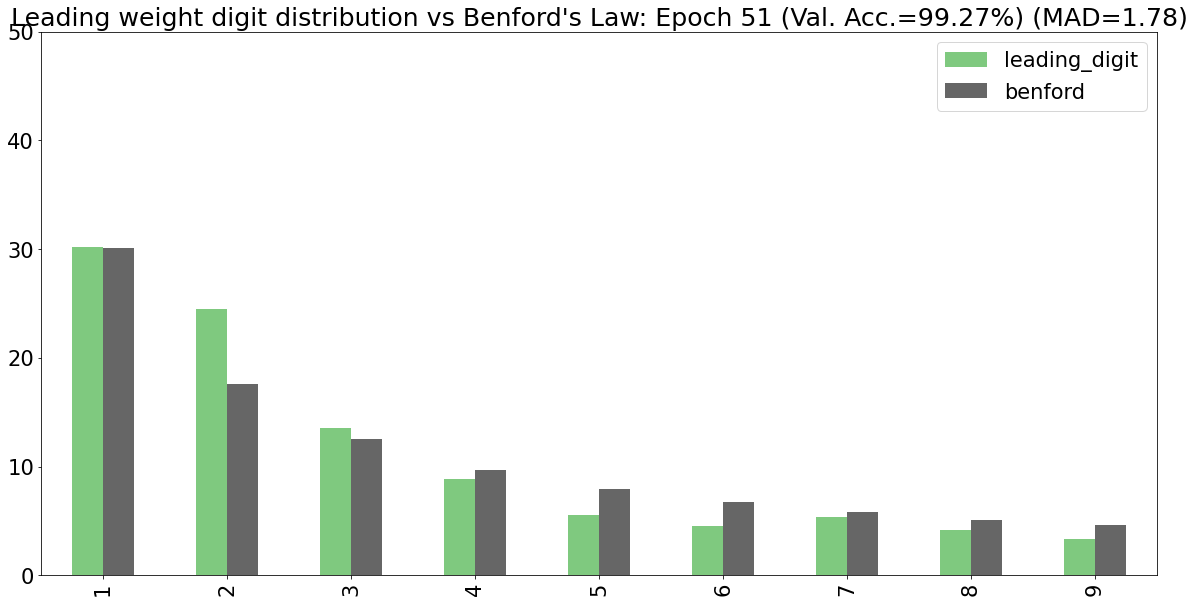

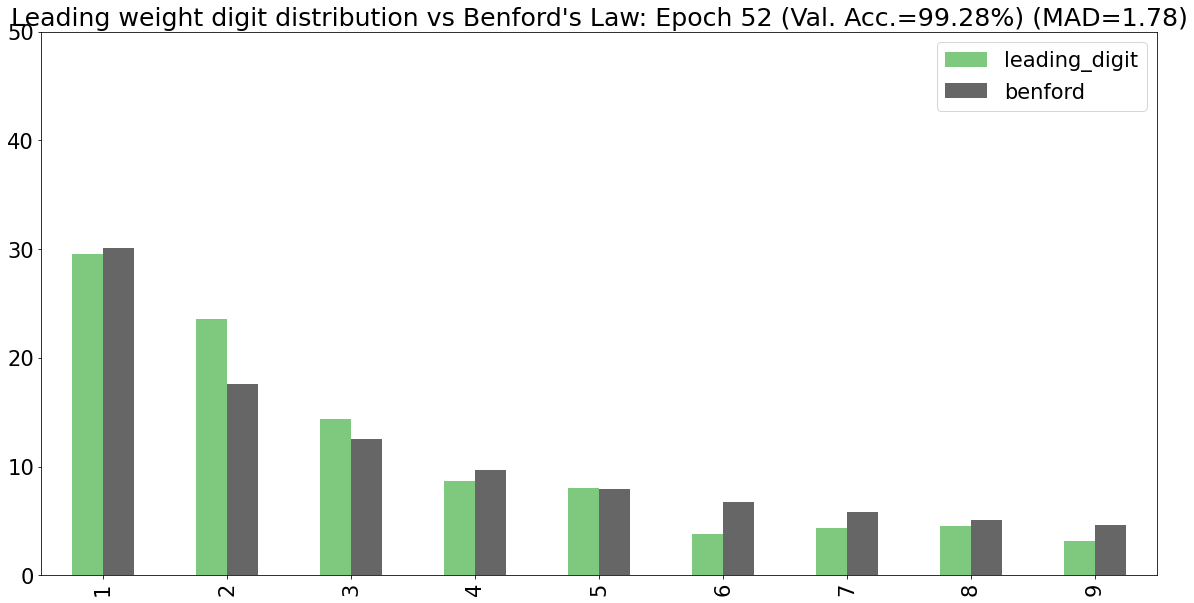

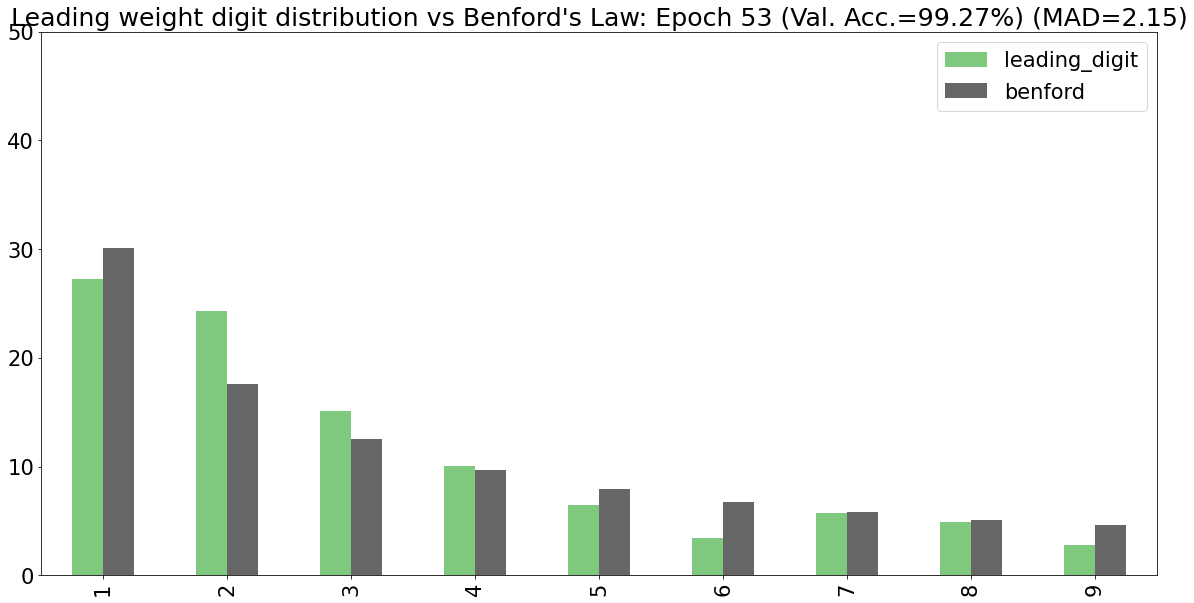

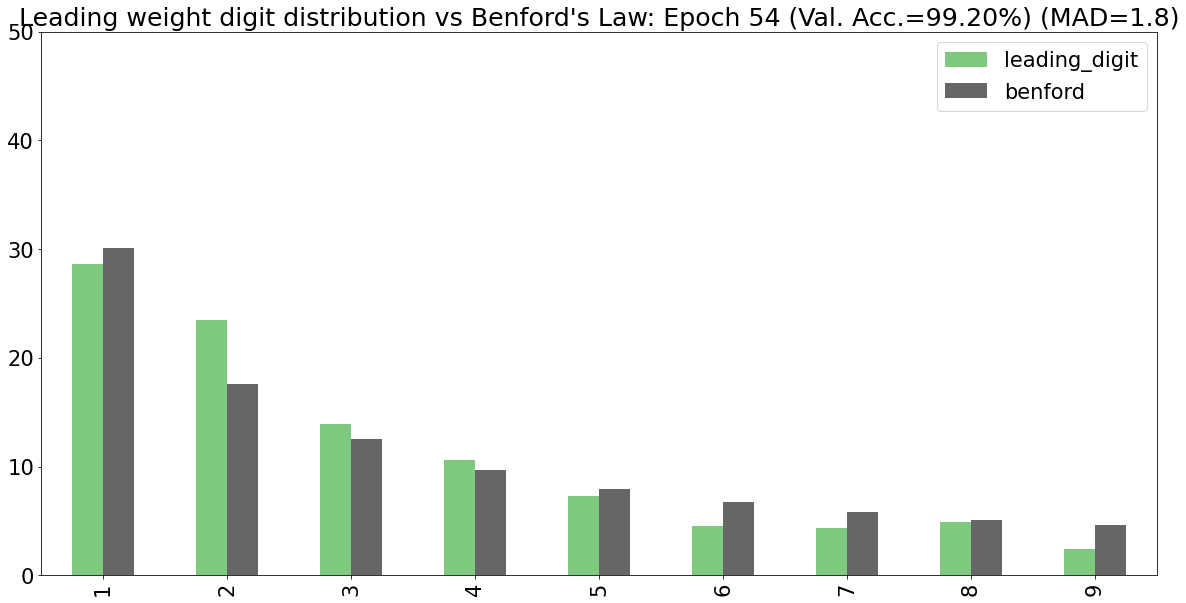

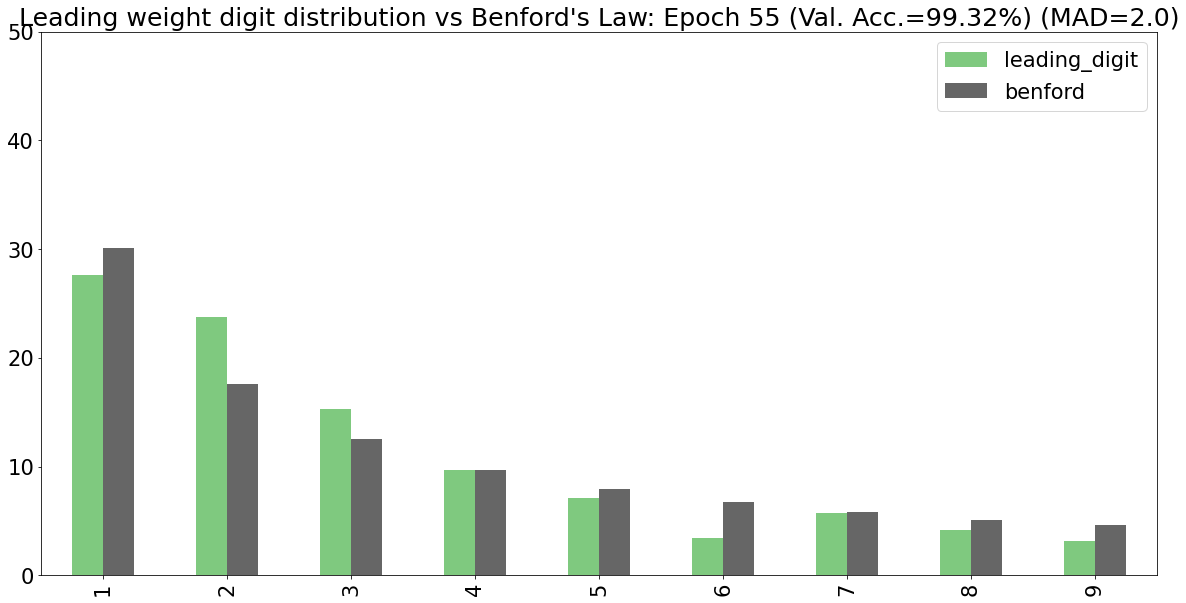

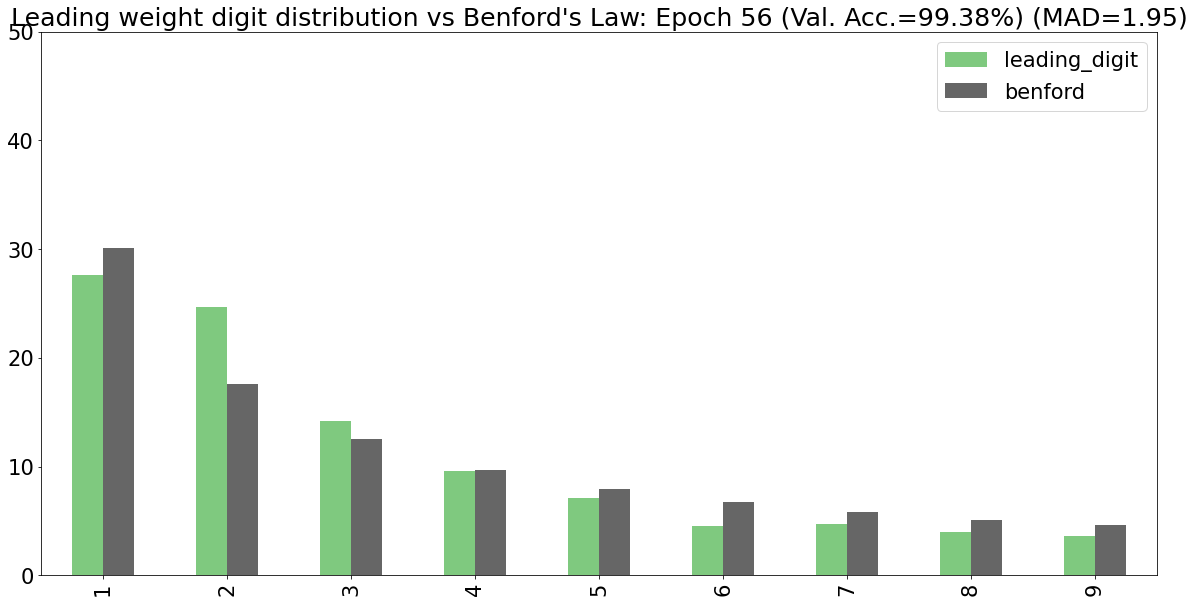

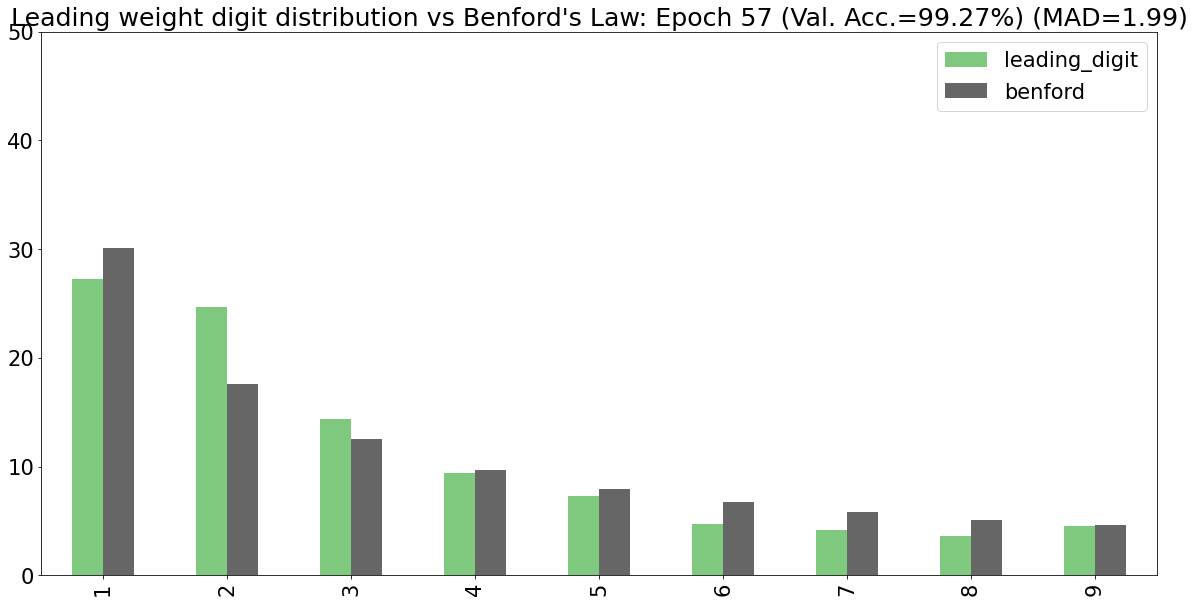

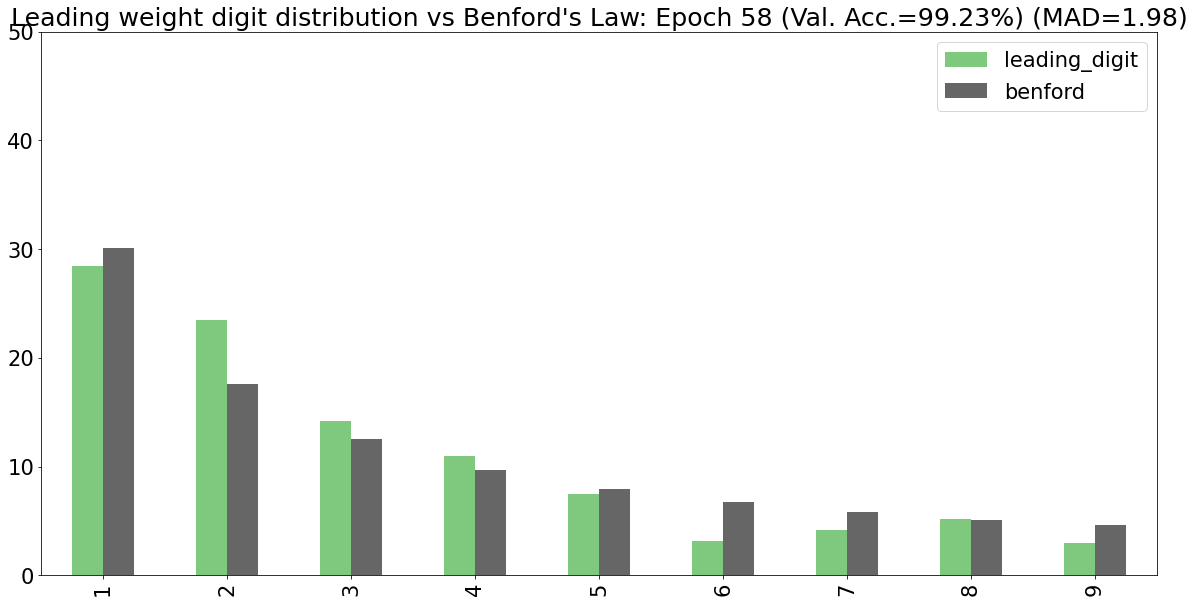

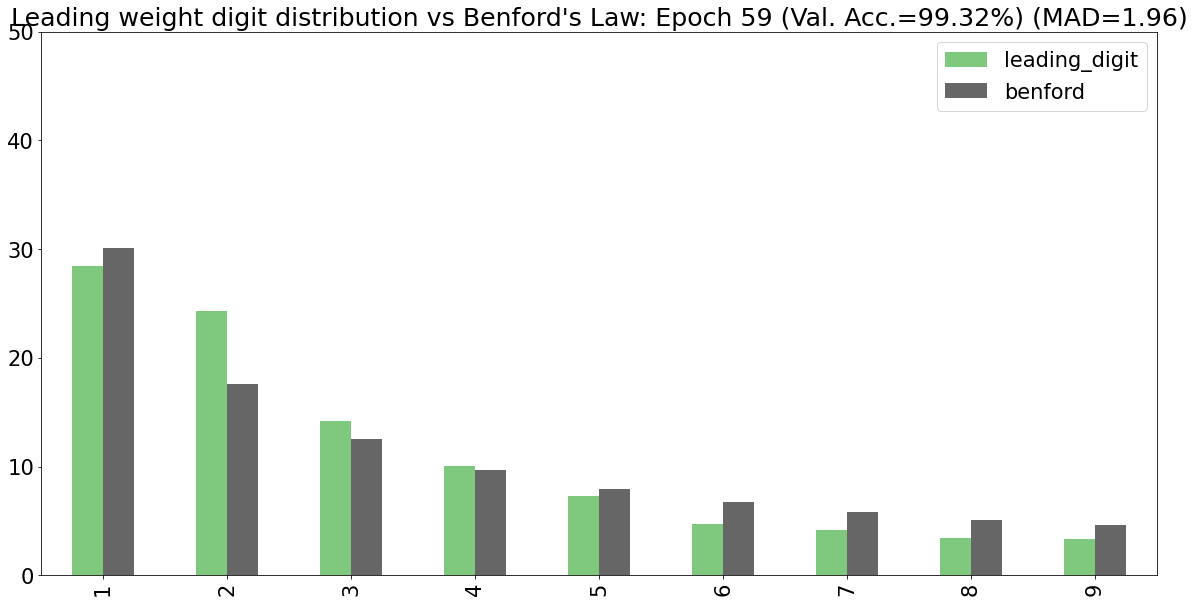

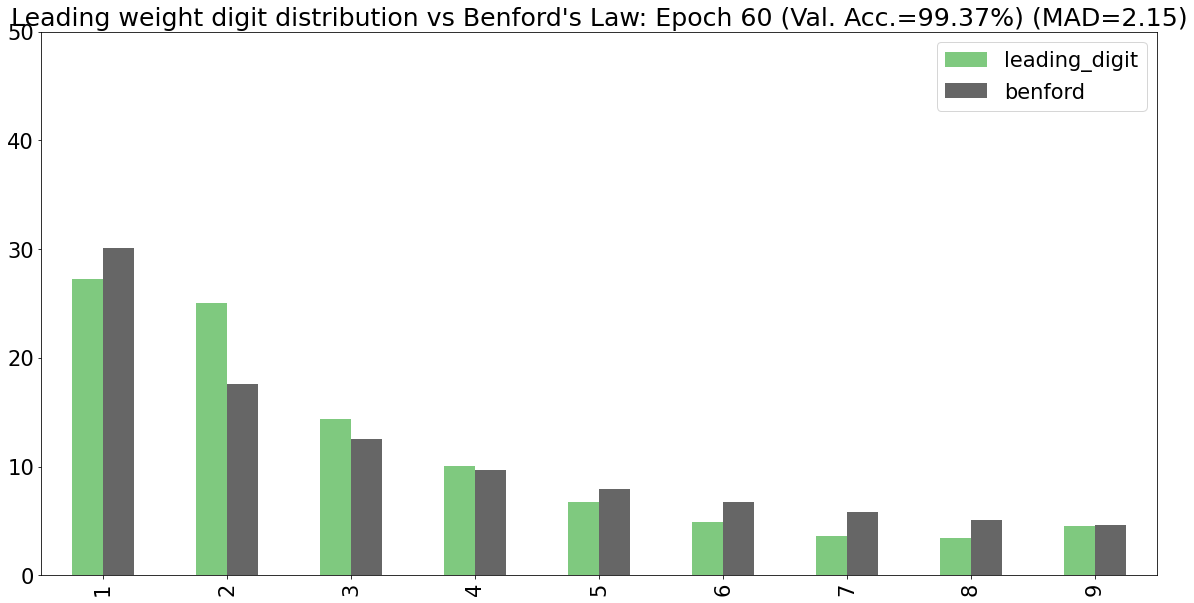

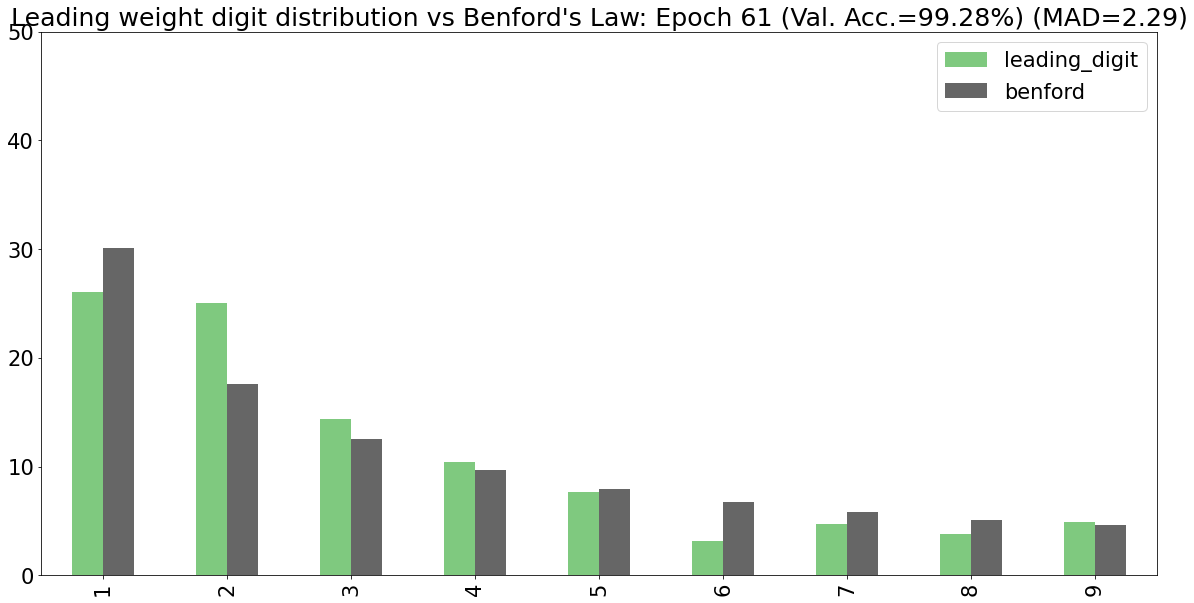

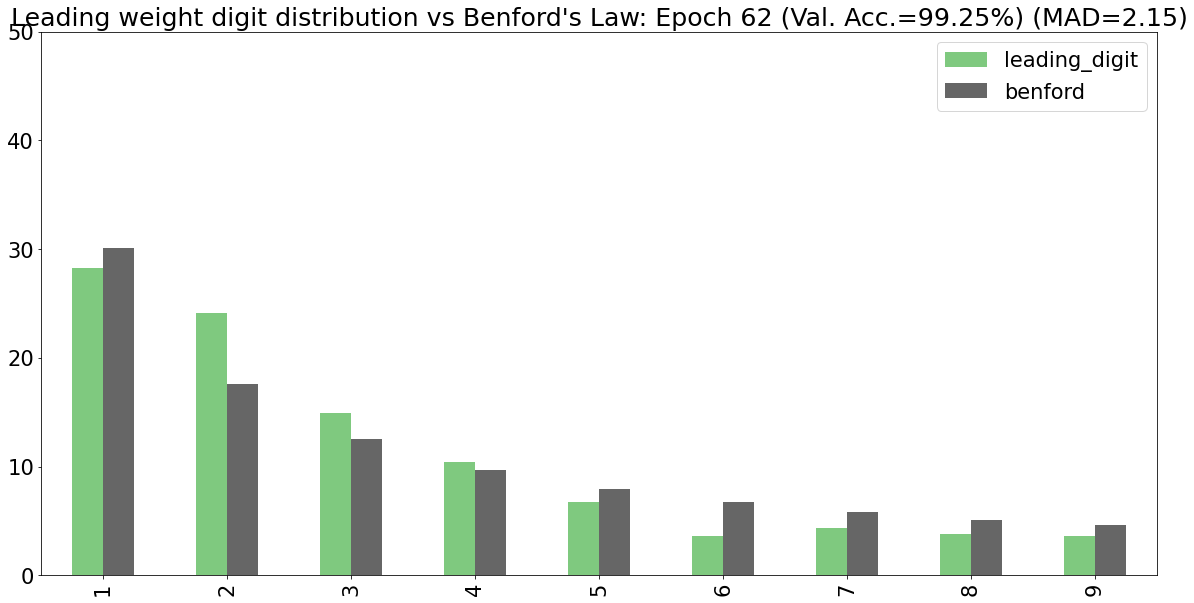

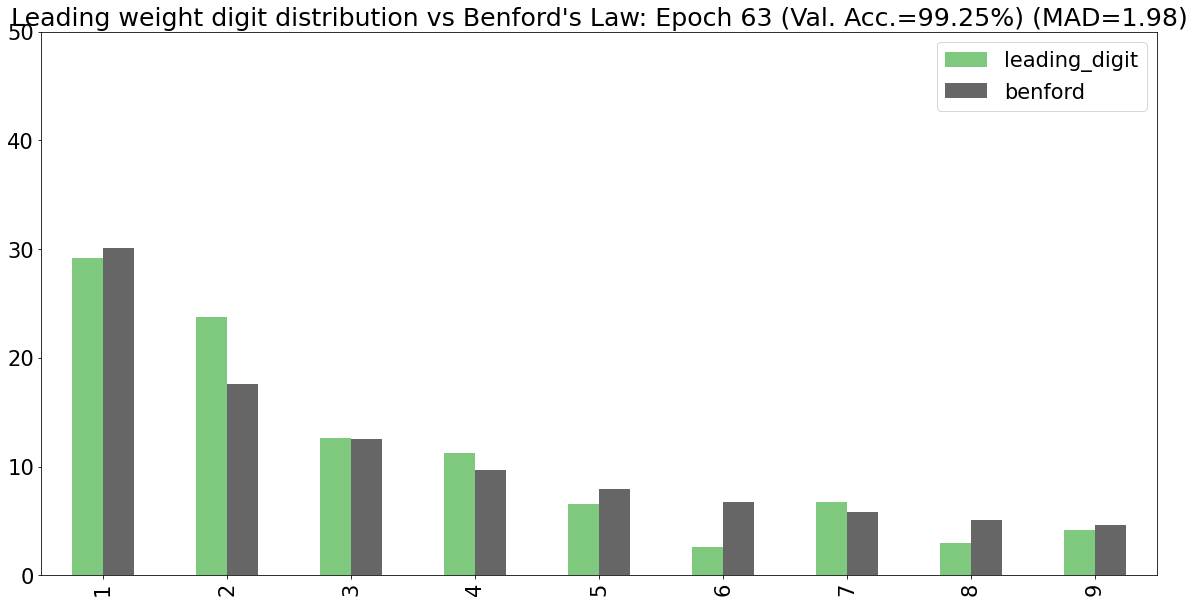

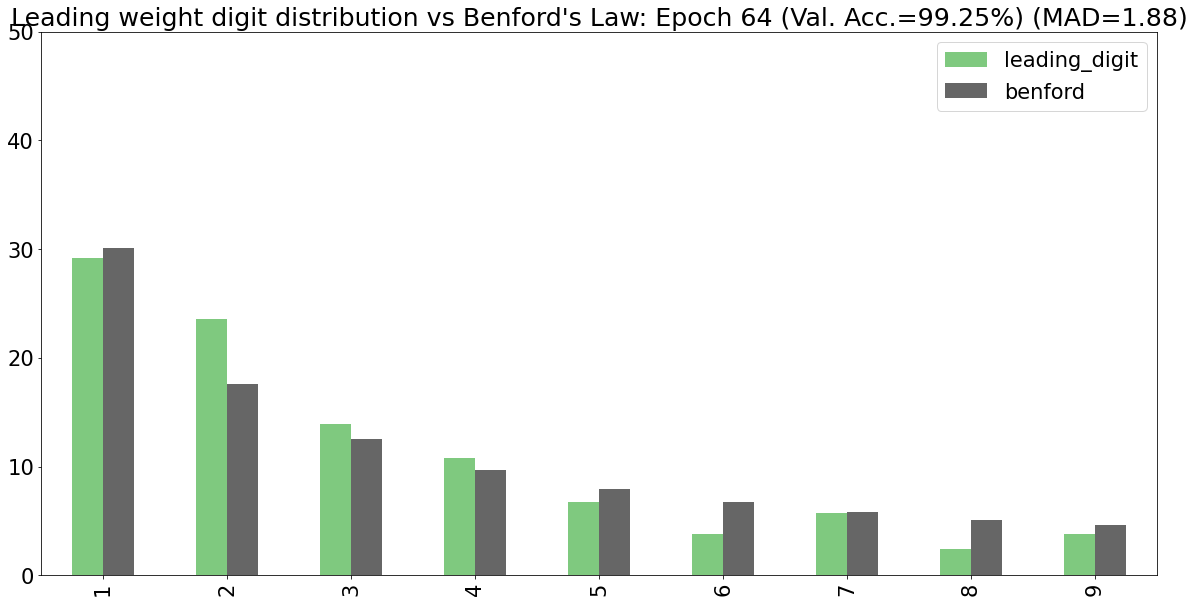

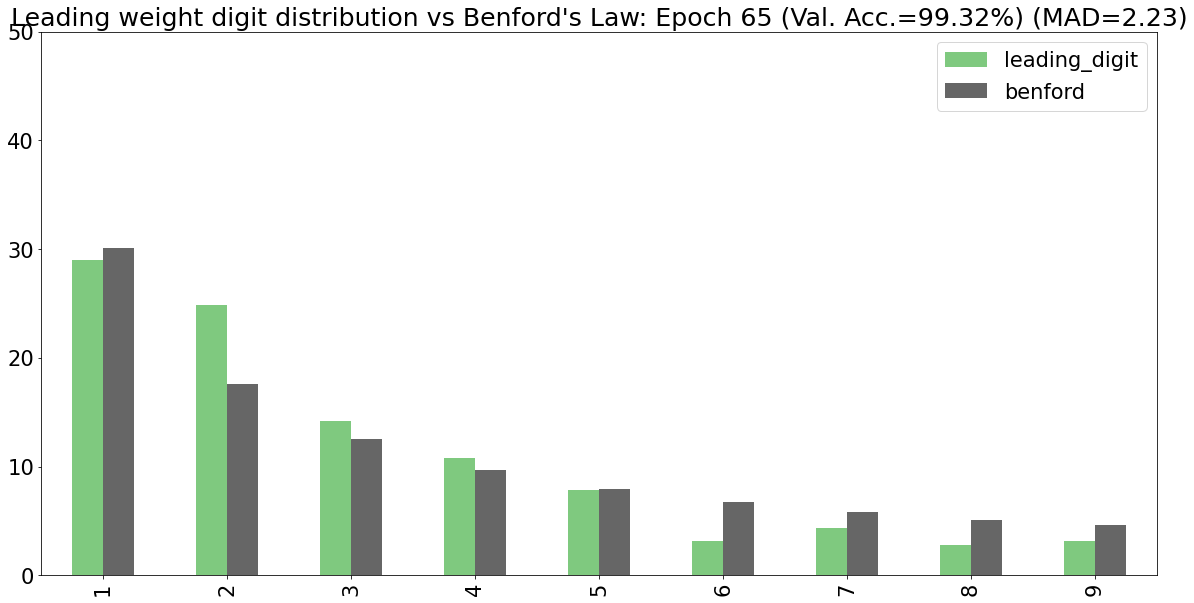

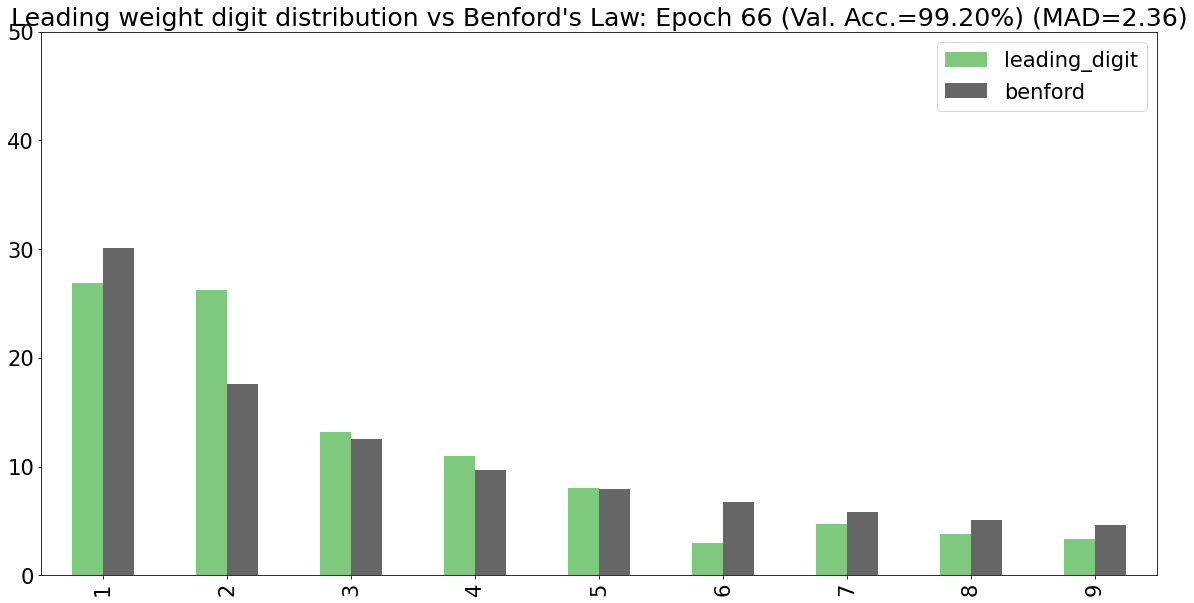

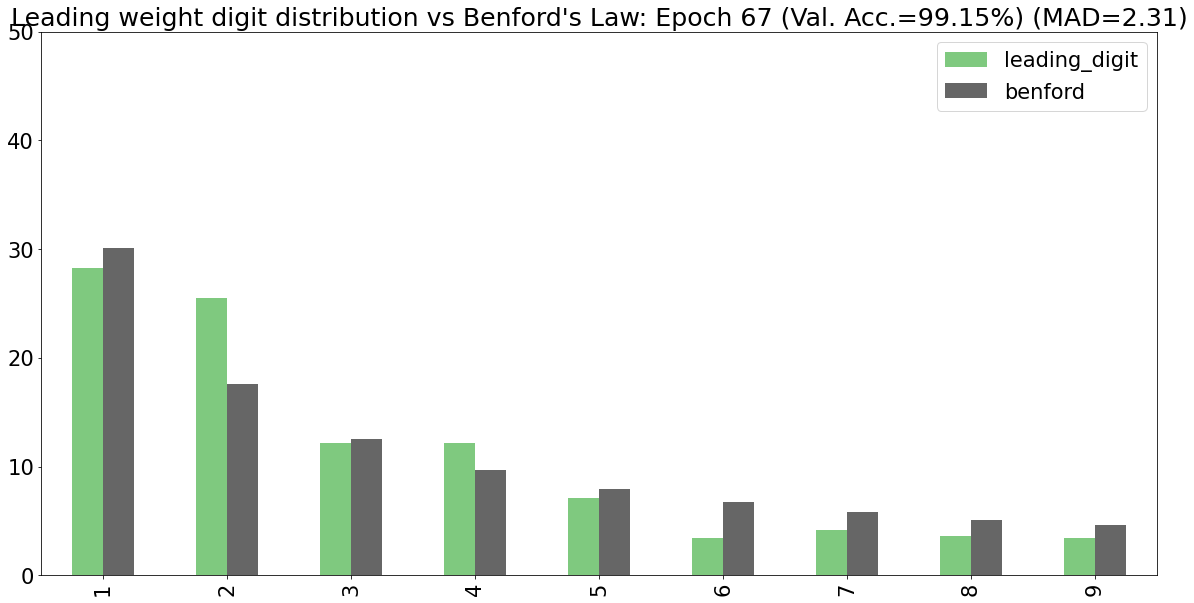

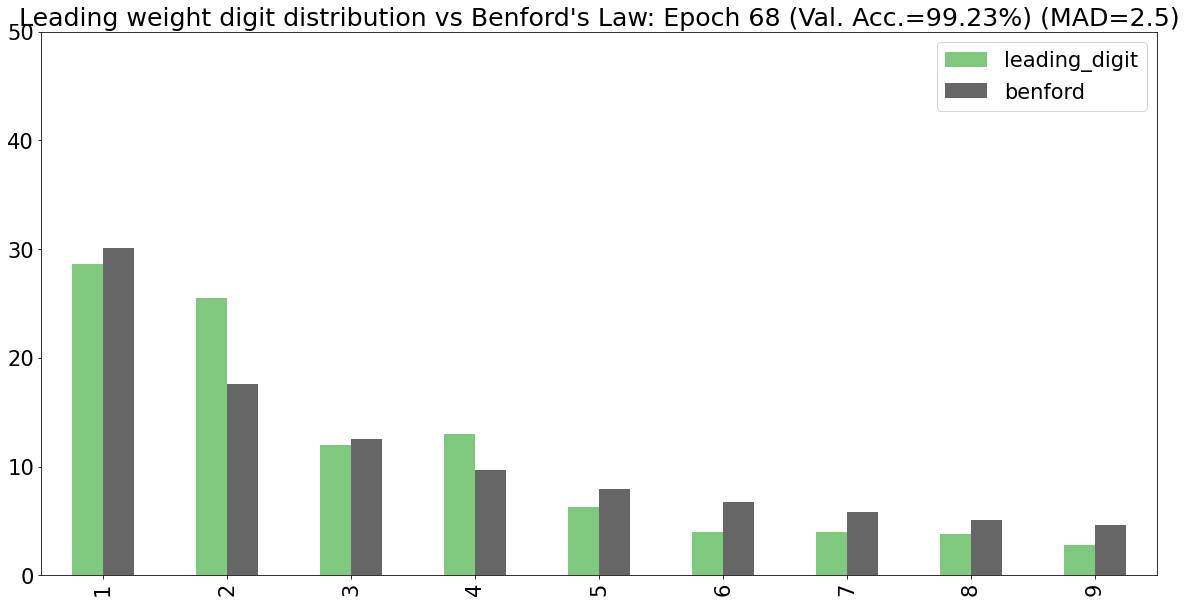

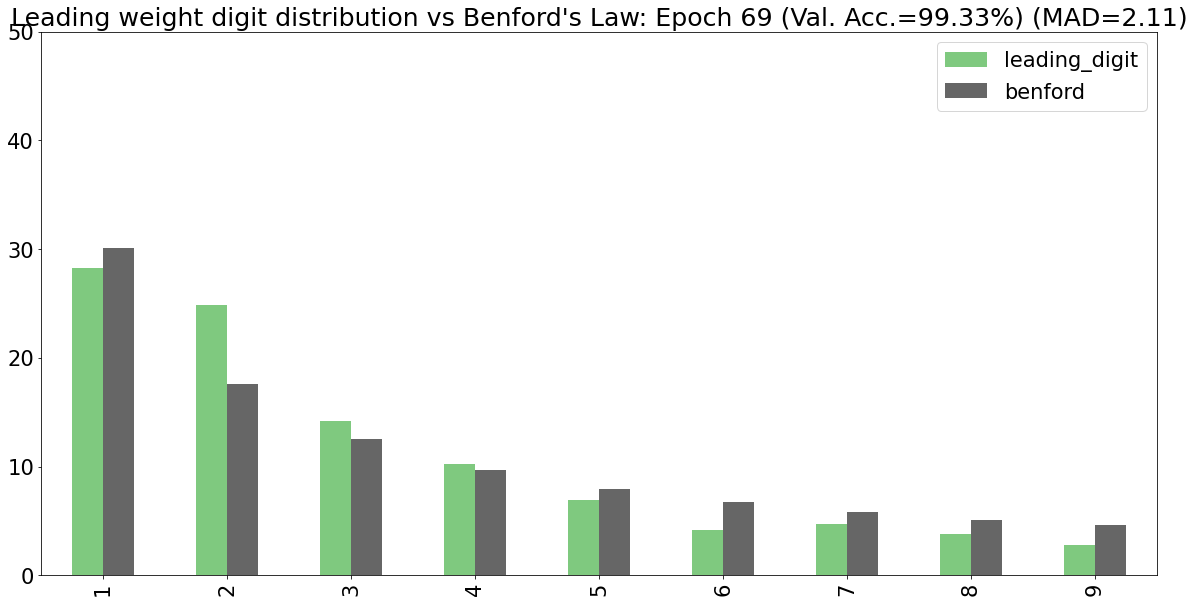

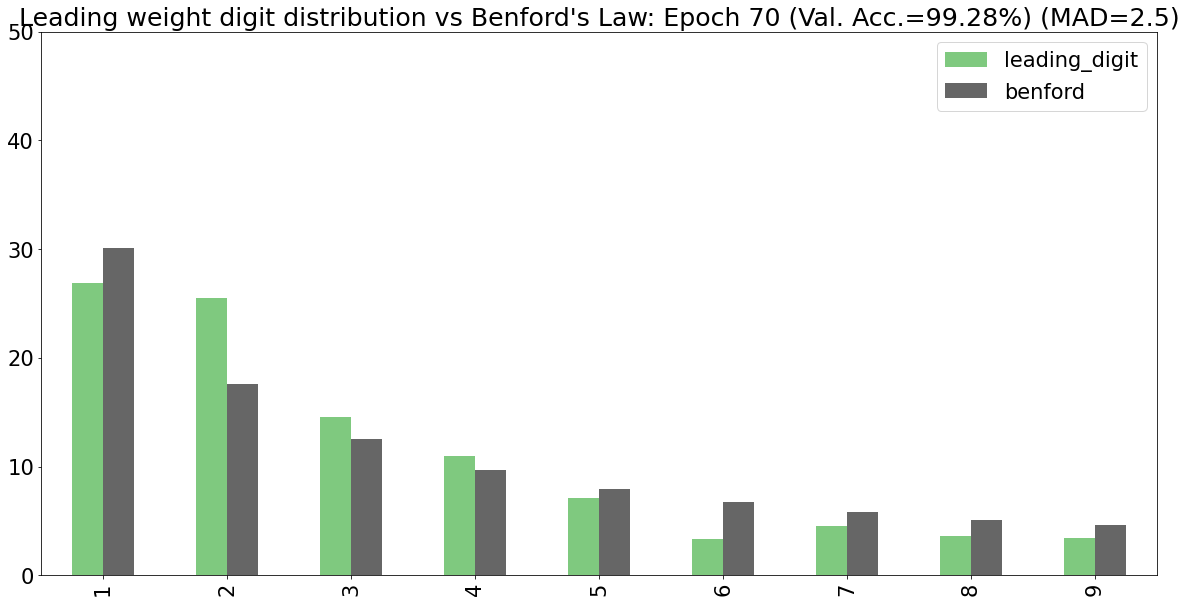

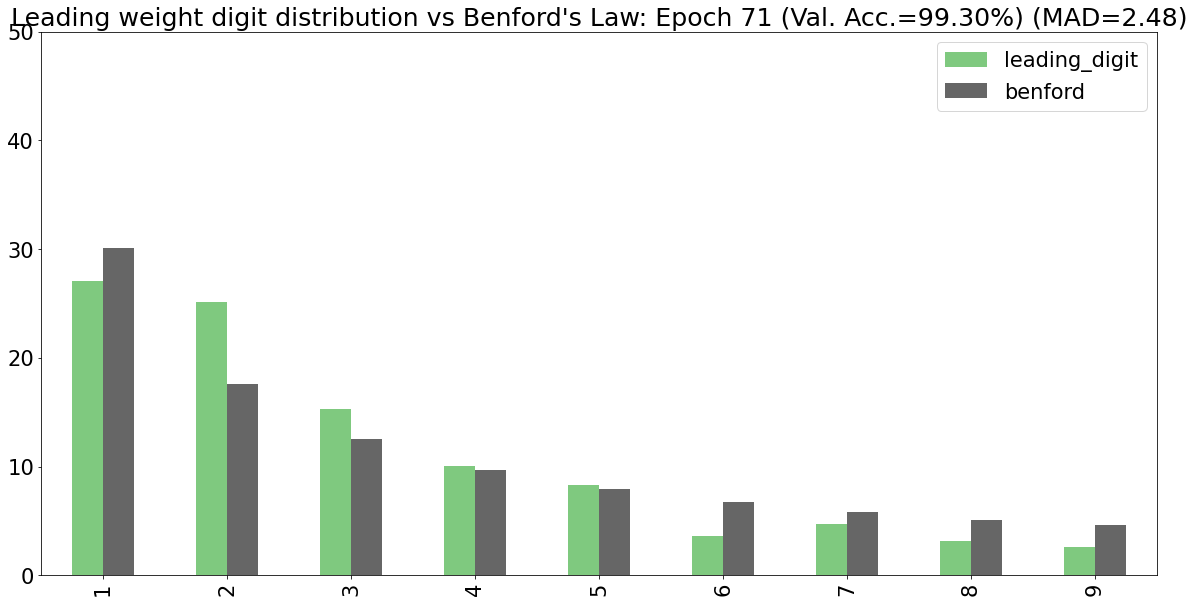

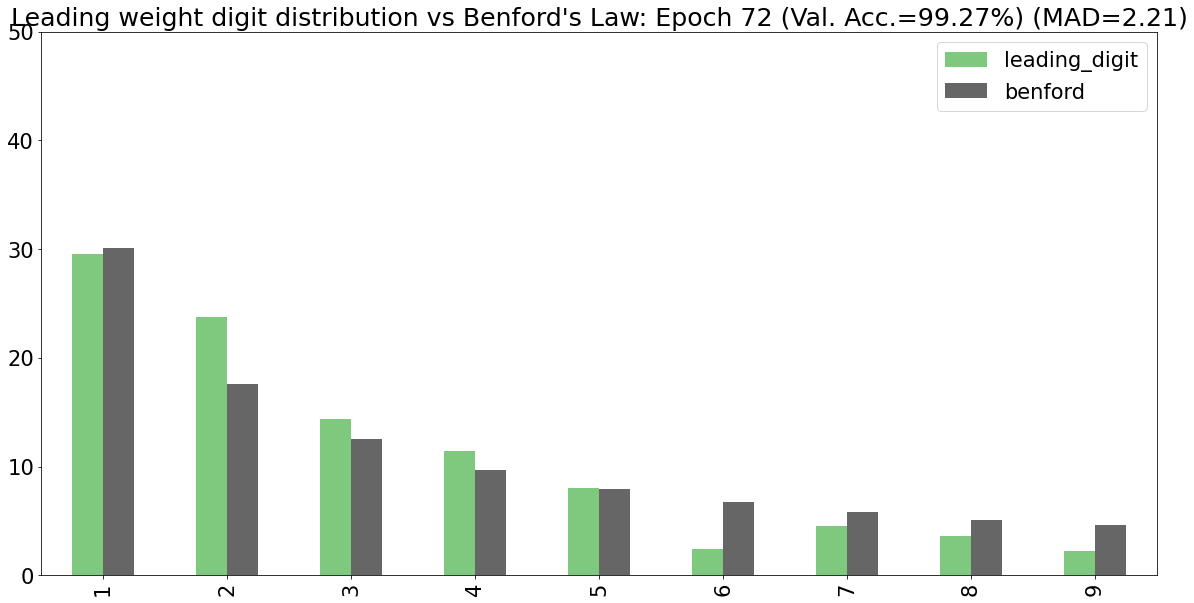

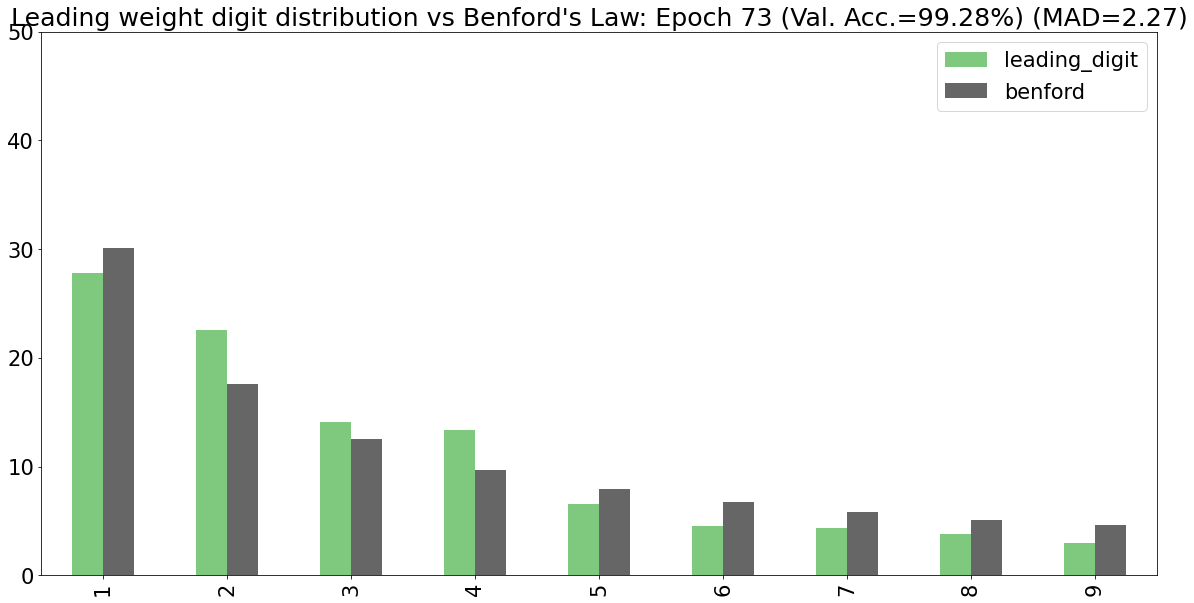

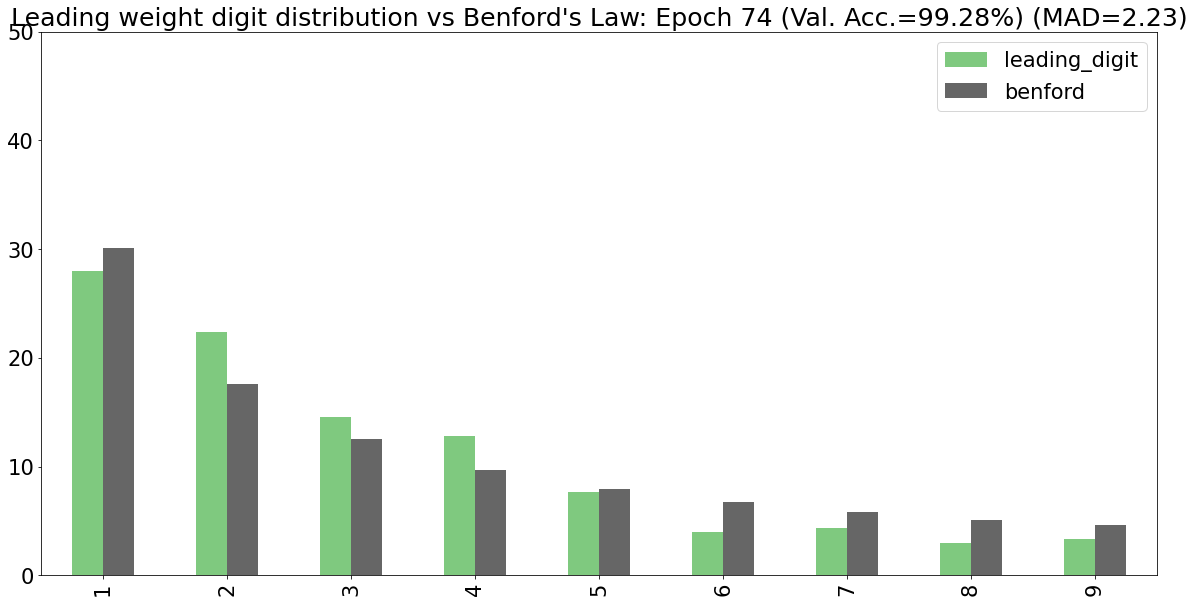

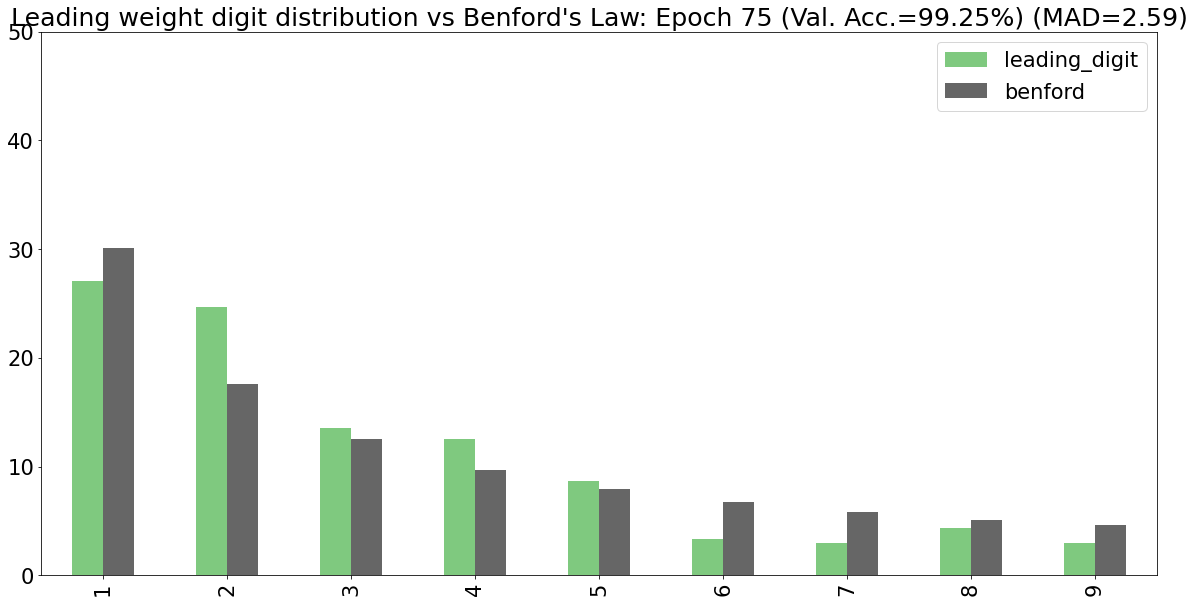

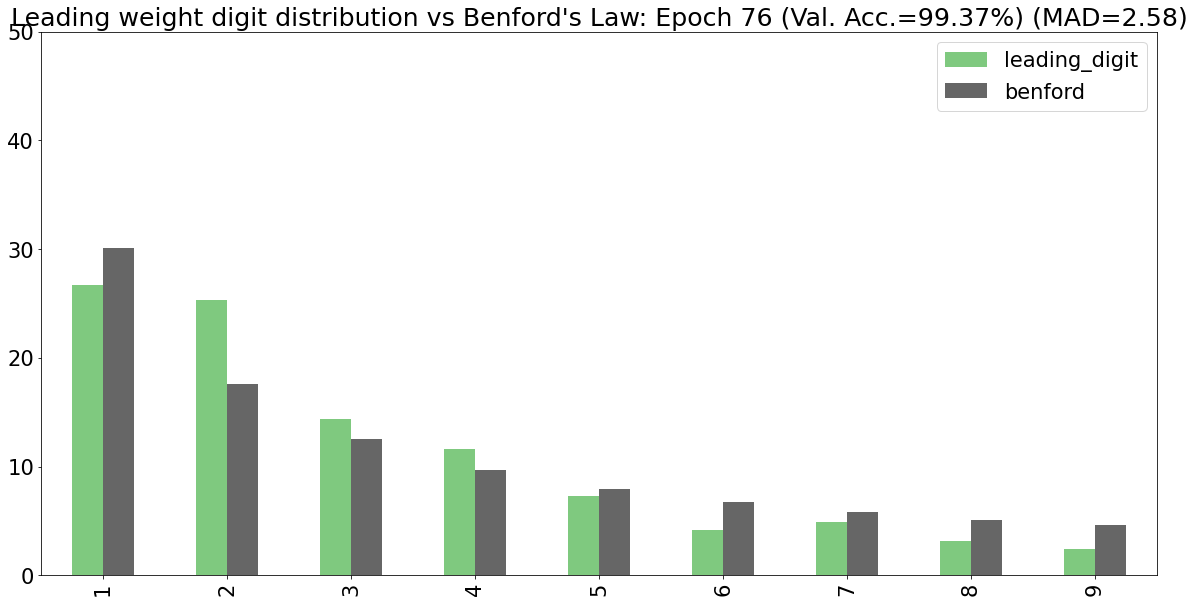

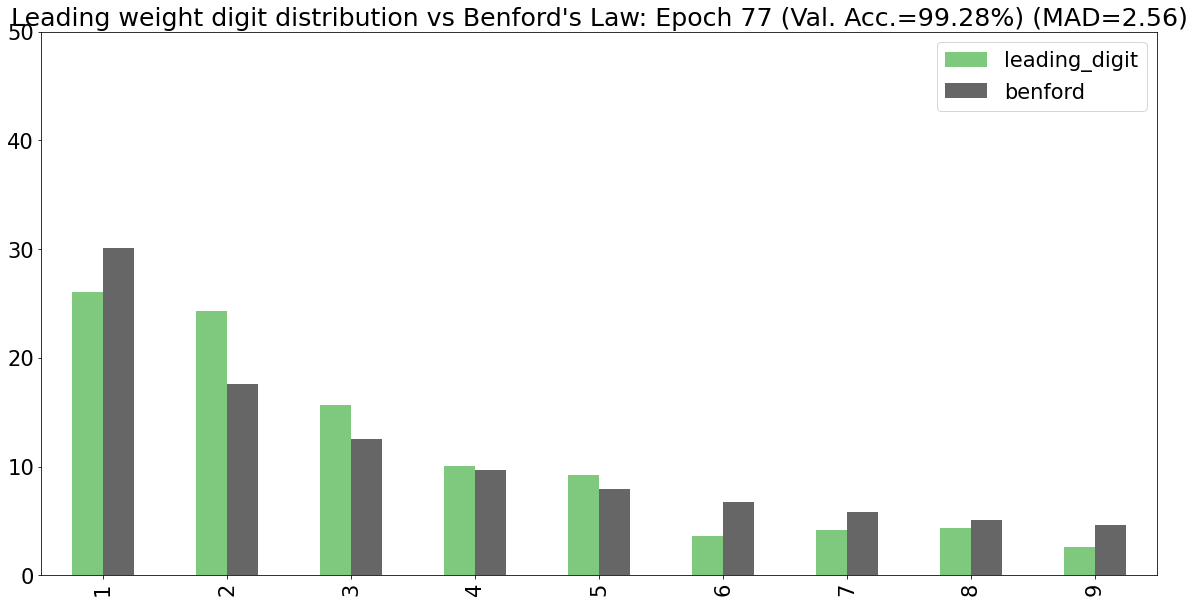

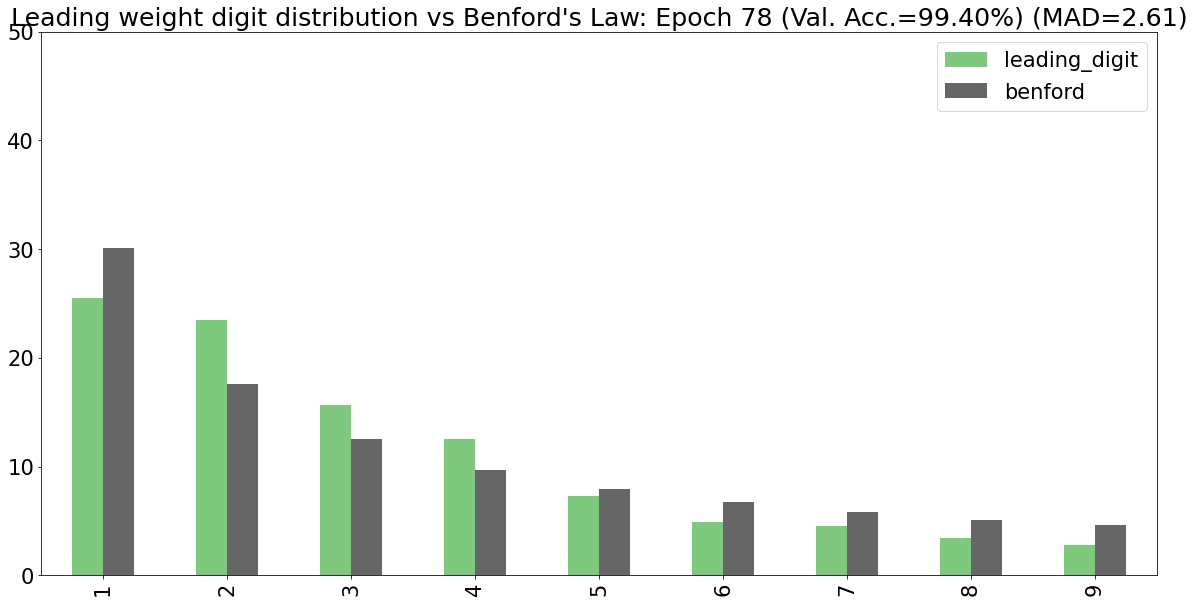

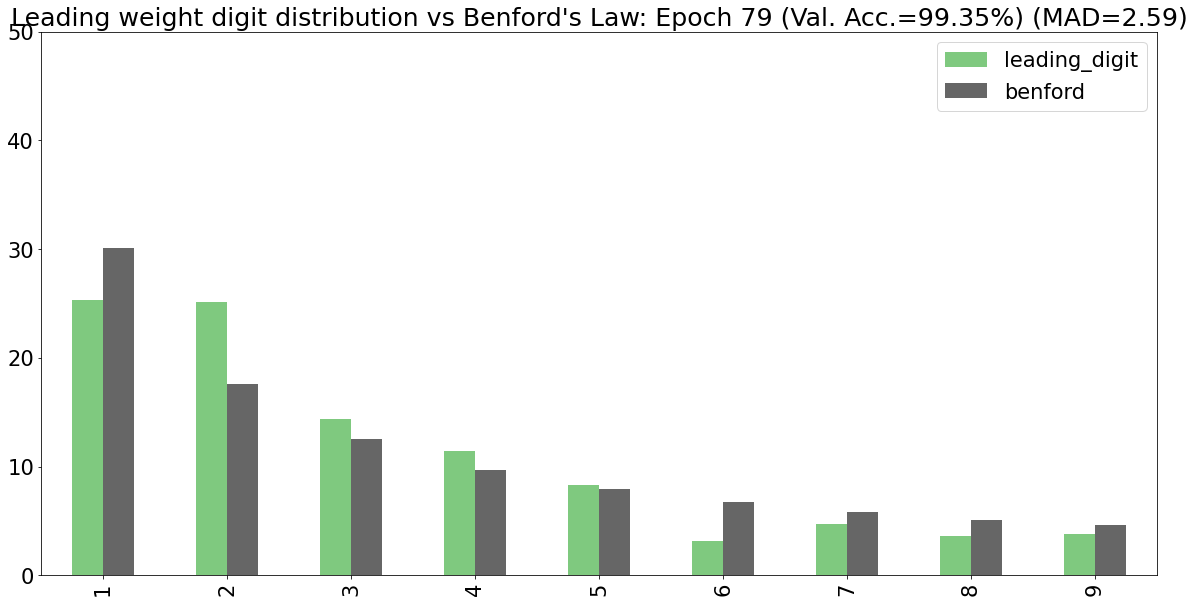

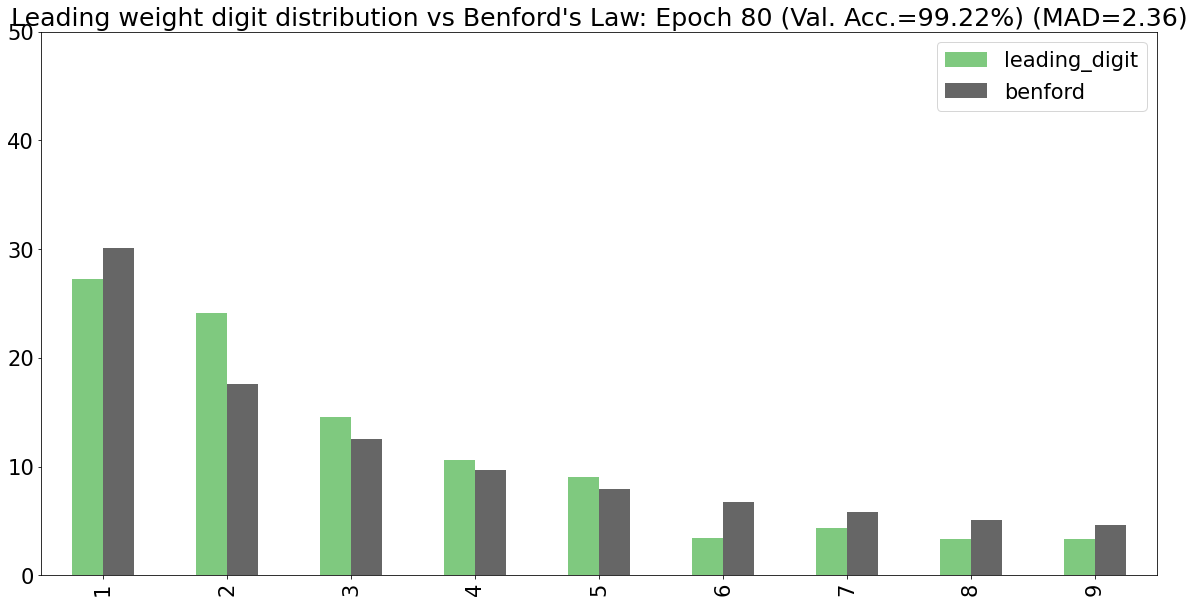

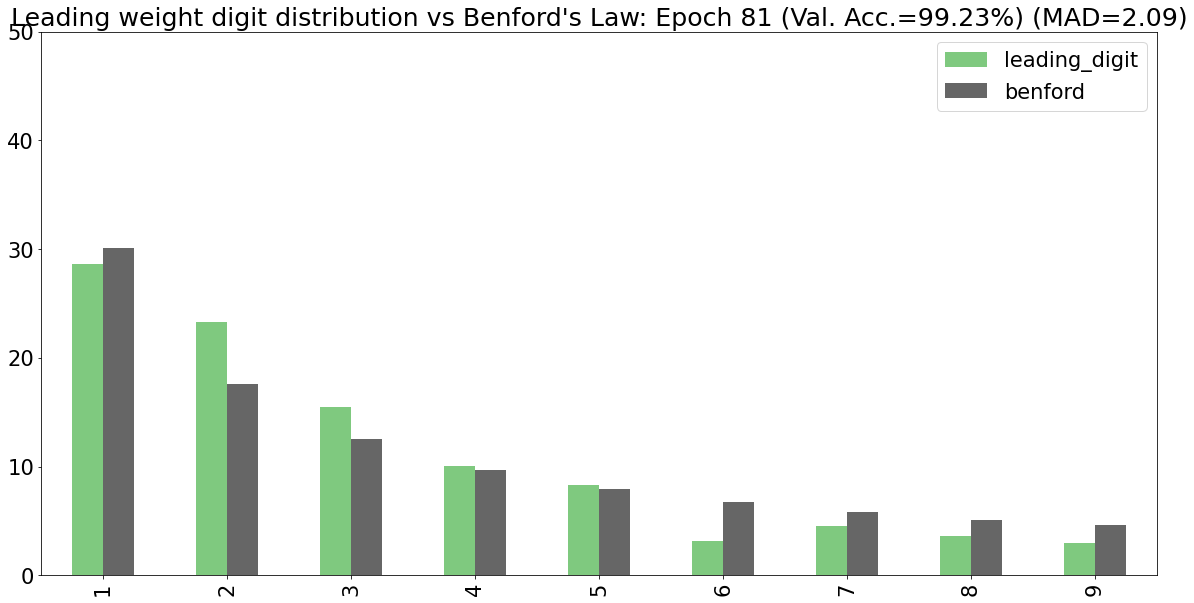

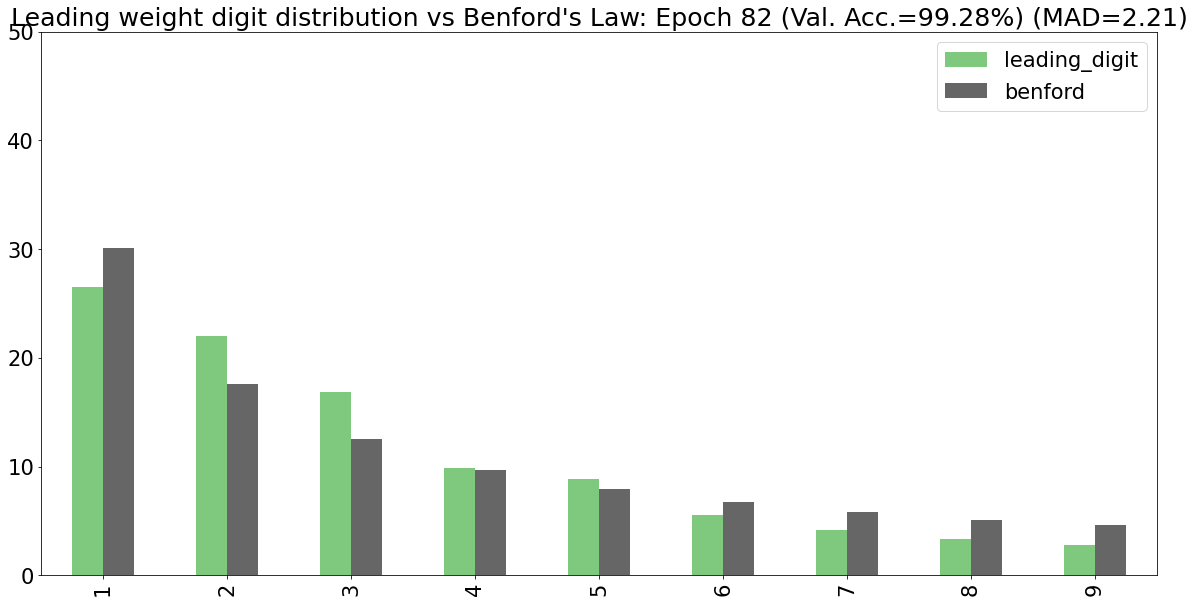

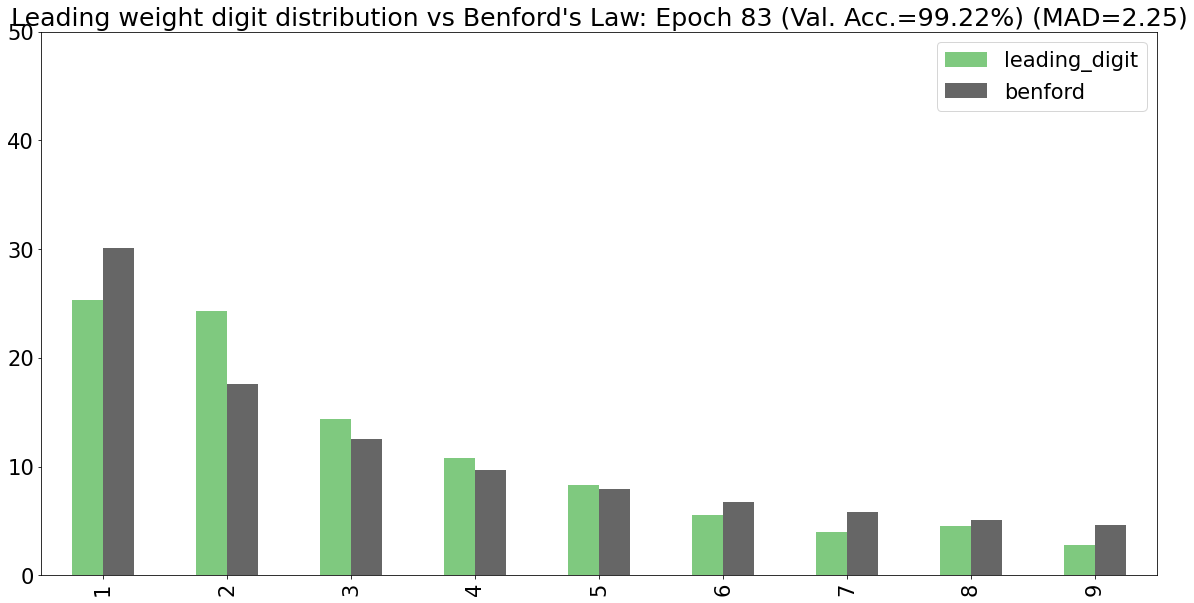

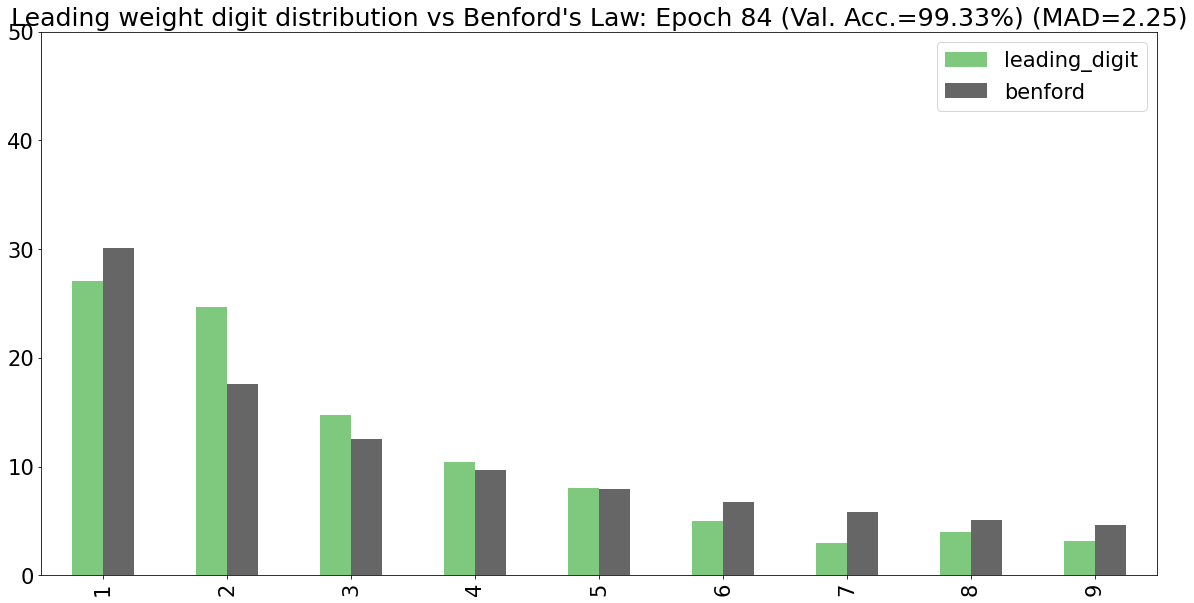

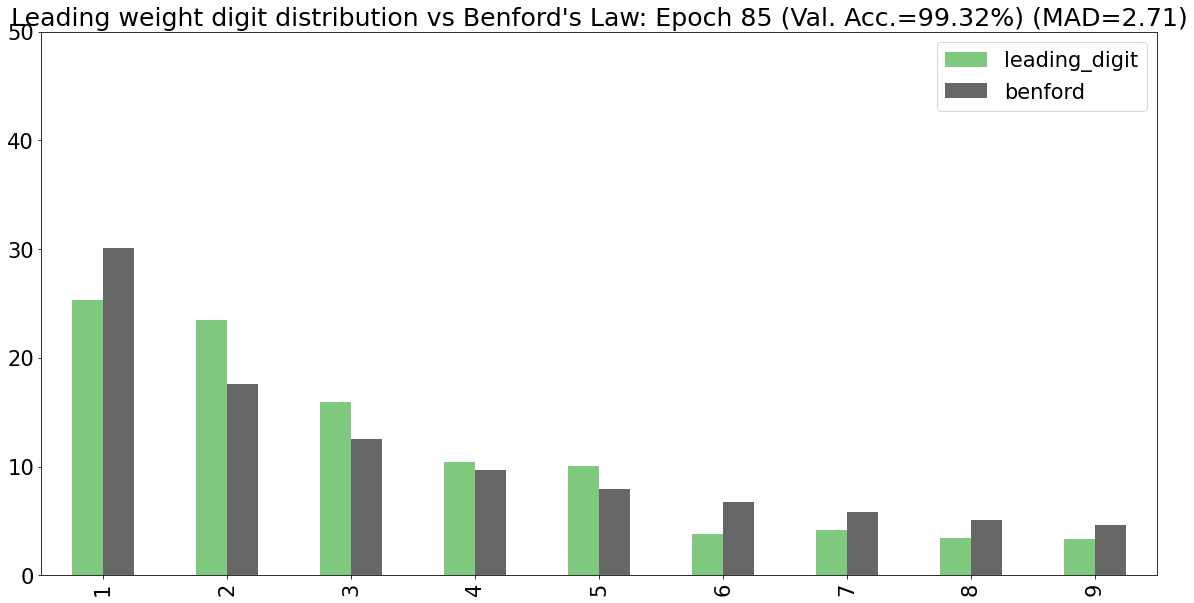

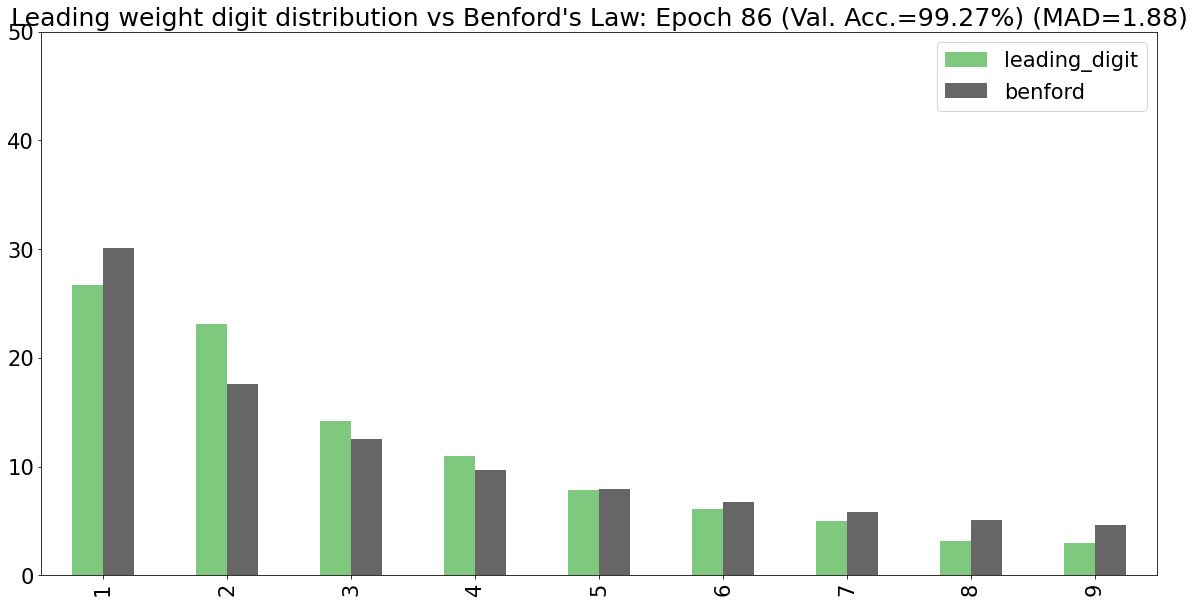

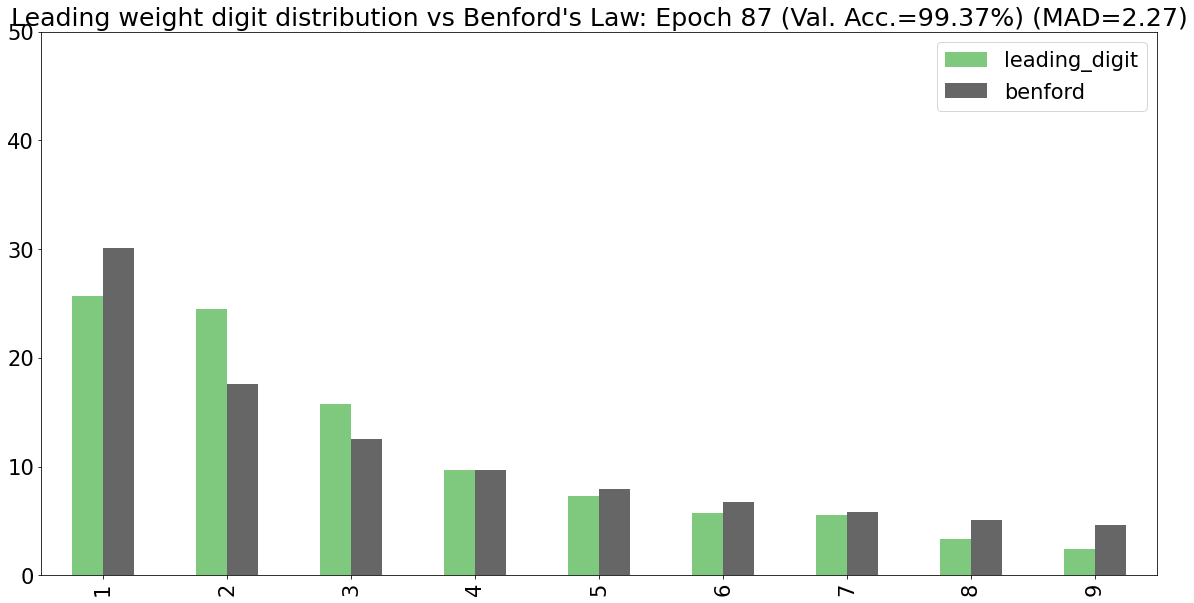

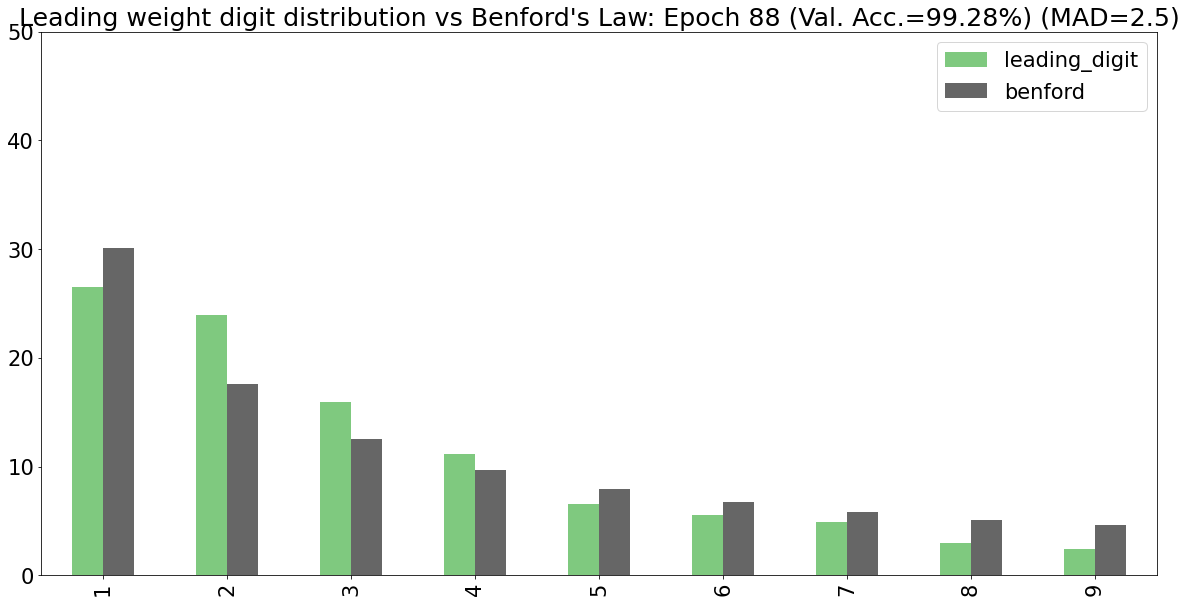

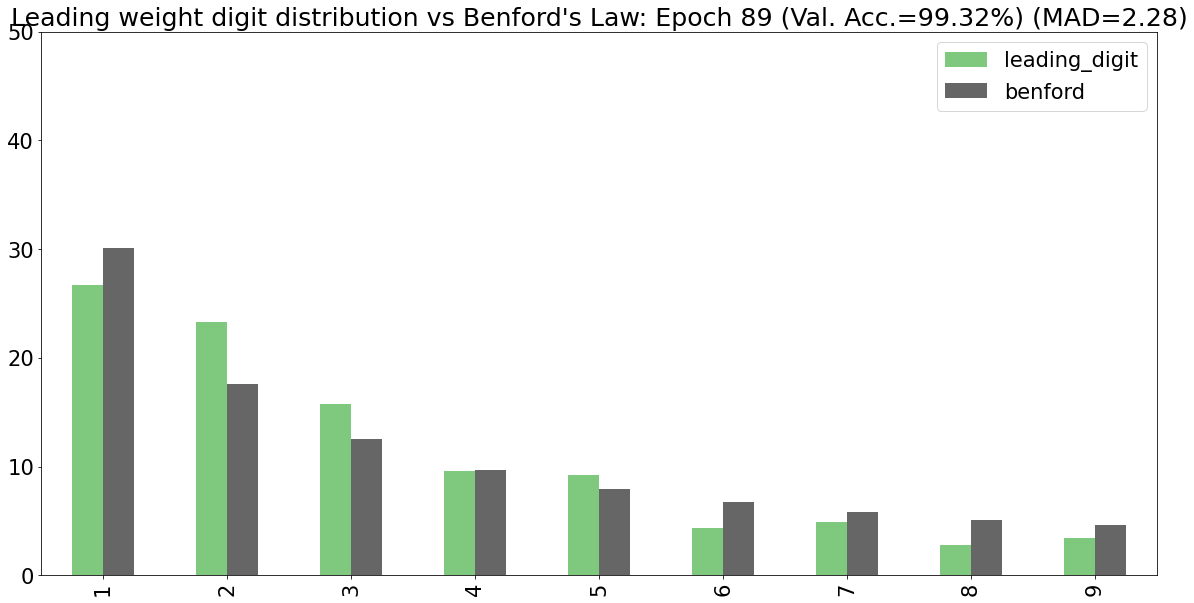

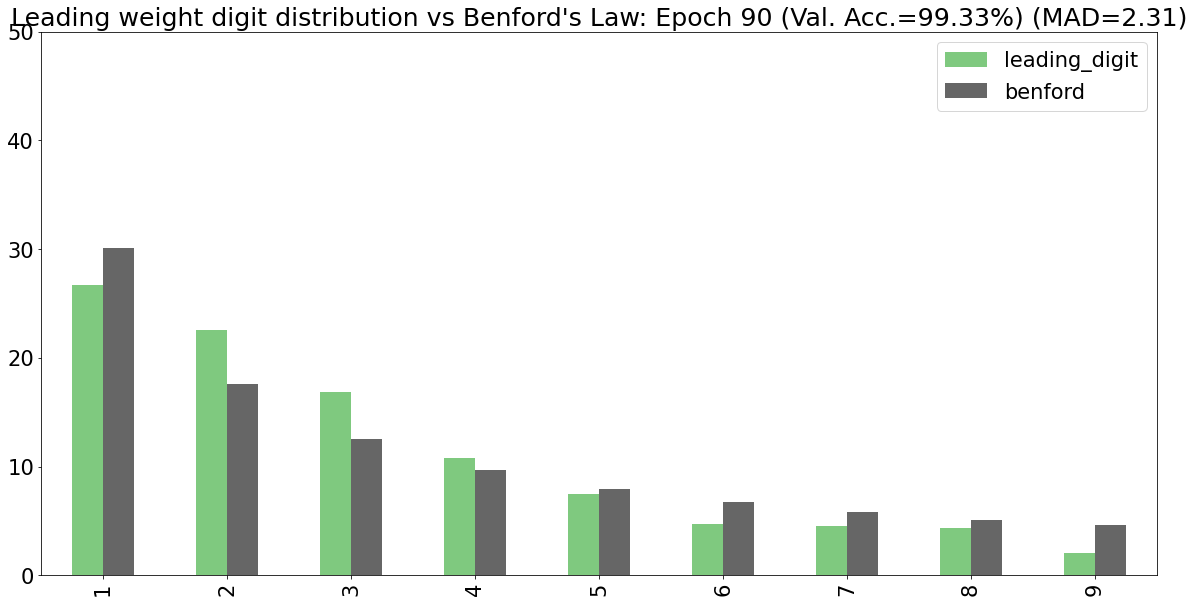

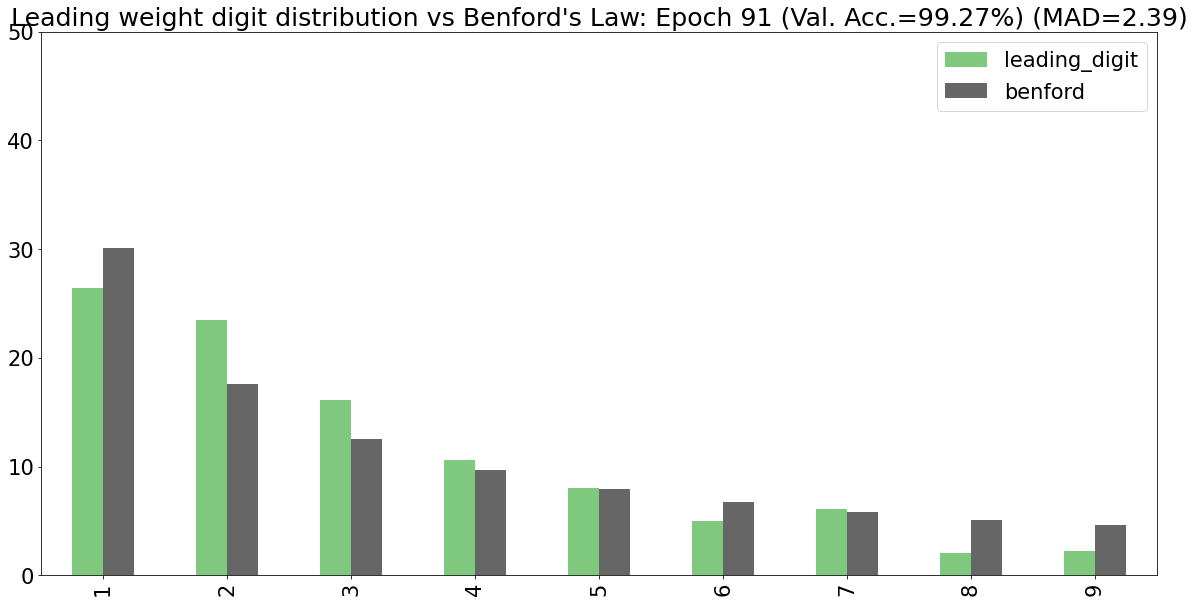

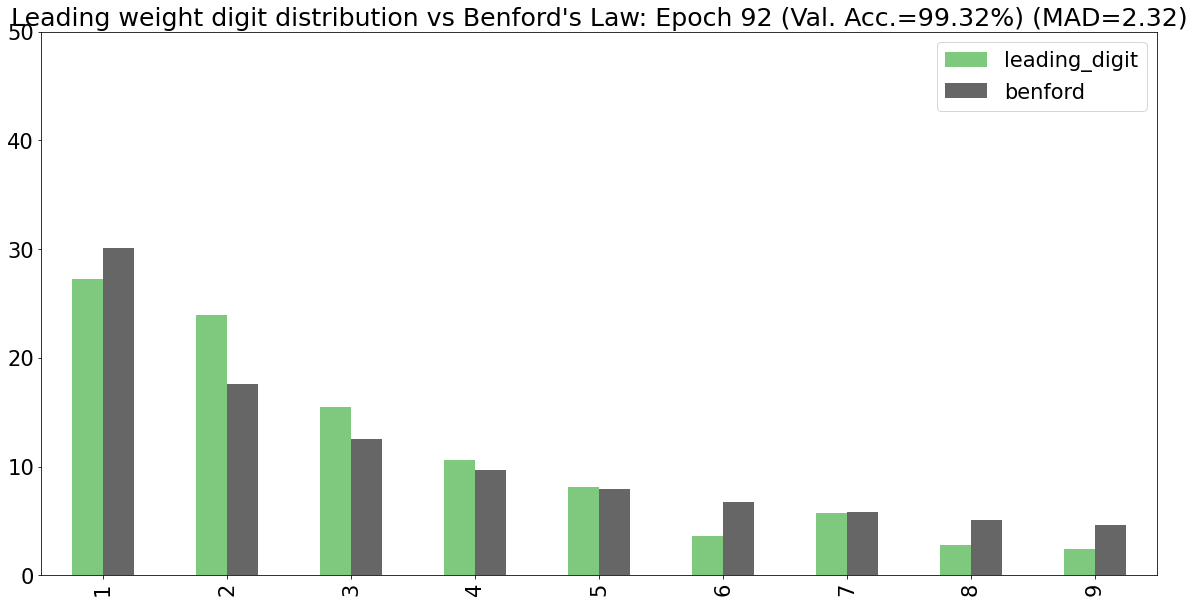

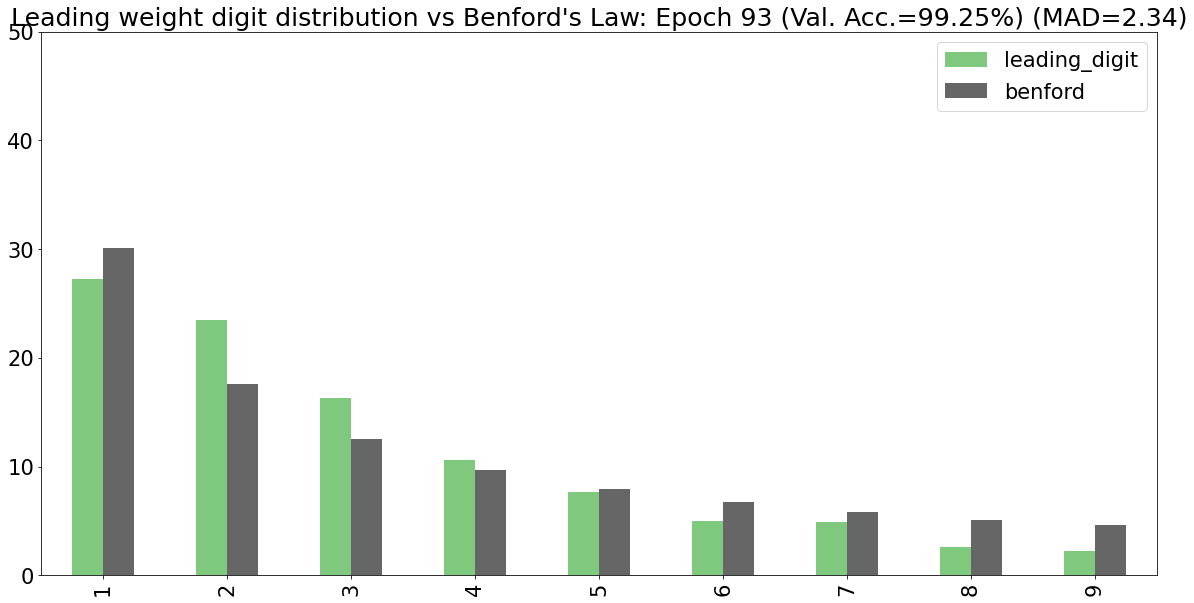

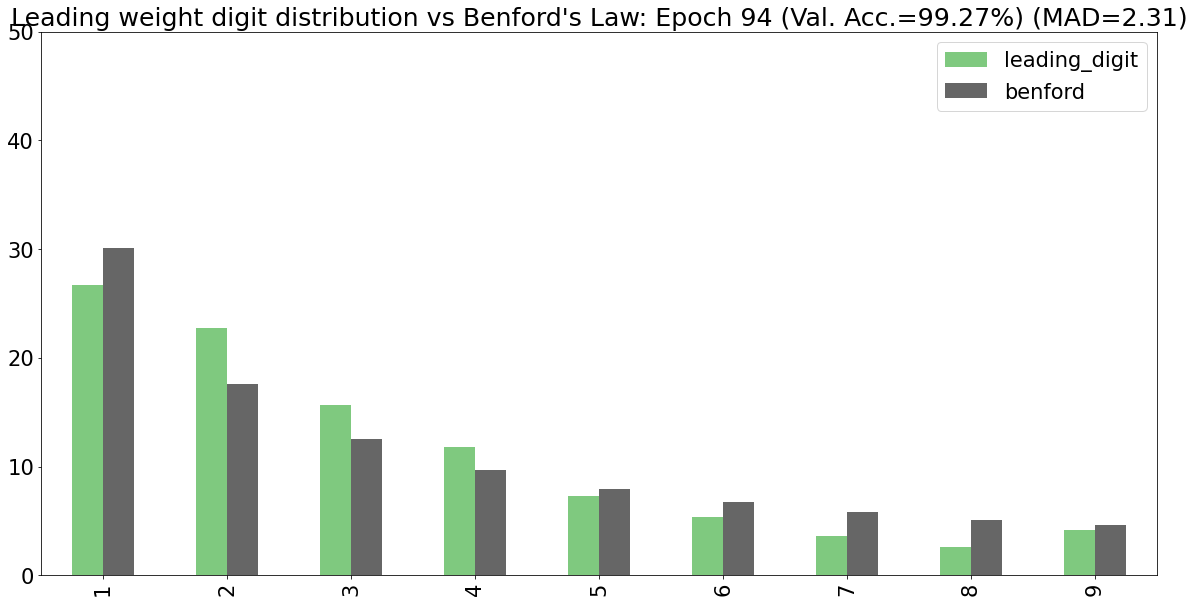

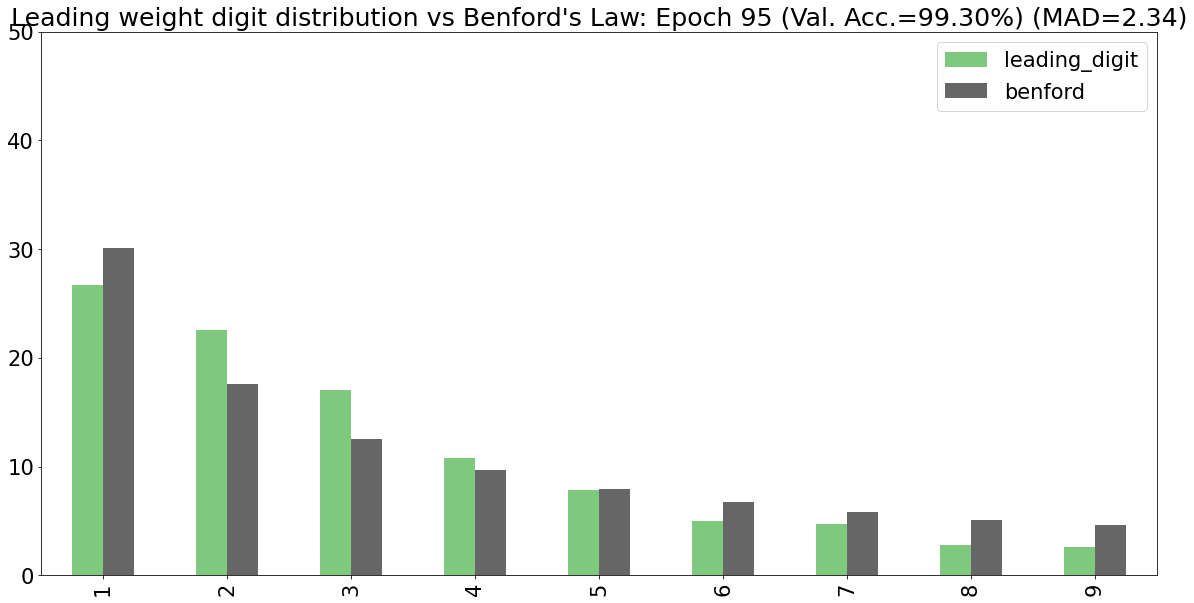

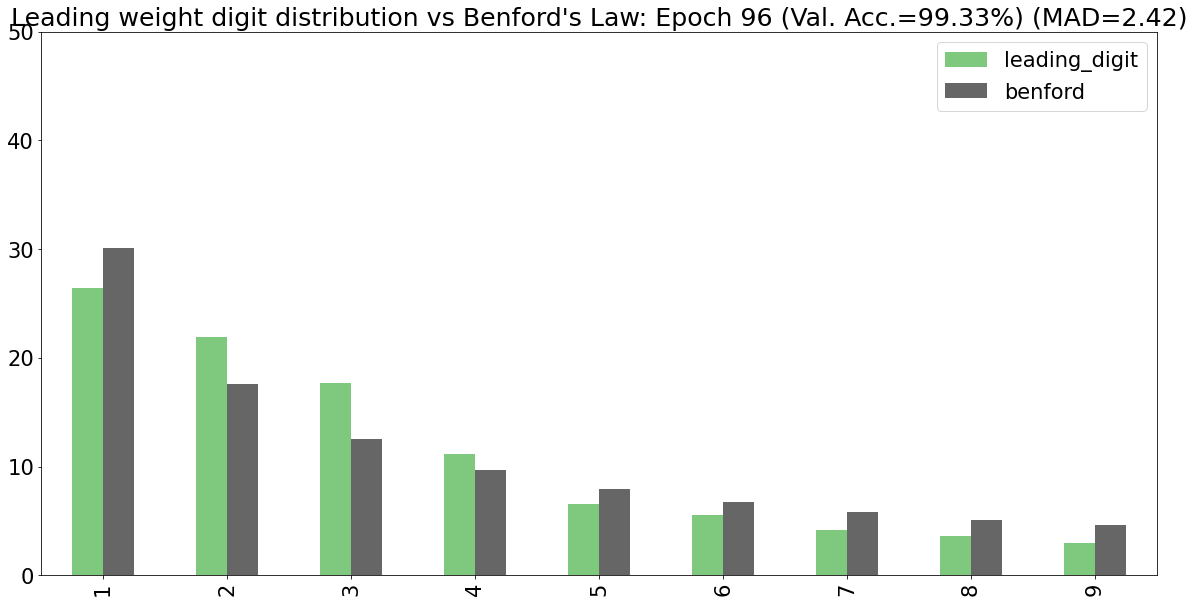

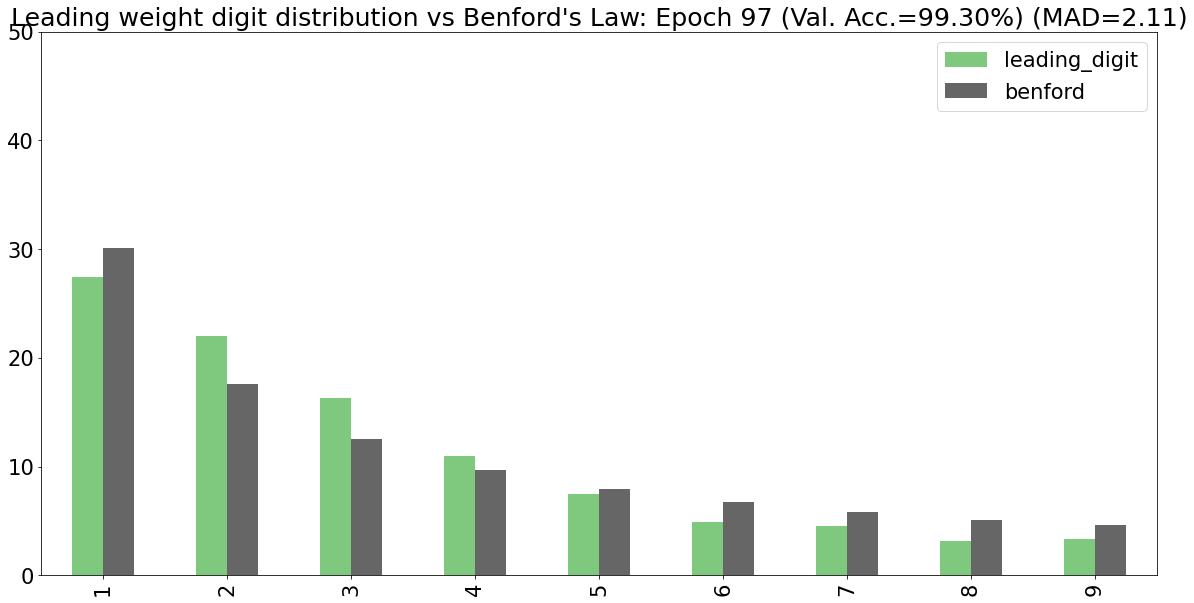

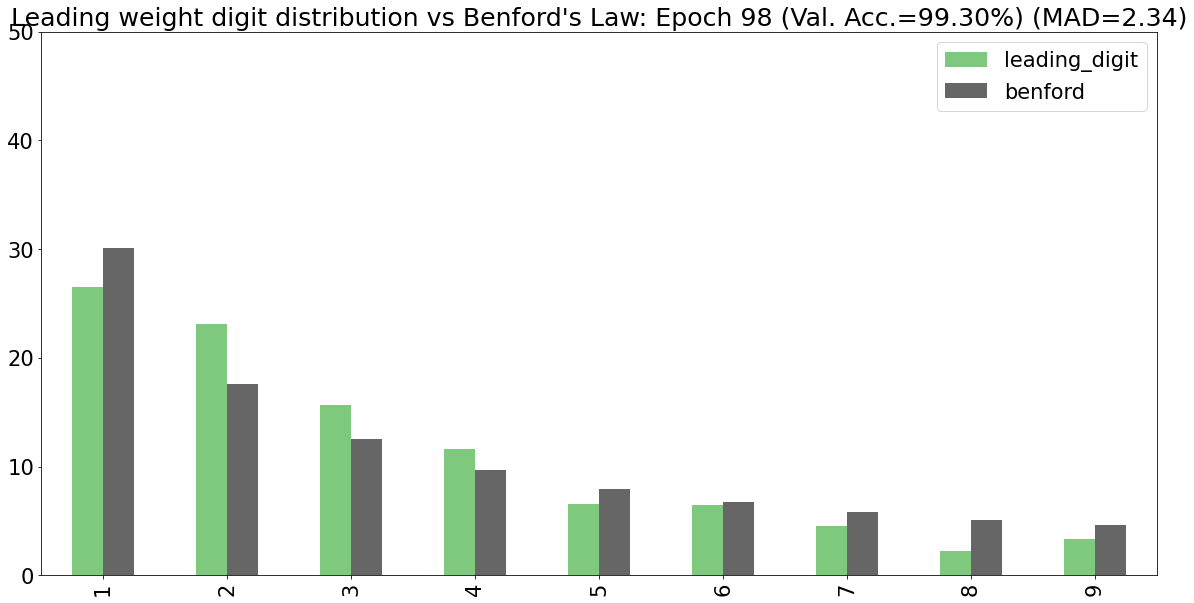

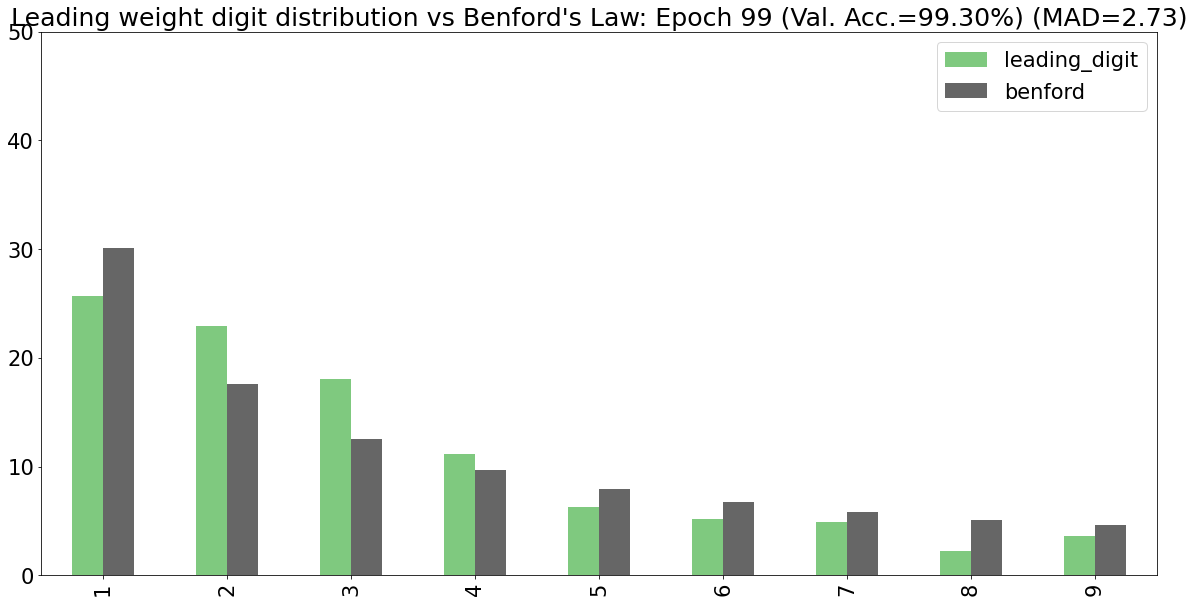

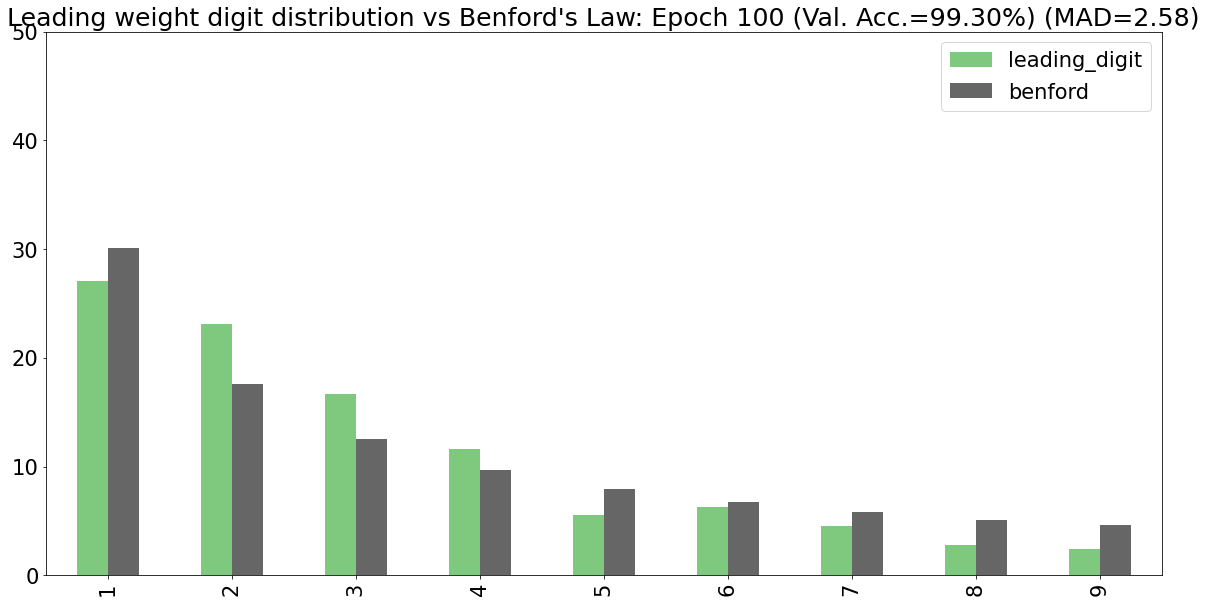

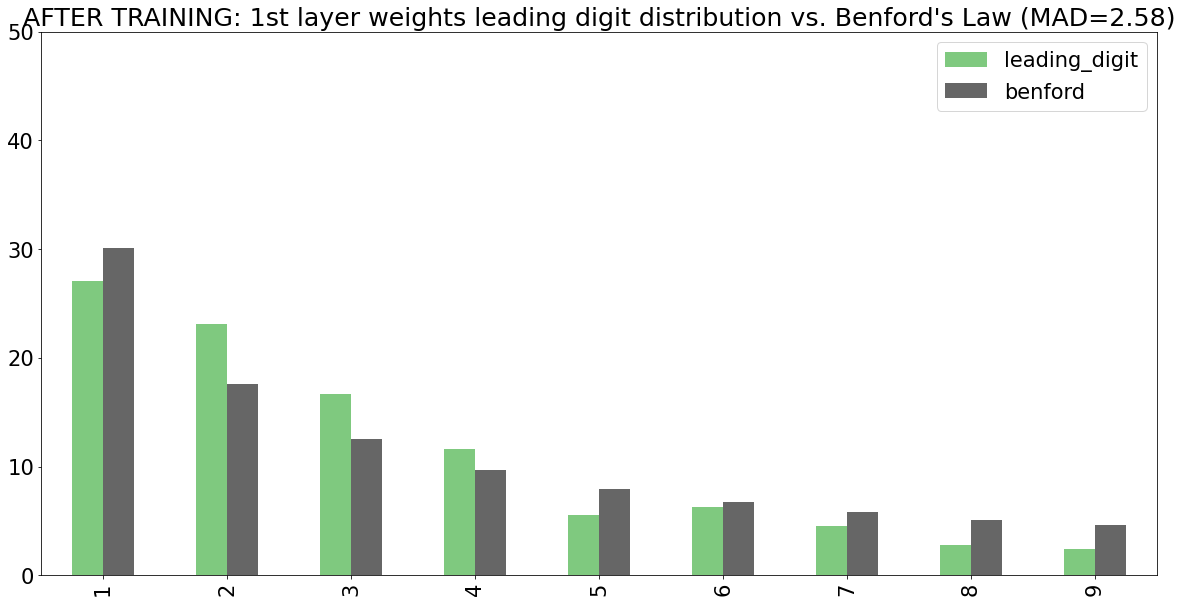

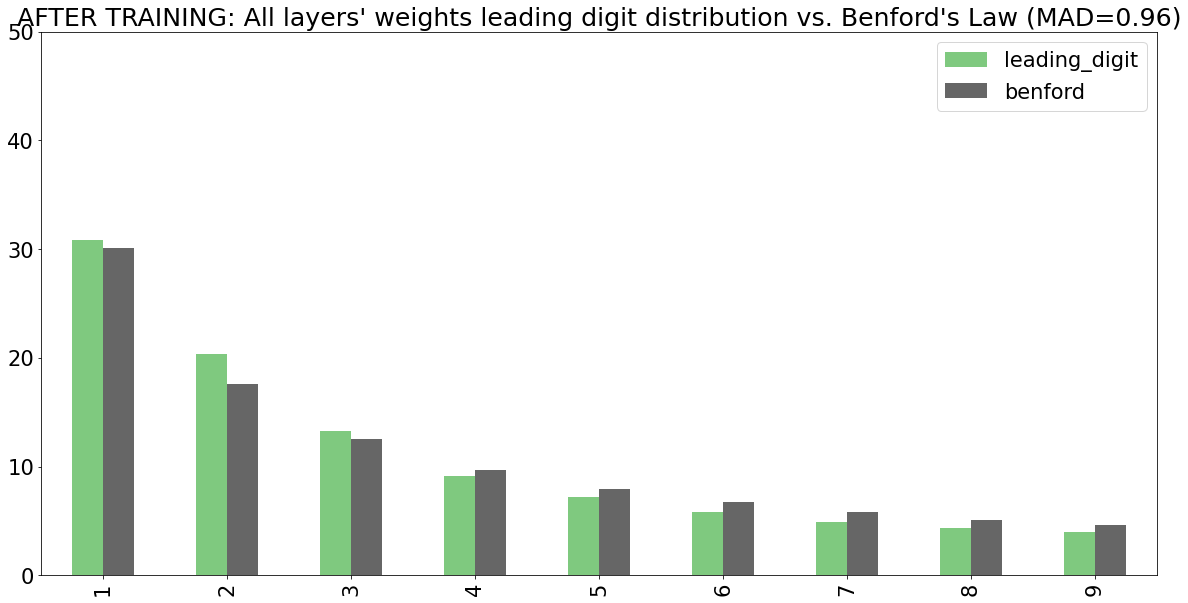

In [11]:
benford_callback = PlotBenford()
model.fit(x_train, y_train, batch_size=128, epochs=100, validation_split=0.1, callbacks = [benford_callback])

In [12]:
model.save("trained_model.h5")
# model = tf.keras.models.load_model("trained_model.h5")

In [13]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.029099347140454035
Test accuracy: 0.9928


# Plot MAD vs Acc & Val Acc

In [14]:
accs = benford_callback.accs
valaccs = benford_callback.valaccs
mads = benford_callback.mads

In [15]:
df = pd.DataFrame({'Acc':accs, 'Val Acc': valaccs, 'MAD': mads})

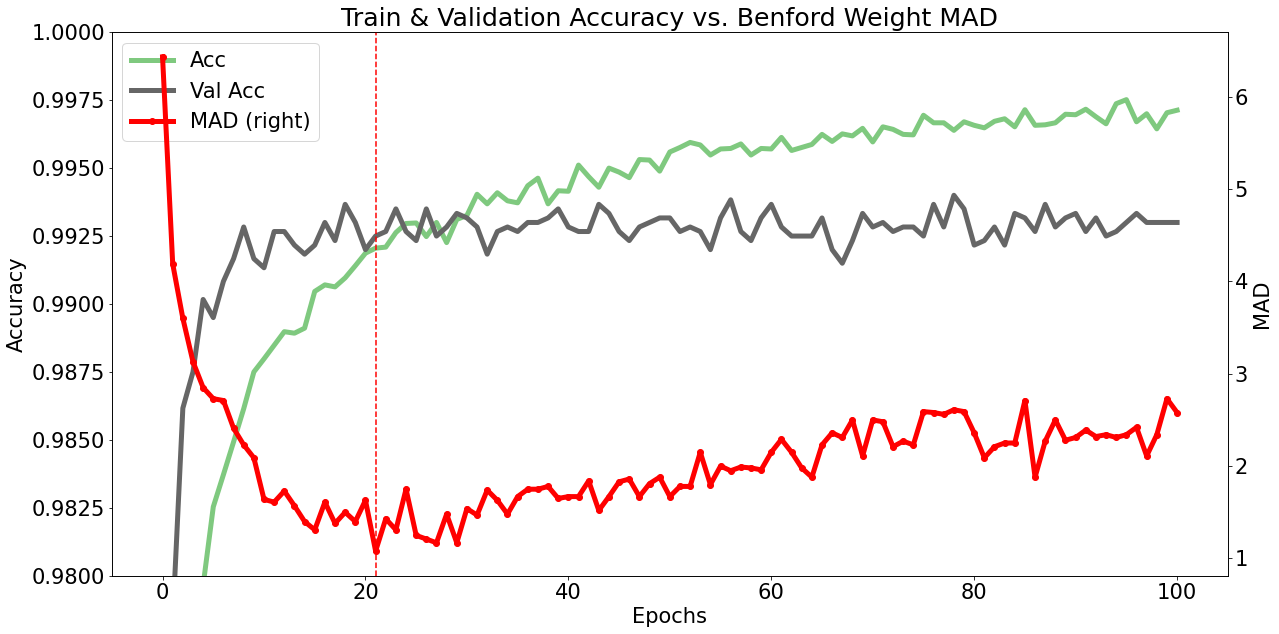

<Figure size 432x288 with 0 Axes>

In [18]:
ax = df[['Acc', 'Val Acc']].plot(figsize = (20,10),
                                 title = "Train & Validation Accuracy vs. Benford Weight MAD", 
                                 cmap="Accent", linewidth = 5)
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epochs')
ax.set_ylim([0.98,1])
ax = df['MAD'].plot(secondary_y=True, color='r', marker='o', linewidth = 5, legend=True)
ax.set_ylabel('MAD')

ax.axvline(x=df['MAD'].argmin(), color='r', linestyle='dashed')

plt.show()
plt.savefig('plots/accuracy_vs_mad.png', dpi=300, bbox_inches='tight')

In [17]:
df.iloc[df['Val Acc'].argmax()]

Acc        0.996389
Val Acc    0.994000
MAD        2.610000
Name: 78, dtype: float64

# Plot weight leading digit distribution vs. Benford's Law

## First layer only

   benford  leading_digit  deviation  abs_deviation
1     30.1      13.888889 -16.211111      16.211111
2     17.6      10.763889  -6.836111       6.836111
3     12.5      11.111111  -1.388889       1.388889
4      9.7      11.805556   2.105556       2.105556
5      7.9       7.812500  -0.087500       0.087500
6      6.7      11.111111   4.411111       4.411111
7      5.8       9.375000   3.575000       3.575000
8      5.1      12.847222   7.747222       7.747222
9      4.6      11.284722   6.684722       6.684722

>>> Mean absolute deviation: 5.45


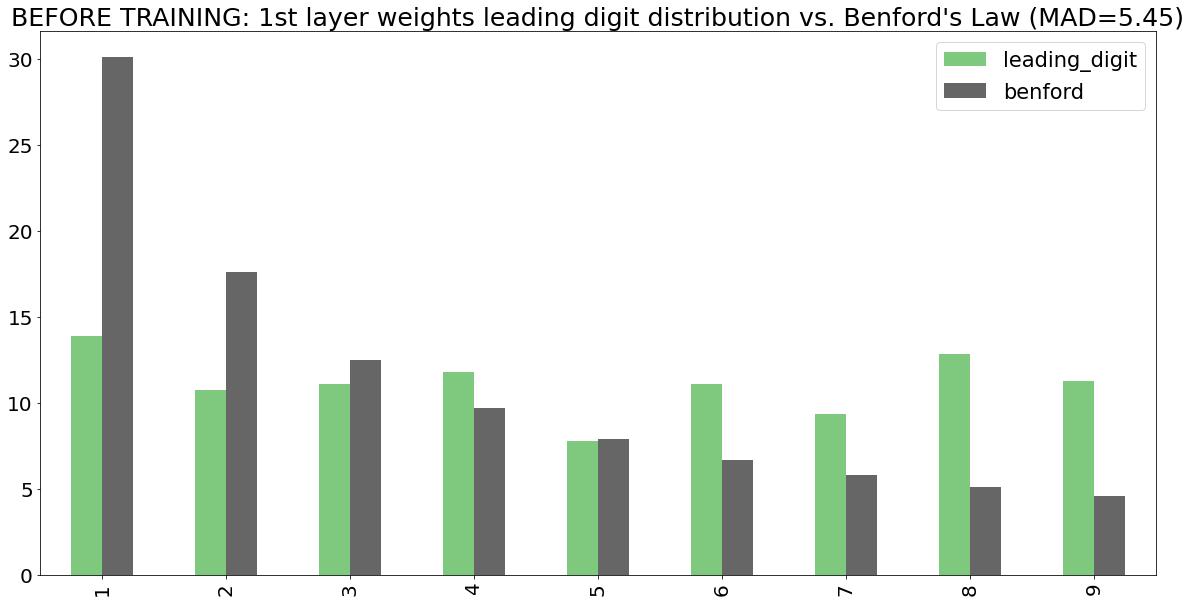

In [346]:
plot_benford_for_first_layer("BEFORE TRAINING: 1st layer weights leading digit distribution vs. Benford's Law")

In [ ]:
plot_benford_for_first_layer("AFTER TRAINING: 1st layer weights leading digit distribution vs. Benford's Law")

## All layers

   benford  leading_digit  deviation  abs_deviation
1     30.1      16.364147 -13.735853      13.735853
2     17.6      16.016093  -1.583907       1.583907
3     12.5      16.240644   3.740644       3.740644
4      9.7      16.143338   6.443338       6.443338
5      7.9      16.031063   8.131063       8.131063
6      6.7      11.805763   5.105763       5.105763
7      5.8       3.877246  -1.922754       1.922754
8      5.1       1.708458  -3.391542       3.391542
9      4.6       1.813249  -2.786751       2.786751

>>> Mean absolute deviation: 5.2


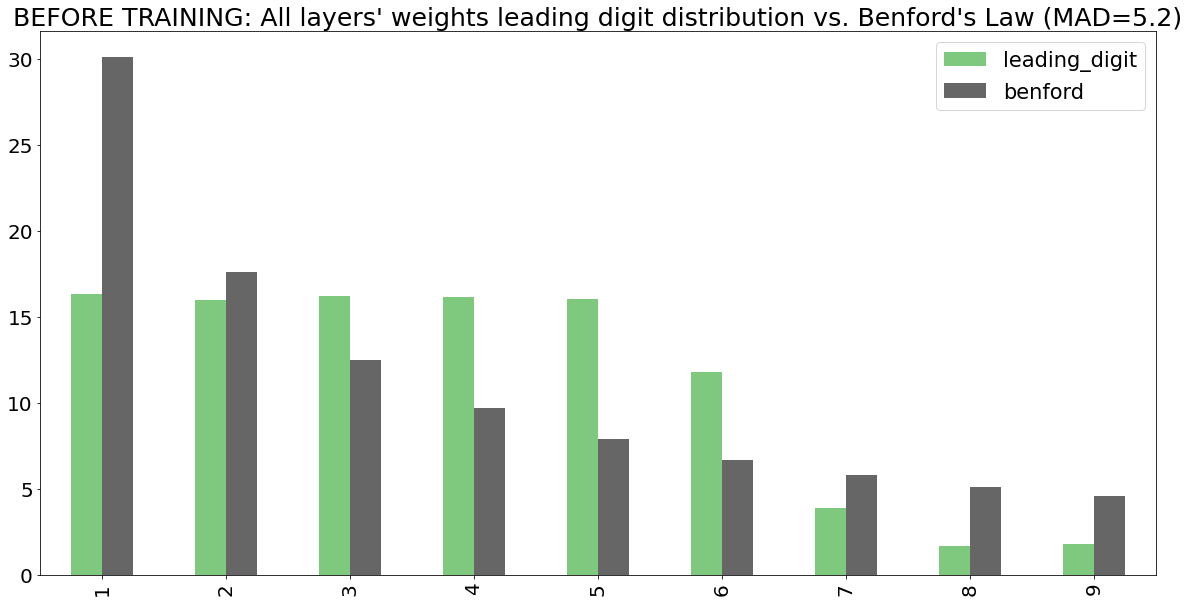

In [347]:
plot_benford_for_all_layers("BEFORE TRAINING: All layers' weights leading digit distribution vs. Benford's Law")

In [ ]:
plot_benford_for_all_layers("AFTER TRAINING: All layers' weights leading digit distribution vs. Benford's Law")